# ER Target Prediction — Two-Step Ligand Classifier

Two-step scaffold-aware classifier for ERα/ERβ/GPER1 (step1 ER vs GPER1, step2 ESR1 vs ESR2), plus QSAR, docking, and analysis.
- Working dir: `/media/.../ER`
- Training data: `ER_Ligands.xlsx`
- Outputs: under `Output/`



## Environment Setup (run once when needed)

- Requirements: Python 3.9+, PyTorch ≥ 2.2, RDKit, scikit-learn, tqdm
- If PyTorch/deps are missing, run commands below (CPU by default; use CUDA wheel URL if you have GPU).
- Set `INSTALL_DEPS = True` to auto-install; otherwise commands will be printed.


In [1]:

INSTALL_DEPS = False  # Set True to auto-install dependencies (requires internet)
install_commands = [
    "python -m pip install --upgrade pip",
    "pip install torch==2.2.1 torchvision==0.17.1 torchaudio==2.2.1 --index-url https://download.pytorch.org/whl/cpu",
    "pip install rdkit-pypi==2023.9.5 scikit-learn==1.5.1 tqdm numpy pandas matplotlib seaborn umap-learn"
]

if INSTALL_DEPS:
    import shlex, subprocess
    for cmd in install_commands:
        print(f"Running: {cmd}")
        subprocess.check_call(shlex.split(cmd))
else:
    print("Planned install commands (set INSTALL_DEPS=True to execute automatically):")
    for cmd in install_commands:
        print("  ", cmd)


Planned install commands (set INSTALL_DEPS=True to execute automatically):
   python -m pip install --upgrade pip
   pip install torch==2.2.1 torchvision==0.17.1 torchaudio==2.2.1 --index-url https://download.pytorch.org/whl/cpu
   pip install rdkit-pypi==2023.9.5 scikit-learn==1.5.1 tqdm numpy pandas matplotlib seaborn umap-learn


In [2]:
# 0) Imports & environment check
import copy
import json
import math
import warnings
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd

from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors, Draw

try:
    import torch
    from torch import nn
    from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
except ImportError as exc:
    raise SystemExit("PyTorch not installed. Please run the Environment Setup cell.") from exc

import torch.nn.functional as F
from tqdm.auto import tqdm

from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    average_precision_score,
    precision_score,
    recall_score,
    precision_recall_curve,
    roc_curve,
    brier_score_loss,
    r2_score,
    mean_squared_error,
    mean_absolute_error,
)
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MultiLabelBinarizer

warnings.filterwarnings("ignore")
print("pandas", pd.__version__)
print("numpy", np.__version__)
print("torch", torch.__version__)

def compute_rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="white", context="notebook")
plt.rcParams["figure.dpi"] = 120
plt.rcParams["savefig.dpi"] = 200


pandas 2.3.3
numpy 1.26.4
torch 2.8.0+cu128


In [3]:
# Utils: save/show figures and images (defined early to avoid NameError)
try:
    from IPython.display import display
except Exception:
    def display(_):
        pass

SHOW_IMAGES_INLINE = True

# Remove grids and save figures
def save_and_show_fig(fig, path, dpi=200):
    try:
        for ax in fig.get_axes():
            ax.grid(False)
    except Exception:
        pass
    try:
        fig.tight_layout()
    except Exception:
        pass
    fig.savefig(path, dpi=dpi)
    print(f"Saved: {path}")
    if SHOW_IMAGES_INLINE:
        display(fig)
    try:
        plt.close(fig)
    except Exception:
        pass

def plot_confusion_matrix(cm, labels, ax=None, title=None, normalize=False, cmap="Blues"):
    if ax is None:
        _, ax = plt.subplots(figsize=(4, 3.2))
    if normalize:
        data = cm.astype(float)
        row_sums = data.sum(axis=1, keepdims=True)
        data = np.divide(data, row_sums, out=np.zeros_like(data), where=row_sums != 0)
        annot_data = data
        fmt = ".2f"
    else:
        data = cm.astype(float)
        annot_data = cm.astype(int)
        fmt = "d"
    sns.heatmap(
        data,
        annot=annot_data,
        fmt=fmt,
        cmap=cmap,
        xticklabels=labels,
        yticklabels=labels,
        ax=ax,
    )
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    if title:
        ax.set_title(title)
    return ax
def plot_loss_curves(histories, title, ax=None, label_prefix=""):
    if not histories:
        return None
    if ax is None:
        _, ax = plt.subplots(figsize=(6, 4))
    train_series = [h.get("train_loss", []) for h in histories if h.get("train_loss")]
    val_series = [h.get("val_loss", []) for h in histories if h.get("val_loss")]
    if train_series:
        min_len = min(len(x) for x in train_series)
        train_mat = np.array([x[:min_len] for x in train_series], dtype=float)
        ax.plot(train_mat.mean(axis=0), label=f"{label_prefix}Train", color="#1f77b4")
        ax.fill_between(
            np.arange(min_len),
            train_mat.mean(axis=0) - train_mat.std(axis=0),
            train_mat.mean(axis=0) + train_mat.std(axis=0),
            color="#1f77b4",
            alpha=0.15,
        )
    if val_series:
        min_len = min(len(x) for x in val_series)
        val_mat = np.array([x[:min_len] for x in val_series], dtype=float)
        ax.plot(val_mat.mean(axis=0), label=f"{label_prefix}Val", color="#ff7f0e")
        ax.fill_between(
            np.arange(min_len),
            val_mat.mean(axis=0) - val_mat.std(axis=0),
            val_mat.mean(axis=0) + val_mat.std(axis=0),
            color="#ff7f0e",
            alpha=0.15,
        )
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.set_title(title)
    ax.legend()
    return ax

from io import BytesIO

def _to_pil_image(obj):
    try:
        from PIL import Image as PILImage
    except Exception:
        PILImage = None
    if 'PILImage' in locals() and PILImage is not None:
        if isinstance(obj, PILImage.Image):
            return obj
    try:
        from IPython.display import Image as IPyImage
        if isinstance(obj, IPyImage):
            if 'PILImage' not in locals() or PILImage is None:
                from PIL import Image as PILImage
            return PILImage.open(BytesIO(obj.data))
    except Exception:
        pass
    if isinstance(obj, (bytes, bytearray)):
        try:
            from PIL import Image as PILImage
            return PILImage.open(BytesIO(obj))
        except Exception:
            return None
    return None

# Save images that may be PIL.Image, IPython.display.Image, or bytes
def save_and_show_img(img, path):
    pil_img = _to_pil_image(img)
    if pil_img is not None:
        pil_img.save(path)
        print(f"Saved: {path}")
        if SHOW_IMAGES_INLINE:
            display(pil_img)
        return
    if hasattr(img, 'save'):
        try:
            img.save(path)
            print(f"Saved: {path}")
            if SHOW_IMAGES_INLINE:
                display(img)
            return
        except Exception as e:
            print(f"Save via .save failed: {e}")
    try:
        data = getattr(img, 'data', None)
        if data is not None:
            with open(path, 'wb') as f:
                f.write(data)
            print(f"Saved (raw): {path}")
            if SHOW_IMAGES_INLINE:
                display(img)
            return
    except Exception as e:
        print(f"Save failed: {e}")
    if SHOW_IMAGES_INLINE:
        try:
            display(img)
        except Exception:
            pass


In [4]:
# 1) Paths & logging
BASE_DIR = Path('/media/xuchengjie/E7562A2674DB25F7/SRRSH/2025.6.14/BP/ER')
DATA_PATH = BASE_DIR / 'ER_Ligands.xlsx'
STRUCTURES_DIR = BASE_DIR / 'Structures'
OUTPUT_ROOT = BASE_DIR / 'Output'
OUTPUT_ROOT.mkdir(parents=True, exist_ok=True)

RUN_DIR = OUTPUT_ROOT  # fixed output directory
RUN_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR = RUN_DIR / 'figures'
FIG_DIR.mkdir(parents=True, exist_ok=True)
LOG_FILE = RUN_DIR / 'run.log'

def fig_path(name):
    return FIG_DIR / name

def log(message):
    text = f"[{datetime.now().isoformat()}] {message}"
    print(text)
    with LOG_FILE.open('a', encoding='utf-8') as fh:
        fh.write(text + "\n")

log(f'Working dir: {BASE_DIR}')
log(f'Output dir: {RUN_DIR}')
log(f'Figures dir: {FIG_DIR}')


[2026-01-09T09:05:36.046833] Working dir: /media/xuchengjie/E7562A2674DB25F7/SRRSH/2025.6.14/BP/ER
[2026-01-09T09:05:36.063246] Output dir: /media/xuchengjie/E7562A2674DB25F7/SRRSH/2025.6.14/BP/ER/Output
[2026-01-09T09:05:36.063419] Figures dir: /media/xuchengjie/E7562A2674DB25F7/SRRSH/2025.6.14/BP/ER/Output/figures


In [5]:
# 2) Configurations
TARGET_LABELS = ['ESR1', 'ESR2', 'GPER1']  # Estrogen receptor alpha / beta / GPER1 (canonical labels)
AFFINITY_COLS = ['AC']  # merged activity column (nM); lower = stronger
POS_THRESHOLD_NM = 1000.0  # AC <= 1 µM treated as positive
FINGERPRINT_BITS = 2048
FINGERPRINT_RADIUS = 2     # ECFP4
SEED = 42
TEST_SIZE = 0.2
N_FOLDS = 5
GRAPH_DIM = 384
GT_HEADS = 8
GT_LAYERS = 6
DROPOUT = 0.2
BATCH_SIZE = 24
EPOCHS = 70
LR = 3e-4
WEIGHT_DECAY = 2e-4
GRAD_CLIP = 1.0
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

USE_FOCAL_LOSS = False
FOCAL_GAMMA = 2.0
FOCAL_ALPHA = {'ESR1': 0.3, 'ESR2': 0.4, 'GPER1': 0.65}
POS_WEIGHT_BOOST = {'GPER1': 1.5}
EARLY_STOP_PATIENCE = 12
WARM_RESTART = {'T_0': 15, 'T_mult': 2}

log({
    'TARGET_LABELS': TARGET_LABELS,
    'POS_THRESHOLD_NM': POS_THRESHOLD_NM,
    'FINGERPRINT_BITS': FINGERPRINT_BITS,
    'FINGERPRINT_RADIUS': FINGERPRINT_RADIUS,
    'GRAPH_DIM': GRAPH_DIM,
    'GT_LAYERS': GT_LAYERS,
    'EPOCHS': EPOCHS,
    'USE_FOCAL_LOSS': USE_FOCAL_LOSS,
    'EARLY_STOP_PATIENCE': EARLY_STOP_PATIENCE
})

torch.manual_seed(SEED)
np.random.seed(SEED)
MAX_NODES = 120
DROPEDGE_P = 0.1
CONFIG = {
    'TARGET_LABELS': TARGET_LABELS,
    'AFFINITY_COLS': AFFINITY_COLS,
    'POS_THRESHOLD_NM': POS_THRESHOLD_NM,
    'FINGERPRINT_BITS': FINGERPRINT_BITS,
    'FINGERPRINT_RADIUS': FINGERPRINT_RADIUS,
    'SEED': SEED,
    'TEST_SIZE': TEST_SIZE,
    'N_FOLDS': N_FOLDS,
    'GRAPH_DIM': GRAPH_DIM,
    'GT_HEADS': GT_HEADS,
    'GT_LAYERS': GT_LAYERS,
    'DROPOUT': DROPOUT,
    'BATCH_SIZE': BATCH_SIZE,
    'EPOCHS': EPOCHS,
    'LR': LR,
    'WEIGHT_DECAY': WEIGHT_DECAY,
    'GRAD_CLIP': GRAD_CLIP,
    'USE_FOCAL_LOSS': USE_FOCAL_LOSS,
    'FOCAL_GAMMA': FOCAL_GAMMA,
    'FOCAL_ALPHA': FOCAL_ALPHA,
    'POS_WEIGHT_BOOST': POS_WEIGHT_BOOST,
    'EARLY_STOP_PATIENCE': EARLY_STOP_PATIENCE,
    'MAX_NODES': MAX_NODES
}

HARD_SAMPLING = {'LAMBDA': 2.0, 'MAX_MULT': 5.0}
RANK_MARGIN = 0.2
RANK_LOSS_WEIGHT = 0.2


[2026-01-09T09:05:36.073190] {'TARGET_LABELS': ['ESR1', 'ESR2', 'GPER1'], 'POS_THRESHOLD_NM': 1000.0, 'FINGERPRINT_BITS': 2048, 'FINGERPRINT_RADIUS': 2, 'GRAPH_DIM': 384, 'GT_LAYERS': 6, 'EPOCHS': 70, 'USE_FOCAL_LOSS': False, 'EARLY_STOP_PATIENCE': 12}


In [6]:

# 3) Load & clean ligand table
assert DATA_PATH.exists(), f'Missing data file: {DATA_PATH}'

TARGET_NAME_MAP = {
    'estrogen receptor alpha': 'ESR1',
    'estrogen receptor β': 'ESR2',
    'estrogen receptor beta': 'ESR2',
    'g-protein coupled estrogen receptor 1': 'GPER1',
    'g protein coupled estrogen receptor 1': 'GPER1',
    'gper1': 'GPER1'
}

def _find_ac_column(columns):
    def _norm(name):
        return ''.join(ch.lower() for ch in str(name) if ch.isalnum())
    for c in columns:
        if _norm(c) in ('ac', 'acnm'):
            return c
    return None


df = pd.read_excel(DATA_PATH)
df = df.rename(columns={'Ligand SMILES': 'smiles', 'Target Name': 'target'})
# Normalize AC column name (all activities merged into AC)
ac_col = _find_ac_column(df.columns)
if ac_col:
    df = df.rename(columns={ac_col: 'AC'})
else:
    raise KeyError("Expected an 'AC' (or 'AC (nM)') column with merged activity values (nM).")

for col in AFFINITY_COLS:
    df[col] = pd.to_numeric(df[col], errors='coerce')

log(f'Loaded table shape: {df.shape}')

def to_canonical(smiles):
    if not isinstance(smiles, str) or not smiles.strip():
        return None
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return Chem.MolToSmiles(mol)

df['can_smiles'] = df['smiles'].apply(to_canonical)

def normalize_target(name: str):
    if not isinstance(name, str):
        return None
    s = name.strip().lower().replace('β', 'beta')
    for key, val in TARGET_NAME_MAP.items():
        if key in s:
            return val
    return None

# Keep original column for audit
if 'target_raw' not in df.columns:
    df['target_raw'] = df['target']
# Apply normalization mapping
df['target'] = df['target_raw'].apply(normalize_target)
# Save a copy for mapping audit (before dropping NAs)
try:
    df_map_audit
except NameError:
    df_map_audit = df.copy()

# Drop unrecognized entries (if any)
df = df.dropna(subset=['can_smiles', 'target']).reset_index(drop=True)
log(f'After canonicalization: {df.shape}')

# Fix target order to the canonical list, but log anything missing
observed_targets = sorted(df['target'].unique().tolist())
missing_targets = [t for t in TARGET_LABELS if t not in observed_targets]
if missing_targets:
    log({'missing_targets_in_data': missing_targets})

targets = [t for t in TARGET_LABELS if t in observed_targets]
log(f'Targets ({len(targets)}): {targets}')


[2026-01-09T09:05:36.231392] Loaded table shape: (5878, 3)
[2026-01-09T09:05:37.140906] After canonicalization: (5876, 5)
[2026-01-09T09:05:37.141693] Targets (3): ['ESR1', 'ESR2', 'GPER1']


[09:05:37] Can't kekulize mol.  Unkekulized atoms: 29 30 31 32 33
[09:05:37] Can't kekulize mol.  Unkekulized atoms: 29 30 31 32 33


In [7]:
# 3b) Target mapping audit and export
import pandas as _pd
_map = df_map_audit.copy() if 'df_map_audit' in globals() else df.copy()
# Keep rows with original target only
_map = _map[_map['target_raw'].notna()].copy()
_map['normalized_target'] = _map['target']
# Cross-tab: raw target -> normalized target
cross = (_map.groupby(['target_raw','normalized_target'])
              .size().reset_index(name='count'))
# Fraction within each raw target
raw_tot = cross.groupby('target_raw')['count'].transform('sum')
cross['fraction_of_raw'] = cross['count'] / raw_tot
# Fraction over all records
all_tot = float(cross['count'].sum()) if len(cross) else 1.0
cross['fraction_of_total'] = cross['count'] / all_tot
# Sort for readability
cross = cross.sort_values(['normalized_target','count'], ascending=[True, False])
# Save to current run folder
TARGET_MAP_CSV = RUN_DIR / 'target_mapping_summary.csv'
cross.to_csv(TARGET_MAP_CSV, index=False)
print('Saved mapping audit:', TARGET_MAP_CSV)
# Preview first 12 rows
display(cross.head(12))


Saved mapping audit: /media/xuchengjie/E7562A2674DB25F7/SRRSH/2025.6.14/BP/ER/Output/target_mapping_summary.csv


,target_raw,normalized_target,count,fraction_of_raw,fraction_of_total
0,Estrogen receptor alpha,ESR1,3951,1.0,0.672167
1,Estrogen receptor beta,ESR2,1835,1.0,0.312181
2,G-protein coupled estrogen receptor 1,GPER1,92,1.0,0.015652


In [8]:
# 3c) Prepare AC dataset for QSAR blocks
import numpy as _np

def prepare_qsar_ac50_dataset():
    """Load ER_Ligands.xlsx and return canonical SMILES with numeric AC values."""
    source_path = DATA_PATH
    assert source_path.exists(), f'Missing ligand table: {source_path}'
    raw_df = pd.read_excel(source_path)
    raw_df = raw_df.rename(columns={'Ligand SMILES': 'smiles', 'Target Name': 'target'})
    ac_col = _find_ac_column(raw_df.columns)
    if ac_col:
        raw_df = raw_df.rename(columns={ac_col: 'AC'})
    else:
        raise KeyError("Expected an 'AC' (or 'AC (nM)') column with merged activity values (nM).")
    raw_df['target'] = raw_df['target'].apply(normalize_target)
    raw_df = raw_df.dropna(subset=['smiles', 'target']).reset_index(drop=True)

    raw_df['AC_raw'] = raw_df['AC']
    raw_df['AC'] = pd.to_numeric(raw_df['AC'], errors='coerce')
    mask_bad = raw_df['AC_raw'].astype(str).str.contains(r'[<>]', na=False)
    raw_df.loc[mask_bad, 'AC'] = _np.nan

    if 'to_canonical' in globals():
        canon_fn = to_canonical
    else:
        def canon_fn(smiles):
            if not isinstance(smiles, str) or not smiles.strip():
                return None
            mol = Chem.MolFromSmiles(smiles)
            return Chem.MolToSmiles(mol) if mol is not None else None
    raw_df['smiles'] = raw_df['smiles'].astype(str).apply(canon_fn)
    raw_df = raw_df.dropna(subset=['smiles']).reset_index(drop=True)

    qsar_df = raw_df.dropna(subset=['AC']).copy()
    qsar_df = qsar_df[_np.isfinite(qsar_df['AC']) & (qsar_df['AC'] > 0)].copy()
    qsar_df['logac50'] = _np.log10(qsar_df['AC'])
    qsar_df = qsar_df.drop_duplicates(subset=['smiles']).reset_index(drop=True)

    log({
        'qsar_raw_rows': int(len(raw_df)),
        'qsar_filtered_rows': int(len(qsar_df)),
        'ac_col': 'AC'
    })
    return qsar_df[['smiles', 'target', 'AC', 'logac50']]


In [9]:
# 4c) Fingerprint and functional-group helpers
from rdkit import DataStructs
from rdkit.Chem import AllChem, rdMolDescriptors, Descriptors

MAX_NODES_FALLBACK = globals().get('MAX_NODES', 120)

# ECFP4 bit vector -> numpy
import numpy as np

def ecfp4_bits(smiles, n_bits=2048, radius=2, return_bv=False):
    m = Chem.MolFromSmiles(smiles)
    if m is None:
        return None
    bv = AllChem.GetMorganFingerprintAsBitVect(m, radius, nBits=n_bits, useChirality=True)
    arr = np.zeros((n_bits,), dtype=np.float32)
    DataStructs.ConvertToNumpyArray(bv, arr)
    if return_bv:
        return arr, bv
    return arr

# Common functional-group SMARTS
FG_SMARTS = {
    'phenyl': 'c1ccccc1',
    'hetero_aromatic': '[n,o,s]1cccc1',
    'hydroxyl': '[OX2H]',
    'amine_primary': '[NX3;H2;!$(NC=O)]',
    'amine_secondary': '[NX3;H1;!$(NC=O)]',
    'amine_tertiary': '[NX3;H0;!$(NC=O)]',
    'amide': 'C(=O)N',
    'carboxylic_acid': 'C(=O)[OH]',
    'ester': 'C(=O)O',
    'ether': 'C-O-C',
    'ketone': 'C(=O)C',
    'aldehyde': 'C=O',
    'nitrile': 'C#N',
    'sulfonamide': 'S(=O)(=O)N',
    'thiol': 'S[H]',
    'halogen': '[F,Cl,Br,I]'
}
FG_PATTS = {k: Chem.MolFromSmarts(v) for k,v in FG_SMARTS.items()}

def functional_groups(mol):
    counts = {}
    for name, patt in FG_PATTS.items():
        if patt is None: 
            continue
        n = len(mol.GetSubstructMatches(patt))
        if n>0:
            counts[name] = n
    return counts


# Tanimoto cluster medoid (highest average similarity), lazy and no globals
from rdkit import DataStructs

def build_bv_list(smiles_seq, n_bits=2048, radius=2, useChirality=True):
    bvs = []
    for smi in smiles_seq:
        m = Chem.MolFromSmiles(smi)
        if m is None:
            bvs.append(None)
        else:
            bvs.append(AllChem.GetMorganFingerprintAsBitVect(m, radius, nBits=n_bits, useChirality=useChirality))
    return bvs

def pick_cluster_medoids(idx_arr, bv_list, top_n=8):
    idx_arr = list(idx_arr)
    if not idx_arr or bv_list is None:
        return []
    sims_avg = []
    subset = [bv_list[i] for i in idx_arr]
    for i, bv in enumerate(subset):
        if bv is None:
            sims_avg.append(-1.0)
            continue
        sims = DataStructs.BulkTanimotoSimilarity(bv, subset)
        avg = (sum(sims) - 1.0) / (len(sims) - 1) if len(sims) > 1 else 1.0
        sims_avg.append(avg)
    order = sorted(range(len(idx_arr)), key=lambda i: sims_avg[i], reverse=True)
    return [idx_arr[i] for i in order[:min(top_n, len(order))]]


In [10]:
# RDKit physicochemical descriptors + toxic functional groups used by QSAR blocks
PHYSICOCHEM_FEATURES = [
    ('ExactMolWt', Descriptors.ExactMolWt),
    ('MolLogP', Descriptors.MolLogP),
    ('TPSA', rdMolDescriptors.CalcTPSA),
    ('NumHBD', rdMolDescriptors.CalcNumHBD),
    ('NumHBA', rdMolDescriptors.CalcNumHBA),
    ('NumRotB', rdMolDescriptors.CalcNumRotatableBonds),
    ('RingCount', Descriptors.RingCount),
    ('FractionCSP3', Descriptors.FractionCSP3),
    ('LabuteASA', rdMolDescriptors.CalcLabuteASA),
    ('HeavyAtomCount', Descriptors.HeavyAtomCount),
    ('NumAromaticRings', rdMolDescriptors.CalcNumAromaticRings),
    ('NumAliphaticRings', rdMolDescriptors.CalcNumAliphaticRings)
]
TOXIC_ALERT_DEFS = [
    ('alert_nitro_aromatic', '[c][N+](=O)[O-]'),
    ('alert_nitro_aliphatic', '[CX4][N+](=O)[O-]'),
    ('alert_azide', 'N=[N+]=N'),
    ('alert_aniline', 'cN'),
    ('alert_anilide', 'Nc1ccc(cc1)C=O'),
    ('alert_isocyanate', 'N=C=O'),
    ('alert_michael_acceptor', '[CH2]=[CH]-C(=O)[#6]'),
    ('alert_epoxide', 'C1OC1'),
    ('alert_organohalide', '[CX4]([F,Cl,Br,I])([F,Cl,Br,I])[F,Cl,Br,I]'),
    ('alert_quinone', 'O=C1C=CC(=O)C=C1'),
    ('alert_thioamide', 'NC(=S)'),
    ('alert_hydrazine', 'NN')
]
TOXIC_ALERT_PATTERNS = []
for name, smarts in TOXIC_ALERT_DEFS:
    patt = Chem.MolFromSmarts(smarts)
    if patt is not None:
        TOXIC_ALERT_PATTERNS.append((name, patt))
PHYSICOCHEM_NAMES = [name for name, _ in PHYSICOCHEM_FEATURES]
TOXIC_ALERT_NAMES = [name for name, _ in TOXIC_ALERT_PATTERNS]
DESC_NAMES = PHYSICOCHEM_NAMES + TOXIC_ALERT_NAMES

# 5) Graph featurization helpers (Graph Transformer input)

HYB_TYPES = [
    Chem.rdchem.HybridizationType.SP,
    Chem.rdchem.HybridizationType.SP2,
    Chem.rdchem.HybridizationType.SP3,
    Chem.rdchem.HybridizationType.SP3D,
    Chem.rdchem.HybridizationType.SP3D2,
    Chem.rdchem.HybridizationType.UNSPECIFIED
]
HYB_TO_IDX = {hyb: idx for idx, hyb in enumerate(HYB_TYPES)}

EDGE_TYPE_TO_ID = {
    'none': 0,
    'single': 1,
    'double': 2,
    'triple': 3,
    'aromatic': 4,
    'self': 5
}
EDGE_VOCAB_SIZE = max(EDGE_TYPE_TO_ID.values()) + 1
BOND_TYPE_TO_ID = {
    Chem.rdchem.BondType.SINGLE: EDGE_TYPE_TO_ID['single'],
    Chem.rdchem.BondType.DOUBLE: EDGE_TYPE_TO_ID['double'],
    Chem.rdchem.BondType.TRIPLE: EDGE_TYPE_TO_ID['triple'],
    Chem.rdchem.BondType.AROMATIC: EDGE_TYPE_TO_ID['aromatic']
}


def atom_feature_vector(atom):
    hyb_vec = np.zeros(len(HYB_TYPES), dtype=np.float32)
    hyb_idx = HYB_TO_IDX.get(atom.GetHybridization())
    if hyb_idx is not None:
        hyb_vec[hyb_idx] = 1.0
    feats = np.array([
        atom.GetAtomicNum() / 100.0,
        atom.GetDegree() / 5.0,
        atom.GetFormalCharge() / 5.0,
        atom.GetTotalValence() / 6.0,
        atom.GetTotalNumHs(includeNeighbors=True) / 4.0,
        float(atom.GetIsAromatic()),
        float(atom.IsInRing()),
        atom.GetMass() / 200.0,
        float(atom.GetChiralTag() != Chem.rdchem.ChiralType.CHI_UNSPECIFIED)
    ], dtype=np.float32)
    return np.concatenate([feats, hyb_vec], axis=0)


def mol_to_graph(mol, max_nodes=MAX_NODES):
    if mol is None:
        return None, 'invalid_mol'
    mol = Chem.RemoveHs(mol)
    n_atoms = mol.GetNumAtoms()
    if n_atoms == 0:
        return None, 'no_atoms'
    if n_atoms > max_nodes:
        return None, 'too_large'

    node_feats = np.vstack([atom_feature_vector(atom) for atom in mol.GetAtoms()]).astype(np.float32)
    edge_types = np.zeros((n_atoms, n_atoms), dtype=np.uint8)
    for idx in range(n_atoms):
        edge_types[idx, idx] = EDGE_TYPE_TO_ID['self']
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_id = BOND_TYPE_TO_ID.get(bond.GetBondType(), EDGE_TYPE_TO_ID['single'])
        edge_types[i, j] = edge_id
        edge_types[j, i] = edge_id
    return {
        'node_feats': node_feats,
        'edge_types': edge_types,
        'n_nodes': n_atoms
    }, None


def smiles_to_graph_record(smiles, label_vec, label_set):
    mol = Chem.MolFromSmiles(smiles)
    graph, err = mol_to_graph(mol)
    if err is not None:
        return None, err
    graph.update({
        'label_vec': label_vec.astype(np.float32),
        'label_set': label_set,
        'smiles': smiles,
        'primary_label': label_set[0] if len(label_set) > 0 else 'None'
    })
    return graph, None


# Ligand-only ER/GPER1 prediction (two-step, scaffold-aware)

- Step1: ER (ESR1 + ESR2) vs GPER1
- Step2: ESR1 vs ESR2 (Random Forest as main model with ESR2-biased weights)
- Scaffold-based GroupKFold, threshold analysis, and uncertainty-aware prediction.


In [11]:
# If RDKit is missing, uncomment:
# !pip install -q rdkit-pypi


In [12]:
# Additional imports for two-step classifier section (core libs loaded above)
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_recall_fscore_support,
)
from sklearn.base import clone

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors, Draw
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import MACCSkeys

pd.set_option("display.max_columns", 100)


## Config
- Toggle cleaning conflicting SMILES labels.
- Toggle extra MACCS keys features.


In [13]:
DATA_PATH = DATA_PATH if 'DATA_PATH' in globals() else Path('ER_Ligands.xlsx')
SMILES_COL = 'Ligand SMILES'
TARGET_COL = 'Target Name'

use_clean_labels = True   # one label per SMILES if conflicts exist
use_maccs = False         # optional MACCS keys concatenated to ECFP+descriptors
rf_estimators = 300
rf_weights_list = [{"ESR1": 1.0, "ESR2": 2.0}, {"ESR1": 1.0, "ESR2": 3.0}]  # ESR2-biased weights
threshold_grid = np.arange(0.30, 0.71, 0.05)
repr_thresholds = [0.40, 0.45, 0.50]
threshold_step2_default = 0.45  # recommended operating point; tune within 0.40–0.50
unknown_band_default = 0.55     # symmetric unknown band: if max(P) < this -> Unknown

drop_nonselective_erab = True  # drop SMILES that appear as both ESR1 and ESR2 from step2 training


## Load data, standardize targets, and check conflicts
- Standardize to ESR1 / ESR2 / GPER1
- Report duplicate SMILES with multiple labels


In [14]:
def standardize_target(name: str):
    if pd.isna(name):
        return None
    text = str(name).lower()
    gper_keys = ["gper1", "gper 1", "g-protein", "g protein", "gper"]
    era_keys = ["esr1", "er alpha", "estrogen receptor alpha", "er-a", "era"]
    erb_keys = ["esr2", "er beta", "estrogen receptor beta", "er-b", "erb"]
    if any(k in text for k in gper_keys):
        return "GPER1"
    if any(k in text for k in era_keys):
        return "ESR1"
    if any(k in text for k in erb_keys):
        return "ESR2"
    if "estrogen receptor" in text and "beta" in text:
        return "ESR2"
    if "estrogen receptor" in text and "alpha" in text:
        return "ESR1"
    return None


def load_and_clean(data_path: str):
    raw = pd.read_excel(data_path)
    df = raw.rename(columns={SMILES_COL: "SMILES", TARGET_COL: "Target Name"}).copy()
    df["SMILES"] = df["SMILES"].astype(str).str.strip()
    df["Target_simple"] = df["Target Name"].apply(standardize_target)
    df = df.dropna(subset=["SMILES", "Target_simple"])
    df = df.drop_duplicates(subset=["SMILES", "Target_simple"])
    return df


def find_conflicts(df: pd.DataFrame):
    conflicts = (
        df.groupby("SMILES")["Target_simple"].nunique().reset_index()
        .query("Target_simple > 1")
        .SMILES.tolist()
    )
    if not conflicts:
        return pd.DataFrame()
    return df[df.SMILES.isin(conflicts)].sort_values("SMILES")


def find_nonselective_erab(df: pd.DataFrame):
    subset = df[df["Target_simple"].isin(["ESR1", "ESR2"])]
    grp = subset.groupby("SMILES")["Target_simple"].nunique()
    return grp[grp > 1].index.tolist()


def dedupe_labels(df: pd.DataFrame):
    chosen = df.groupby(["SMILES", "Target_simple"]).size().reset_index(name="count")
    idx = chosen.groupby("SMILES")["count"].idxmax()
    keep = chosen.loc[idx, ["SMILES", "Target_simple"]]
    return keep


df_raw = load_and_clean(DATA_PATH)
print(f"Raw cleaned rows (dedup by SMILES+Target): {len(df_raw)}")
conflicts_df = find_conflicts(df_raw)
if conflicts_df.empty:
    print("No SMILES with multiple targets detected.")
else:
    print("SMILES with conflicting labels (head):")
    display(conflicts_df.head(20))

nonselective_erab_smiles = find_nonselective_erab(df_raw)
print(f"Non-selective ESR1/ESR2 SMILES count: {len(nonselective_erab_smiles)}")
if nonselective_erab_smiles:
    display(df_raw[df_raw.SMILES.isin(nonselective_erab_smiles)].head(20))

if use_clean_labels and not conflicts_df.empty:
    keep_labels = dedupe_labels(df_raw)
    df_main = df_raw.merge(keep_labels, on=["SMILES", "Target_simple"], how="inner")
    print(f"Using cleaned labels: {len(df_main)} rows (one label per SMILES)")
else:
    df_main = df_raw.copy()
    print(f"Using full dataset without conflict filtering: {len(df_main)} rows")

print(df_main["Target_simple"].value_counts())


Raw cleaned rows (dedup by SMILES+Target): 5878
No SMILES with multiple targets detected.
Non-selective ESR1/ESR2 SMILES count: 0
Using full dataset without conflict filtering: 5878 rows
Target_simple
ESR1     3951
ESR2     1835
GPER1      92
Name: count, dtype: int64


## Featurization
- ECFP4 (2048 bits) + simple descriptors (+ optional MACCS keys)
- Murcko scaffold for grouped splits


In [15]:
def smiles_to_mol(smiles: str):
    try:
        return Chem.MolFromSmiles(smiles)
    except Exception:
        return None


def morgan_fp(mol, radius: int = 2, n_bits: int = 2048):
    arr = np.zeros((n_bits,), dtype=np.int8)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=n_bits)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr


def maccs_fp(mol):
    bv = MACCSkeys.GenMACCSKeys(mol)
    arr = np.zeros((bv.GetNumBits(),), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(bv, arr)
    return arr


descriptor_fns = [
    Descriptors.MolWt,
    Descriptors.MolLogP,
    Descriptors.TPSA,
    Descriptors.NumHDonors,
    Descriptors.NumHAcceptors,
    Descriptors.NumRotatableBonds,
]


def calc_descriptors(mol):
    return np.array([fn(mol) for fn in descriptor_fns], dtype=np.float32)


def get_scaffold(mol):
    try:
        scaffold = MurckoScaffold.GetScaffoldForMol(mol)
    except Exception:
        return None
    if scaffold is None:
        return None
    return Chem.MolToSmiles(scaffold, isomericSmiles=True)


def build_feature_vector(smiles: str, use_maccs: bool = False):
    mol = smiles_to_mol(smiles)
    if mol is None:
        return None, None
    scaffold = get_scaffold(mol)
    if scaffold is None:
        return None, None
    parts = [morgan_fp(mol), calc_descriptors(mol)]
    if use_maccs:
        parts.append(maccs_fp(mol))
    feat = np.concatenate(parts).astype(np.float32)
    return feat, scaffold


def featurize_dataframe(df_input: pd.DataFrame, use_maccs: bool = False):
    features, labels, scaffolds, smiles_kept = [], [], [], []
    dropped = 0
    for smi, label in zip(df_input["SMILES"], df_input["Target_simple"]):
        feat, scaf = build_feature_vector(smi, use_maccs=use_maccs)
        if feat is None or scaf is None:
            dropped += 1
            continue
        features.append(feat)
        labels.append(label)
        scaffolds.append(scaf)
        smiles_kept.append(smi)
    X = np.vstack(features).astype(np.float32)
    y = np.array(labels)
    scaffolds = np.array(scaffolds)
    print(f"Valid molecules: {len(y)} / {len(df_input)} (dropped {dropped})")
    print(f"Unique scaffolds: {len(np.unique(scaffolds))}")
    return X, y, scaffolds, smiles_kept


X, y, scaffolds, smiles_kept = featurize_dataframe(df_main, use_maccs=use_maccs)
feature_dim = X.shape[1]
print(f"Feature dim: {feature_dim}")

smiles_array = np.array(smiles_kept)


Valid molecules: 5876 / 5878 (dropped 2)
Unique scaffolds: 2200
Feature dim: 2054


[09:05:40] Can't kekulize mol.  Unkekulized atoms: 29 30 31 32 33
[09:05:40] Can't kekulize mol.  Unkekulized atoms: 29 30 31 32 33


## Feature EDA: PCA & clustering
- PCA (2D) on standardized features to visualize separation of ESR1/ESR2/GPER1
- k-means clustering (k=3) with cluster composition heatmap and silhouette

PCA explained variance ratios: [0.01560722 0.01500854]
Saved: /media/xuchengjie/E7562A2674DB25F7/SRRSH/2025.6.14/BP/ER/Output/figures/pca_ligand_features.png


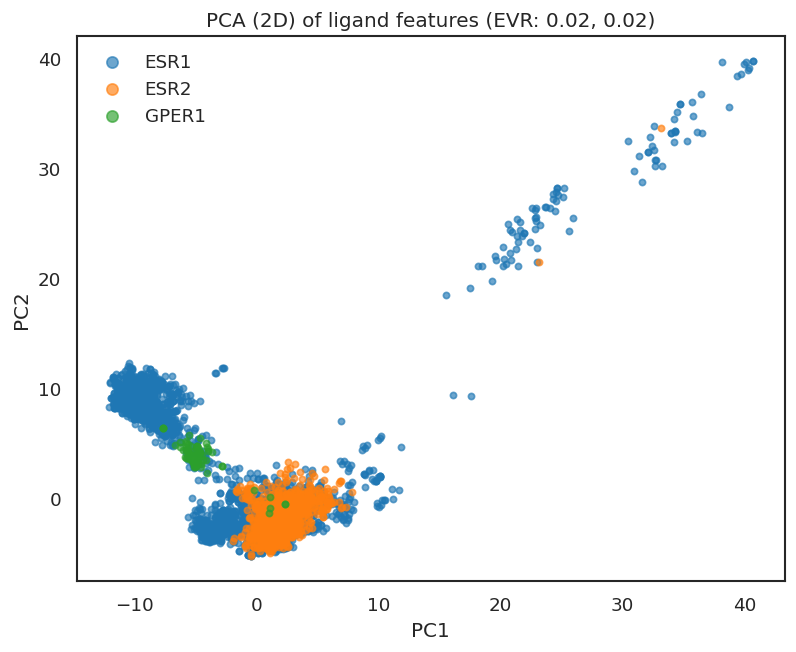

k-means silhouette score (k=3): 0.177
Saved: /media/xuchengjie/E7562A2674DB25F7/SRRSH/2025.6.14/BP/ER/Output/figures/cluster_composition.png


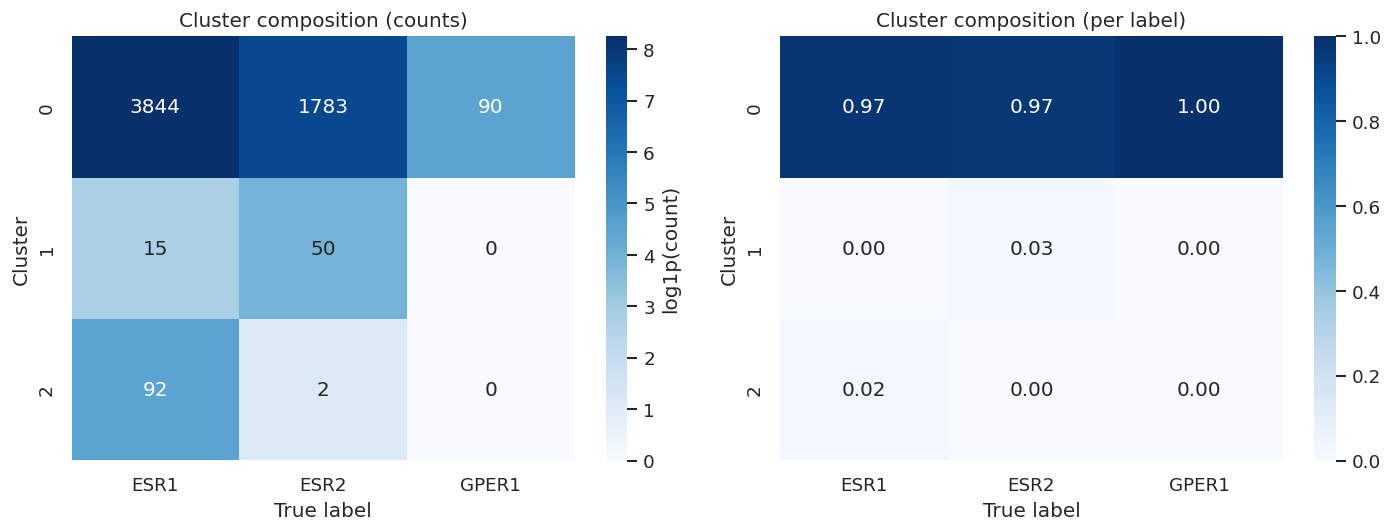

In [16]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Standardize without centering to keep efficiency on high-dimensional bits
scaler_pca = StandardScaler(with_mean=False)
X_scaled = scaler_pca.fit_transform(X)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
expl = pca.explained_variance_ratio_
print(f"PCA explained variance ratios: {expl}")

fig, ax = plt.subplots(figsize=(6.8, 5.6))
label_colors = {"ESR1": "#1f77b4", "ESR2": "#ff7f0e", "GPER1": "#2ca02c"}
for lbl in np.unique(y):
    mask = y == lbl
    ax.scatter(
        X_pca[mask, 0],
        X_pca[mask, 1],
        s=14,
        alpha=0.65,
        label=lbl,
        c=label_colors.get(lbl, None),
    )
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title(f"PCA (2D) of ligand features (EVR: {expl[0]:.2f}, {expl[1]:.2f})")
ax.legend(markerscale=1.8, frameon=False)
save_and_show_fig(fig, fig_path("pca_ligand_features.png"))

# k-means clustering (k=3)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)
sil = silhouette_score(X_scaled, clusters)
print(f"k-means silhouette score (k=3): {sil:.3f}")

ct = pd.crosstab(clusters, y)
ct_log = np.log1p(ct)
ct_col = ct.div(ct.sum(axis=0), axis=1).fillna(0.0)

fig, axes = plt.subplots(1, 2, figsize=(12, 4.6))
sns.heatmap(
    ct_log,
    annot=ct,
    fmt="d",
    cmap="Blues",
    ax=axes[0],
    cbar_kws={"label": "log1p(count)"},
)
axes[0].set_xlabel("True label")
axes[0].set_ylabel("Cluster")
axes[0].set_title("Cluster composition (counts)")

sns.heatmap(ct_col, annot=True, fmt=".2f", cmap="Blues", ax=axes[1])
axes[1].set_xlabel("True label")
axes[1].set_ylabel("Cluster")
axes[1].set_title("Cluster composition (per label)")

save_and_show_fig(fig, fig_path("cluster_composition.png"))


## Clustering visualization
- PCA scatter colored by k-means clusters (k=3)
- Cluster centers projected to PCA space
- Cluster size summary

Saved: /media/xuchengjie/E7562A2674DB25F7/SRRSH/2025.6.14/BP/ER/Output/figures/cluster_pca_and_sizes.png


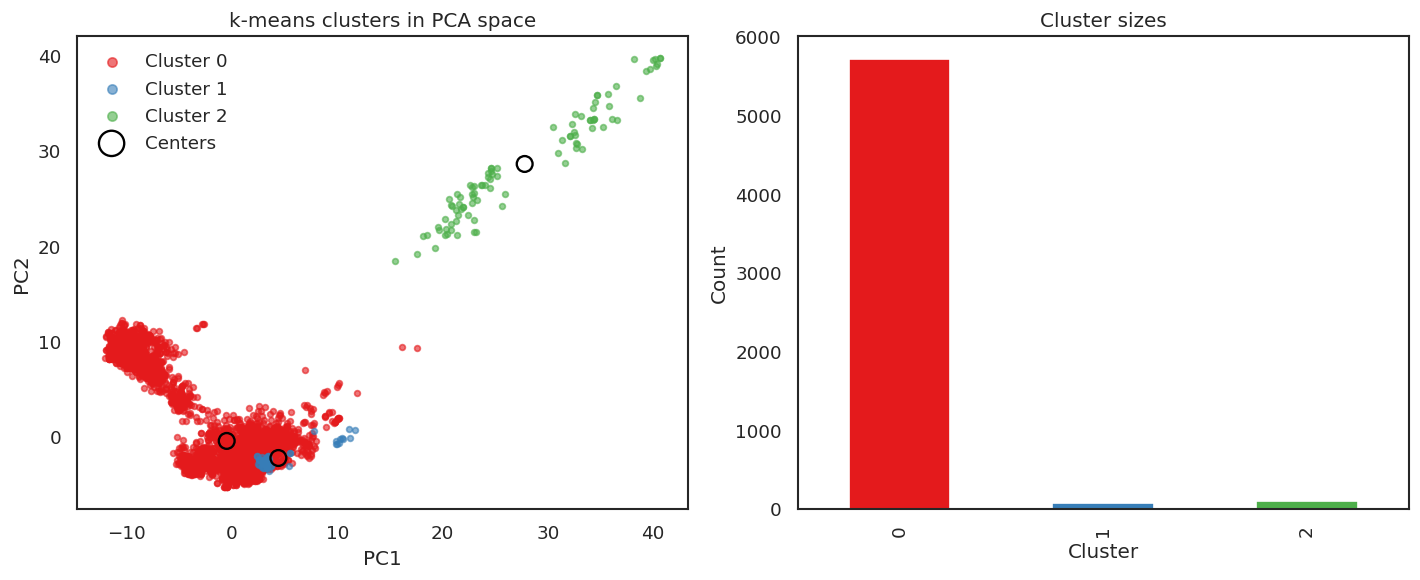

In [17]:
cluster_palette = sns.color_palette('Set1', n_colors=3)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# PCA scatter by cluster
for cid in sorted(np.unique(clusters)):
    mask = clusters == cid
    axes[0].scatter(
        X_pca[mask, 0],
        X_pca[mask, 1],
        s=12,
        alpha=0.6,
        color=cluster_palette[cid],
        label=f"Cluster {cid}",
    )
# project cluster centers into PCA space
center_pca = pca.transform(kmeans.cluster_centers_)
axes[0].scatter(
    center_pca[:, 0],
    center_pca[:, 1],
    s=90,
    facecolors='none',
    edgecolors='black',
    linewidths=1.4,
    label='Centers',
)
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].set_title('k-means clusters in PCA space')
axes[0].legend(markerscale=1.6, frameon=False)

# Cluster sizes bar plot
cluster_sizes = pd.Series(clusters).value_counts().sort_index()
cluster_sizes.plot.bar(color=cluster_palette, ax=axes[1])
axes[1].set_title('Cluster sizes')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Count')

save_and_show_fig(fig, fig_path("cluster_pca_and_sizes.png"))


## Target-wise clustering and representative structures
- For each target, run k-means on ligand features, show cluster sizes and representative structures (medoids).
- Representative picked as closest ligand to each cluster center in full feature space.


ESR1: k=6, silhouette=0.560
Saved: /media/xuchengjie/E7562A2674DB25F7/SRRSH/2025.6.14/BP/ER/Output/figures/cluster_sizes_ESR1.png


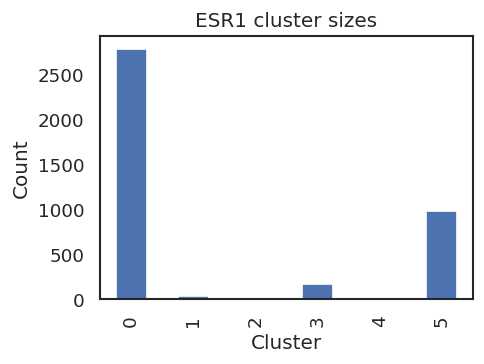

Saved: /media/xuchengjie/E7562A2674DB25F7/SRRSH/2025.6.14/BP/ER/Output/figures/cluster_medoids_ESR1.png


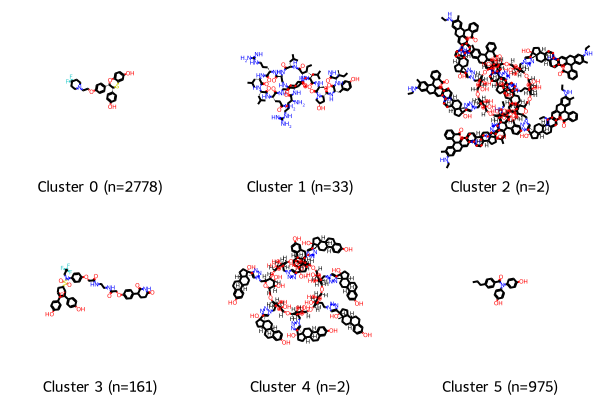

ESR2: k=6, silhouette=0.387
Saved: /media/xuchengjie/E7562A2674DB25F7/SRRSH/2025.6.14/BP/ER/Output/figures/cluster_sizes_ESR2.png


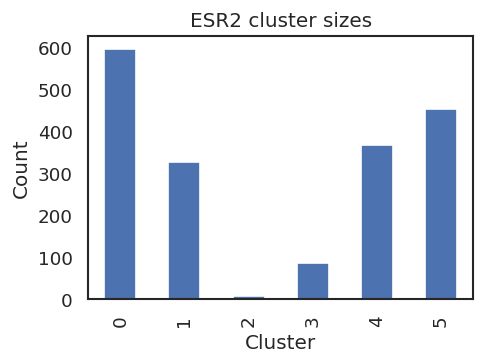

Saved: /media/xuchengjie/E7562A2674DB25F7/SRRSH/2025.6.14/BP/ER/Output/figures/cluster_medoids_ESR2.png


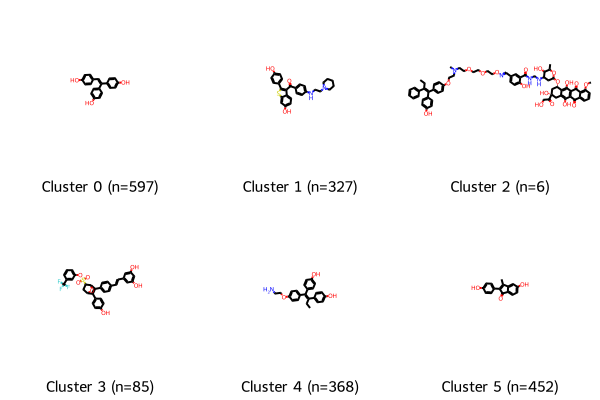

GPER1: k=6, silhouette=0.382
Saved: /media/xuchengjie/E7562A2674DB25F7/SRRSH/2025.6.14/BP/ER/Output/figures/cluster_sizes_GPER1.png


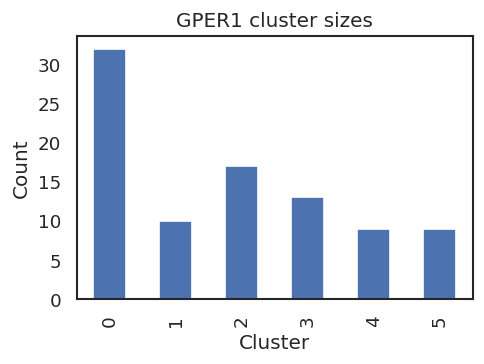

Saved: /media/xuchengjie/E7562A2674DB25F7/SRRSH/2025.6.14/BP/ER/Output/figures/cluster_medoids_GPER1.png


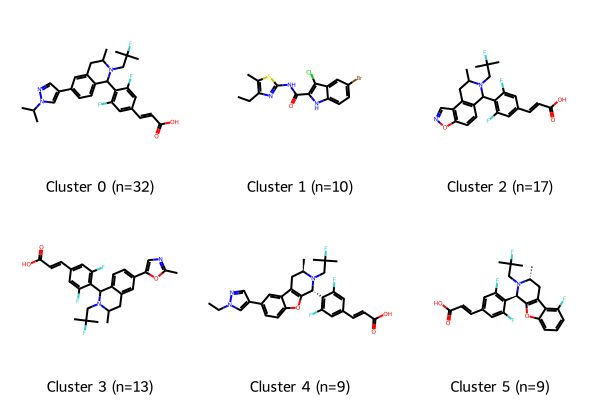

In [18]:
def cluster_and_show(target_label, n_clusters=6):
    idx = np.where(y == target_label)[0]
    if len(idx) < 2:
        print(f"Not enough samples for {target_label}")
        return
    n_clusters_use = min(n_clusters, len(idx))
    X_sub = X[idx]
    smi_sub = smiles_array[idx]
    km = KMeans(n_clusters=n_clusters_use, random_state=42, n_init=10)
    clusters = km.fit_predict(X_sub)
    # distances to centers to pick representative
    dists = km.transform(X_sub)
    reps = []
    for c in range(n_clusters_use):
        mask = clusters == c
        if not mask.any():
            continue
        size = mask.sum()
        local_idx = np.argmin(dists[mask, c])
        global_idx = idx[np.where(mask)[0][local_idx]]
        reps.append((c, size, smi_sub[mask][local_idx]))
    try:
        sil = silhouette_score(X_sub, clusters)
    except Exception:
        sil = float('nan')
    print(f"{target_label}: k={n_clusters_use}, silhouette={sil:.3f}")
    sizes = pd.Series(clusters).value_counts().sort_index()

    fig, ax = plt.subplots(figsize=(4.2, 3.2))
    sizes.plot.bar(color="#4c72b0", ax=ax)
    ax.set_title(f"{target_label} cluster sizes")
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Count")
    save_and_show_fig(fig, fig_path(f"cluster_sizes_{target_label}.png"))

    # representative structures
    mols, legends = [], []
    for c, size, smi in reps:
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            continue
        mols.append(mol)
        legends.append(f"Cluster {c} (n={size})")
    if mols:
        img = Draw.MolsToGridImage(mols, legends=legends, molsPerRow=3, subImgSize=(200, 200))
        save_and_show_img(img, fig_path(f"cluster_medoids_{target_label}.png"))
    else:
        print("No valid representative structures to draw.")

for lbl in ["ESR1", "ESR2", "GPER1"]:
    cluster_and_show(lbl, n_clusters=6)


## Scaffold-aware split helper


In [19]:
def resolve_group_splits(groups, desired: int = 5):
    unique_groups = len(np.unique(groups))
    usable = min(desired, unique_groups)
    if usable < 2:
        raise ValueError("Need at least two distinct scaffolds for GroupKFold.")
    return usable

group_splits = resolve_group_splits(scaffolds, desired=5)
print(f"Using {group_splits} folds for scaffold CV")


Using 5 folds for scaffold CV


## Quick kNN baseline (sanity check)


              precision    recall  f1-score   support

        ESR1       0.90      0.86      0.88       791
        ESR2       0.73      0.79      0.76       367
       GPER1       1.00      0.89      0.94        18

    accuracy                           0.84      1176
   macro avg       0.88      0.85      0.86      1176
weighted avg       0.85      0.84      0.84      1176

Saved: /media/xuchengjie/E7562A2674DB25F7/SRRSH/2025.6.14/BP/ER/Output/figures/knn_confusion.png


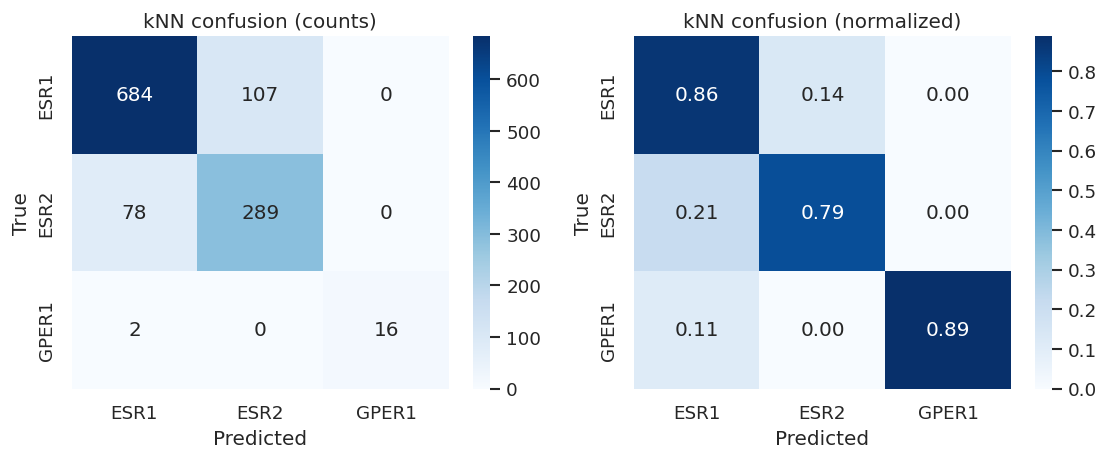

In [20]:
label_order = ["ESR1", "ESR2", "GPER1"]
min_class = pd.Series(y).value_counts().min()
use_stratify = min_class > 1

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y if use_stratify else None
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)

print(classification_report(y_test, y_pred, labels=label_order, zero_division=0))

cm_knn = confusion_matrix(y_test, y_pred, labels=label_order)
fig, axes = plt.subplots(1, 2, figsize=(9.5, 4))
plot_confusion_matrix(cm_knn, label_order, ax=axes[0], title="kNN confusion (counts)")
plot_confusion_matrix(cm_knn, label_order, ax=axes[1], title="kNN confusion (normalized)", normalize=True)
save_and_show_fig(fig, fig_path("knn_confusion.png"))


## Step1: ER (ESR1+ESR2) vs GPER1 (binary)
- Keep logic unchanged


In [21]:
y_step1 = np.where(y == "GPER1", 0, 1)  # 1 = ER, 0 = GPER1
label_map_step1 = {0: "GPER1", 1: "ER"}


In [22]:
def evaluate_step1(model, X_data, y_binary, groups, label_map, n_splits: int):
    gkf = GroupKFold(n_splits=n_splits)
    aucs, cms, reports = [], [], []
    oof_probs, oof_true, oof_pred, oof_idx = [], [], [], []
    for fold, (train_idx, test_idx) in enumerate(gkf.split(X_data, y_binary, groups)):
        m = clone(model)
        m.fit(X_data[train_idx], y_binary[train_idx])
        y_prob = m.predict_proba(X_data[test_idx])
        class_idx = {c: i for i, c in enumerate(m.classes_)}
        p_er = y_prob[:, class_idx.get(1, 0)]
        y_pred = m.predict(X_data[test_idx])

        auc = np.nan
        if len(np.unique(y_binary[test_idx])) > 1:
            auc = roc_auc_score(y_binary[test_idx], p_er)
        aucs.append(auc)

        report = classification_report(
            y_binary[test_idx],
            y_pred,
            labels=[0, 1],
            target_names=[label_map[0], label_map[1]],
            zero_division=0,
        )
        cm = confusion_matrix(y_binary[test_idx], y_pred, labels=[0, 1])
        cms.append(cm)
        reports.append(report)

        oof_probs.append(p_er)
        oof_true.append(y_binary[test_idx])
        oof_pred.append(y_pred)
        oof_idx.append(test_idx)

        print(f"Fold {fold + 1} classification report:\n{report}")
        print(f"Fold {fold + 1} confusion matrix:\n{cm}\n")
        if not np.isnan(auc):
            print(f"Fold {fold + 1} ROC-AUC: {auc:.3f}\n")
        else:
            print(f"Fold {fold + 1} ROC-AUC: not computed (single-class fold)\n")

    mean_auc = np.nanmean(aucs)
    print(f"Mean ROC-AUC across folds (ignoring NaN): {mean_auc:.3f}")
    return {
        "aucs": aucs,
        "cms": cms,
        "reports": reports,
        "oof": {
            "p_er": np.concatenate(oof_probs),
            "y_true": np.concatenate(oof_true),
            "y_pred": np.concatenate(oof_pred),
            "idx": np.concatenate(oof_idx),
        },
    }


log_reg_step1 = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(class_weight="balanced", max_iter=1000)),
    ]
)
rf_step1 = RandomForestClassifier(
    n_estimators=300, class_weight="balanced", n_jobs=-1, random_state=0
)

print("Logistic Regression (Step1)")
step1_lr_results = evaluate_step1(log_reg_step1, X, y_step1, scaffolds, label_map_step1, group_splits)
print("\nRandom Forest (Step1)")
step1_rf_results = evaluate_step1(rf_step1, X, y_step1, scaffolds, label_map_step1, group_splits)


Logistic Regression (Step1)
Fold 1 classification report:
              precision    recall  f1-score   support

       GPER1       0.60      0.80      0.69        15
          ER       1.00      0.99      1.00      1161

    accuracy                           0.99      1176
   macro avg       0.80      0.90      0.84      1176
weighted avg       0.99      0.99      0.99      1176

Fold 1 confusion matrix:
[[  12    3]
 [   8 1153]]

Fold 1 ROC-AUC: 0.936

Fold 2 classification report:
              precision    recall  f1-score   support

       GPER1       0.77      0.97      0.86        34
          ER       1.00      0.99      1.00      1141

    accuracy                           0.99      1175
   macro avg       0.88      0.98      0.93      1175
weighted avg       0.99      0.99      0.99      1175

Fold 2 confusion matrix:
[[  33    1]
 [  10 1131]]

Fold 2 ROC-AUC: 0.998

Fold 3 classification report:
              precision    recall  f1-score   support

       GPER1       1.

## Step2: ESR1 vs ESR2 (RF main, ESR2-biased weights)
- Evaluate RF with different class_weight settings
- Keep LR as reference (not main)


In [23]:
mask_er = np.isin(y, ["ESR1", "ESR2"])
mask_nonselective = np.isin(smiles_array, nonselective_erab_smiles)
if drop_nonselective_erab and mask_nonselective.any():
    print(f"Dropping non-selective ESR1/ESR2 SMILES from Step2: {mask_nonselective.sum()}")
else:
    print("Keeping all ESR1/ESR2 SMILES for Step2 (no non-selective drop).")
mask_keep = mask_er & (~mask_nonselective if drop_nonselective_erab else True)

X_er = X[mask_keep]
y_er = y[mask_keep]
scaffolds_er = scaffolds[mask_keep]
print(f"ER-only subset: {len(y_er)} ligands, {len(np.unique(scaffolds_er))} scaffolds")


Keeping all ESR1/ESR2 SMILES for Step2 (no non-selective drop).
ER-only subset: 5786 ligands, 2147 scaffolds


In [24]:
def evaluate_step2_rf(X_data, y_labels, groups, n_splits: int, class_weight):
    gkf = GroupKFold(n_splits=n_splits)
    cms, reports = [], []
    prob_list, true_list = [], []
    for fold, (train_idx, test_idx) in enumerate(gkf.split(X_data, y_labels, groups)):
        model = RandomForestClassifier(
            n_estimators=rf_estimators,
            class_weight=class_weight,
            n_jobs=-1,
            random_state=0,
        )
        model.fit(X_data[train_idx], y_labels[train_idx])
        y_pred = model.predict(X_data[test_idx])
        proba = model.predict_proba(X_data[test_idx])
        cls_idx = {c: i for i, c in enumerate(model.classes_)}
        proba_aligned = np.column_stack([proba[:, cls_idx["ESR1"]], proba[:, cls_idx["ESR2"]]])
        prob_list.append(proba_aligned)
        true_list.append(y_labels[test_idx])

        report = classification_report(
            y_labels[test_idx],
            y_pred,
            labels=["ESR1", "ESR2"],
            zero_division=0,
        )
        cm = confusion_matrix(y_labels[test_idx], y_pred, labels=["ESR1", "ESR2"])
        cms.append(cm)
        reports.append(report)

        print(f"Fold {fold + 1} classification report:\n{report}")
        print(f"Fold {fold + 1} confusion matrix:\n{cm}\n")

    combined_cm = np.sum(cms, axis=0)
    era_to_erb = combined_cm[0, 1]
    erb_to_era = combined_cm[1, 0]
    total_era = combined_cm[0].sum()
    total_erb = combined_cm[1].sum()
    print(
        f"Total ESR1→ESR2: {era_to_erb}/{total_era} = {(era_to_erb/total_era) if total_era else np.nan:.3f}"
    )
    print(
        f"Total ESR2→ESR1: {erb_to_era}/{total_erb} = {(erb_to_era/total_erb) if total_erb else np.nan:.3f}"
    )
    probs_all = np.vstack(prob_list)
    true_all = np.concatenate(true_list)
    return {
        "cms": cms,
        "reports": reports,
        "combined_cm": combined_cm,
        "probs": probs_all,
        "y_true": true_all,
        "classes": ["ESR1", "ESR2"],
    }


def evaluate_step2_lr(X_data, y_labels, groups, n_splits: int):
    gkf = GroupKFold(n_splits=n_splits)
    cms, reports = [], []
    for fold, (train_idx, test_idx) in enumerate(gkf.split(X_data, y_labels, groups)):
        model = Pipeline(
            [
                ("scaler", StandardScaler()),
                (
                    "clf",
                    LogisticRegression(class_weight="balanced", max_iter=1000),
                ),
            ]
        )
        model.fit(X_data[train_idx], y_labels[train_idx])
        y_pred = model.predict(X_data[test_idx])
        report = classification_report(
            y_labels[test_idx],
            y_pred,
            labels=["ESR1", "ESR2"],
            zero_division=0,
        )
        cm = confusion_matrix(y_labels[test_idx], y_pred, labels=["ESR1", "ESR2"])
        cms.append(cm)
        reports.append(report)
        print(f"Fold {fold + 1} (LR) classification report:\n{report}")
        print(f"Fold {fold + 1} confusion matrix:\n{cm}\n")
    combined_cm = np.sum(cms, axis=0)
    return {"cms": cms, "reports": reports, "combined_cm": combined_cm}


rf_results = []
for cw in rf_weights_list:
    print(f"\nRandom Forest with class_weight={cw}")
    res = evaluate_step2_rf(
        X_er,
        y_er,
        scaffolds_er,
        resolve_group_splits(scaffolds_er, 5),
        class_weight=cw,
    )
    rf_results.append((cw, res))

print("\nLogistic Regression reference (not main model)")
step2_lr_results = evaluate_step2_lr(X_er, y_er, scaffolds_er, resolve_group_splits(scaffolds_er, 5))



Random Forest with class_weight={'ESR1': 1.0, 'ESR2': 2.0}
Fold 1 classification report:
              precision    recall  f1-score   support

        ESR1       0.90      0.90      0.90       832
        ESR2       0.74      0.75      0.74       326

    accuracy                           0.85      1158
   macro avg       0.82      0.82      0.82      1158
weighted avg       0.86      0.85      0.86      1158

Fold 1 confusion matrix:
[[747  85]
 [ 83 243]]

Fold 2 classification report:
              precision    recall  f1-score   support

        ESR1       0.88      0.87      0.87       750
        ESR2       0.76      0.79      0.78       407

    accuracy                           0.84      1157
   macro avg       0.82      0.83      0.83      1157
weighted avg       0.84      0.84      0.84      1157

Fold 2 confusion matrix:
[[650 100]
 [ 86 321]]

Fold 3 classification report:
              precision    recall  f1-score   support

        ESR1       0.88      0.89      0.88

## Threshold sweep on P(ESR2)
- Recommended working range: threshold_step2 in [0.40, 0.50]; 0.45–0.50 usually balances precision/recall (highest F1), 0.40 biases toward catching more ESR2.
- Curves below are computed on scaffold OOF predictions of the baseline RF (first class_weight entry).


Representative thresholds (OOF, scaffold CV):
Empty DataFrame
Columns: [threshold, precision_ESR2, recall_ESR2, f1_ESR2, support_ESR2]
Index: []
Saved: /media/xuchengjie/E7562A2674DB25F7/SRRSH/2025.6.14/BP/ER/Output/figures/step2_threshold_sweep.png


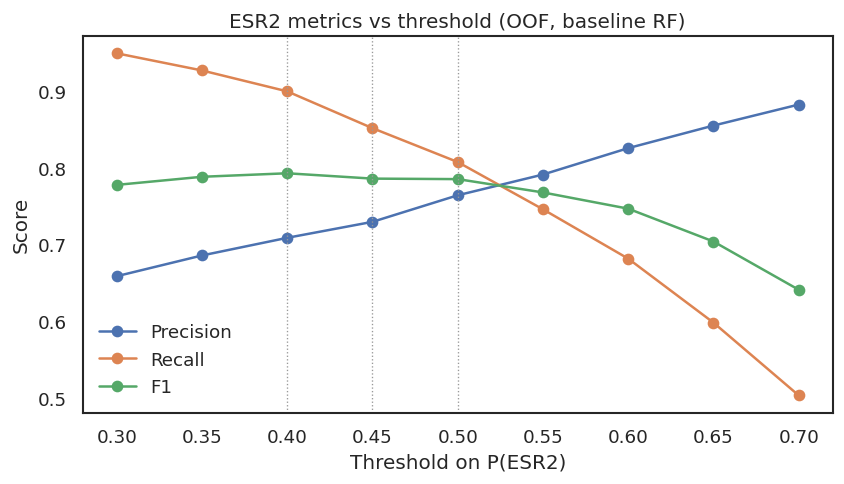

In [25]:
baseline_cw, baseline_res = rf_results[0]
probs = baseline_res["probs"]  # aligned columns: [ESR1, ESR2]
y_true = baseline_res["y_true"]
p_era = probs[:, 0]
p_erb = probs[:, 1]

rows = []
for t in threshold_grid:
    y_pred = np.where(p_erb >= t, "ESR2", "ESR1")
    prec, rec, f1, support = precision_recall_fscore_support(
        y_true, y_pred, labels=["ESR2"], zero_division=0
    )
    rows.append({
        "threshold": t,
        "precision_ESR2": prec[0],
        "recall_ESR2": rec[0],
        "f1_ESR2": f1[0],
        "support_ESR2": support[0],
    })

table_thresh = pd.DataFrame(rows)
print("Representative thresholds (OOF, scaffold CV):")
print(table_thresh[table_thresh["threshold"].isin(repr_thresholds)])

fig, ax = plt.subplots(figsize=(7.2, 4.2))
ax.plot(table_thresh["threshold"], table_thresh["precision_ESR2"], marker="o", label="Precision")
ax.plot(table_thresh["threshold"], table_thresh["recall_ESR2"], marker="o", label="Recall")
ax.plot(table_thresh["threshold"], table_thresh["f1_ESR2"], marker="o", label="F1")
for t in repr_thresholds:
    ax.axvline(t, color="#999999", linestyle=":", linewidth=0.8)
ax.set_title("ESR2 metrics vs threshold (OOF, baseline RF)")
ax.set_xlabel("Threshold on P(ESR2)")
ax.set_ylabel("Score")
ax.legend(frameon=False)
save_and_show_fig(fig, fig_path("step2_threshold_sweep.png"))


## High-confidence subset evaluation (Step2)
- Define confidence by max(P(ESR1), P(ESR2)) >= threshold_step2
- Report ESR2 metrics on confident subset and unknown rate


In [26]:
# Evaluate OOF predictions with chosen threshold and unknown band (symmetric max-prob cutoff)
threshold_step2_eval = 0.45  # try 0.45 or 0.50
unknown_band = unknown_band_default  # Unknown if max(P_ESR1, P_ESR2) < this

probs = baseline_res["probs"]  # columns [ESR1, ESR2]
y_true = baseline_res["y_true"]
p_era = probs[:, 0]
p_erb = probs[:, 1]

pred_labels = []
for pa, pb in zip(p_era, p_erb):
    p_max = max(pa, pb)
    if p_max < unknown_band:
        pred_labels.append("ESR1/ESR2_Unknown")
    elif (pb >= threshold_step2_eval) and (pb >= pa):
        pred_labels.append("ESR2")
    elif (pa >= threshold_step2_eval) and (pa > pb):
        pred_labels.append("ESR1")
    else:
        pred_labels.append("ESR1/ESR2_Unknown")

y_pred = np.array(pred_labels)
unknown_mask = y_pred == "ESR1/ESR2_Unknown"
conf_mask = ~unknown_mask

# Overall ESR2 metrics (Unknown treated as not-ESR2)
prec_all, rec_all, f1_all, _ = precision_recall_fscore_support(
    y_true, y_pred, labels=["ESR2"], zero_division=0
)
print(
    f"Overall ESR2 metrics @ threshold={threshold_step2_eval}, unknown_band={unknown_band}: "
    f"precision={prec_all[0]:.3f}, recall={rec_all[0]:.3f}, f1={f1_all[0]:.3f}"
)
print(f"Unknown proportion: {unknown_mask.mean():.2%} ({unknown_mask.sum()}/{len(y_pred)})")

# Confident subset metrics
if conf_mask.any():
    y_pred_conf = y_pred[conf_mask]
    y_true_conf = y_true[conf_mask]
    prec_conf, rec_conf, f1_conf, _ = precision_recall_fscore_support(
        y_true_conf, y_pred_conf, labels=["ESR2"], zero_division=0
    )
    print(
        f"Confident subset ESR2 metrics: precision={prec_conf[0]:.3f}, "
        f"recall={rec_conf[0]:.3f}, f1={f1_conf[0]:.3f}"
    )
else:
    print("No confident samples with current thresholds; lower unknown_band or threshold_step2_eval.")


Overall ESR2 metrics @ threshold=0.45, unknown_band=0.55: precision=0.791, recall=0.746, f1=0.768
Unknown proportion: 7.02% (406/5786)
Confident subset ESR2 metrics: precision=0.791, recall=0.833, f1=0.812


## Visual summaries (OOF)
- Class counts
- Step1 and Step2 confusion matrices (scaffold OOF)
- ESR2 probability distribution

Saved: /media/xuchengjie/E7562A2674DB25F7/SRRSH/2025.6.14/BP/ER/Output/figures/oof_class_counts_and_esr2_prob.png


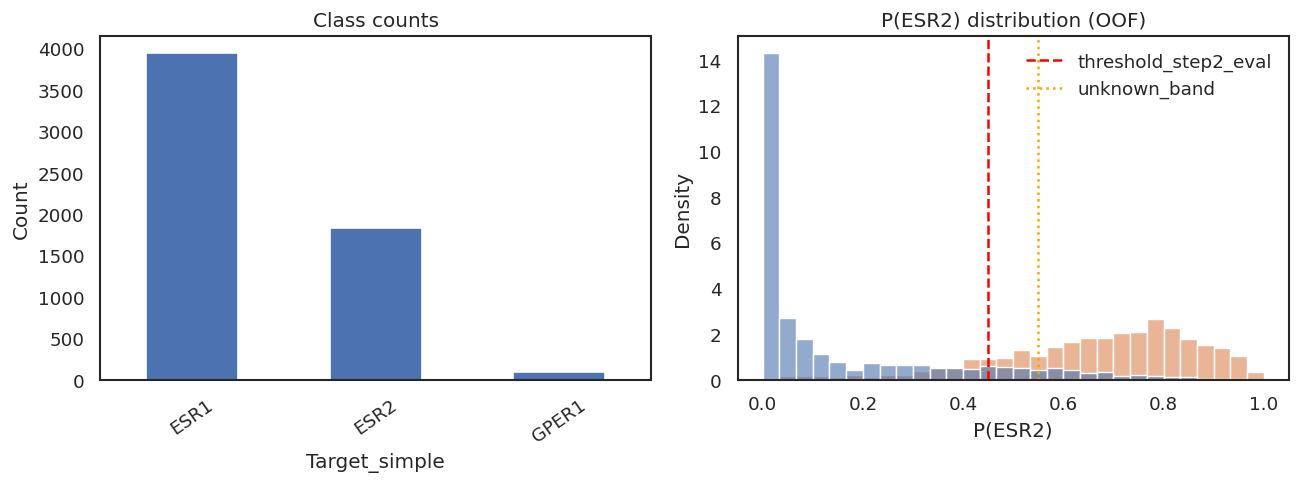

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(11, 4.2))

# Class counts
class_counts = df_main["Target_simple"].value_counts().reindex(["ESR1", "ESR2", "GPER1"])
class_counts.plot.bar(ax=axes[0], color="#4c72b0")
axes[0].set_title("Class counts")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis="x", rotation=35)

# ESR2 probability histogram (baseline RF OOF)
p_erb = baseline_res["probs"][:, 1]
prob_df = pd.DataFrame({"P(ESR2)": p_erb, "True": baseline_res["y_true"]})
sns.histplot(
    data=prob_df,
    x="P(ESR2)",
    hue="True",
    bins=30,
    stat="density",
    common_norm=False,
    alpha=0.6,
    ax=axes[1],
)
axes[1].axvline(threshold_step2_eval, color="red", linestyle="--", label="threshold_step2_eval")
axes[1].axvline(unknown_band, color="orange", linestyle=":", label="unknown_band")
axes[1].set_title("P(ESR2) distribution (OOF)")
axes[1].set_xlabel("P(ESR2)")
axes[1].legend(frameon=False)

save_and_show_fig(fig, fig_path("oof_class_counts_and_esr2_prob.png"))


Saved: /media/xuchengjie/E7562A2674DB25F7/SRRSH/2025.6.14/BP/ER/Output/figures/oof_confusion_step1_step2.png


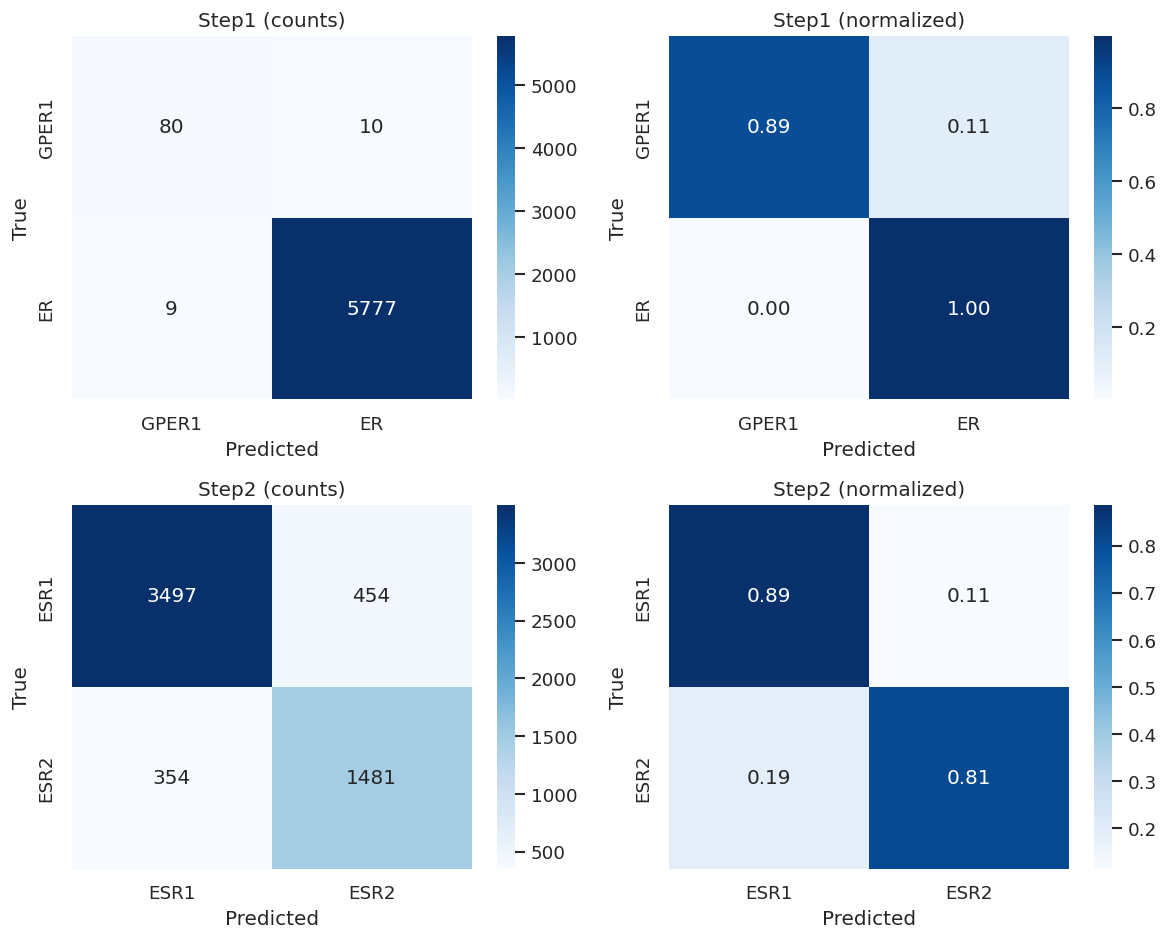

In [28]:
# Step1 and Step2 confusion matrices (counts + normalized)
cm_step1 = np.sum(step1_rf_results.get("cms", []), axis=0)
cm_step2 = baseline_res.get("combined_cm")

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
plot_confusion_matrix(cm_step1, ["GPER1", "ER"], ax=axes[0, 0], title="Step1 (counts)")
plot_confusion_matrix(cm_step1, ["GPER1", "ER"], ax=axes[0, 1], title="Step1 (normalized)", normalize=True)
plot_confusion_matrix(cm_step2, ["ESR1", "ESR2"], ax=axes[1, 0], title="Step2 (counts)")
plot_confusion_matrix(cm_step2, ["ESR1", "ESR2"], ax=axes[1, 1], title="Step2 (normalized)", normalize=True)

save_and_show_fig(fig, fig_path("oof_confusion_step1_step2.png"))


## ROC/PR curves (OOF) for Step1 & Step2


Saved: /media/xuchengjie/E7562A2674DB25F7/SRRSH/2025.6.14/BP/ER/Output/figures/oof_step1_step2_roc_pr.png


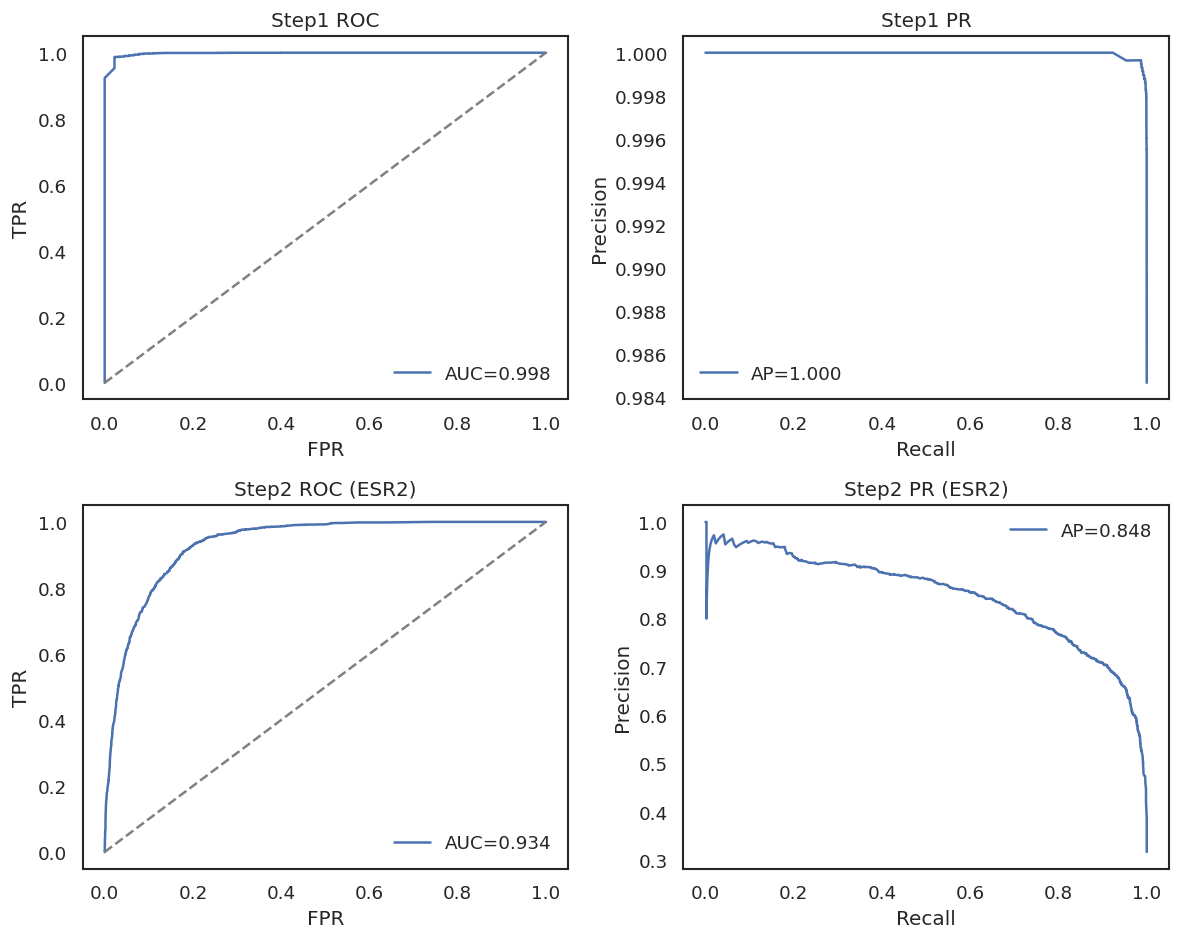

In [29]:
# Step1 ROC/PR (ER vs GPER1)
step1_oof = step1_rf_results.get("oof", {})
if step1_oof:
    y_true_s1 = step1_oof["y_true"]
    p_er = step1_oof["p_er"]
    fpr, tpr, _ = roc_curve(y_true_s1, p_er)
    prec, rec, _ = precision_recall_curve(y_true_s1, p_er)
    auc_s1 = roc_auc_score(y_true_s1, p_er)
    ap_s1 = average_precision_score(y_true_s1, p_er)

    # Step2 ROC/PR (ESR2 positive)
    y_true_s2 = (baseline_res["y_true"] == "ESR2").astype(int)
    p_erb = baseline_res["probs"][:, 1]
    fpr2, tpr2, _ = roc_curve(y_true_s2, p_erb)
    prec2, rec2, _ = precision_recall_curve(y_true_s2, p_erb)
    auc_s2 = roc_auc_score(y_true_s2, p_erb)
    ap_s2 = average_precision_score(y_true_s2, p_erb)

    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes[0, 0].plot(fpr, tpr, label=f"AUC={auc_s1:.3f}")
    axes[0, 0].plot([0, 1], [0, 1], linestyle="--", color="gray")
    axes[0, 0].set_title("Step1 ROC")
    axes[0, 0].set_xlabel("FPR")
    axes[0, 0].set_ylabel("TPR")
    axes[0, 0].legend(frameon=False)

    axes[0, 1].plot(rec, prec, label=f"AP={ap_s1:.3f}")
    axes[0, 1].set_title("Step1 PR")
    axes[0, 1].set_xlabel("Recall")
    axes[0, 1].set_ylabel("Precision")
    axes[0, 1].legend(frameon=False)

    axes[1, 0].plot(fpr2, tpr2, label=f"AUC={auc_s2:.3f}")
    axes[1, 0].plot([0, 1], [0, 1], linestyle="--", color="gray")
    axes[1, 0].set_title("Step2 ROC (ESR2)")
    axes[1, 0].set_xlabel("FPR")
    axes[1, 0].set_ylabel("TPR")
    axes[1, 0].legend(frameon=False)

    axes[1, 1].plot(rec2, prec2, label=f"AP={ap_s2:.3f}")
    axes[1, 1].set_title("Step2 PR (ESR2)")
    axes[1, 1].set_xlabel("Recall")
    axes[1, 1].set_ylabel("Precision")
    axes[1, 1].legend(frameon=False)

    save_and_show_fig(fig, fig_path("oof_step1_step2_roc_pr.png"))
else:
    print("Step1 OOF data missing; run Step1 evaluation first.")


## Two-step scaffold OOF confusion (ESR1 / ESR2 / GPER1)
- Uses scaffold GroupKFold OOF predictions with two-step RF (Step1 RF balanced; Step2 RF with ESR2-biased class_weight).
- Provides 3-class confusion matrix and classification report (no Unknown applied here).

Classification report (three-class OOF, two-step RF):
              precision    recall  f1-score   support

        ESR1       0.91      0.88      0.90      3951
        ESR2       0.77      0.81      0.79      1835
       GPER1       0.90      0.89      0.89        90

    accuracy                           0.86      5876
   macro avg       0.86      0.86      0.86      5876
weighted avg       0.86      0.86      0.86      5876

Saved: /media/xuchengjie/E7562A2674DB25F7/SRRSH/2025.6.14/BP/ER/Output/figures/two_step_oof_confusion_counts.png


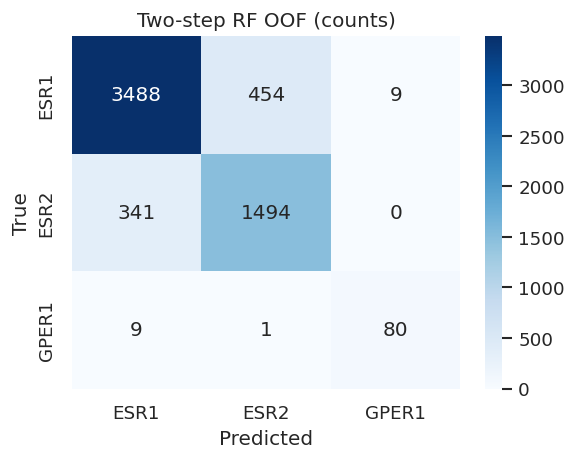

Saved: /media/xuchengjie/E7562A2674DB25F7/SRRSH/2025.6.14/BP/ER/Output/figures/two_step_oof_confusion_normalized.png


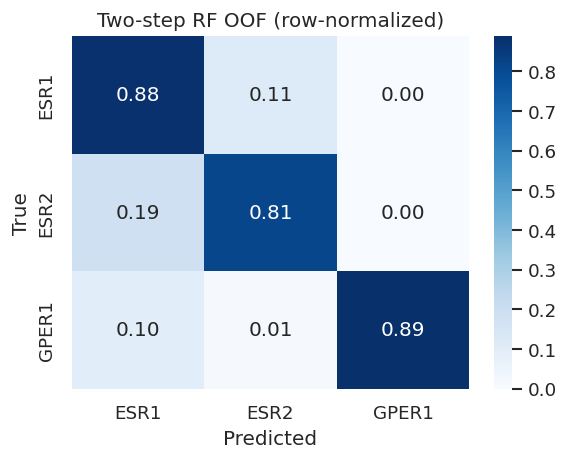

In [30]:
def two_step_oof_confusion(threshold_step1=0.5):
    gkf = GroupKFold(n_splits=group_splits)
    y_true_all, y_pred_all, idx_all = [], [], []
    for train_idx, test_idx in gkf.split(X, y, scaffolds):
        # Step1 RF
        step1 = RandomForestClassifier(
            n_estimators=rf_estimators,
            class_weight="balanced",
            n_jobs=-1,
            random_state=0,
        )
        step1.fit(X[train_idx], y_step1[train_idx])
        proba1 = step1.predict_proba(X[test_idx])
        cls_map1 = {c: i for i, c in enumerate(step1.classes_)}
        p_gper1 = proba1[:, cls_map1.get(0, 0)]
        p_er = proba1[:, cls_map1.get(1, 1)]

        # Step2 RF trained on ER-only samples from training fold
        mask_train_er = mask_keep[train_idx]
        X_er_train = X[train_idx][mask_train_er]
        y_er_train = y[train_idx][mask_train_er]
        if len(np.unique(y_er_train)) < 2:
            majority_label = y_er_train[0]
            step2 = None
        else:
            step2 = RandomForestClassifier(
                n_estimators=rf_estimators,
                class_weight=rf_weights_list[0],
                n_jobs=-1,
                random_state=0,
            )
            step2.fit(X_er_train, y_er_train)

        for local_i, global_i in enumerate(test_idx):
            idx_all.append(global_i)
            y_true_all.append(y[global_i])
            if max(p_gper1[local_i], p_er[local_i]) < threshold_step1:
                go_er = True
            else:
                go_er = p_er[local_i] >= p_gper1[local_i]
            if not go_er:
                y_pred_all.append("GPER1")
            else:
                if step2 is None:
                    y_pred_all.append(majority_label)
                else:
                    pred2 = step2.predict(X[global_i].reshape(1, -1))[0]
                    y_pred_all.append(pred2)
    return np.array(y_true_all), np.array(y_pred_all), np.array(idx_all)


y_true_oof, y_pred_oof, idx_oof = two_step_oof_confusion(threshold_step1=0.5)
label_full = ["ESR1", "ESR2", "GPER1"]
print("Classification report (three-class OOF, two-step RF):")
print(classification_report(y_true_oof, y_pred_oof, labels=label_full, zero_division=0))

cm_full = confusion_matrix(y_true_oof, y_pred_oof, labels=label_full)
fig, ax = plt.subplots(figsize=(5, 4))
plot_confusion_matrix(cm_full, label_full, ax=ax, title="Two-step RF OOF (counts)")
save_and_show_fig(fig, fig_path("two_step_oof_confusion_counts.png"))

cm_full_norm = cm_full.astype(float)
row_sums = cm_full_norm.sum(axis=1, keepdims=True)
cm_full_norm = np.divide(cm_full_norm, row_sums, out=np.zeros_like(cm_full_norm), where=row_sums != 0)
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(pd.DataFrame(cm_full_norm, index=label_full, columns=label_full), annot=True, fmt=".2f", cmap="Blues", ax=ax)
ax.set_title("Two-step RF OOF (row-normalized)")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
save_and_show_fig(fig, fig_path("two_step_oof_confusion_normalized.png"))


## Treat ESR1↔ESR2 cross-binders as dual-binding class and retrain Step2
- Define dual class from OOF off-diagonal (ESR1→ESR2 and ESR2→ESR1)
- Retrain Step2 as 3-class (ESR1 / ESR2 / ESR1_ESR2) with scaffold GroupKFold
- Show confusion matrix and report


Cross-binders marked dual: 795
ESR1    3497
ESR2    1494
Name: count, dtype: int64
Fold 1 classification report:
              precision    recall  f1-score   support

        ESR1       0.97      0.98      0.98       730
        ESR2       0.96      0.92      0.94       269
   ESR1_ESR2       0.00      0.00      0.00         0

    accuracy                           0.97       999
   macro avg       0.64      0.63      0.64       999
weighted avg       0.97      0.97      0.97       999

Fold 1 confusion matrix:
[[719  11   0]
 [ 22 247   0]
 [  0   0   0]]

Fold 2 classification report:
              precision    recall  f1-score   support

        ESR1       0.98      0.96      0.97       736
        ESR2       0.90      0.95      0.93       262
   ESR1_ESR2       0.00      0.00      0.00         0

    accuracy                           0.96       998
   macro avg       0.63      0.64      0.63       998
weighted avg       0.96      0.96      0.96       998

Fold 2 confusion matrix

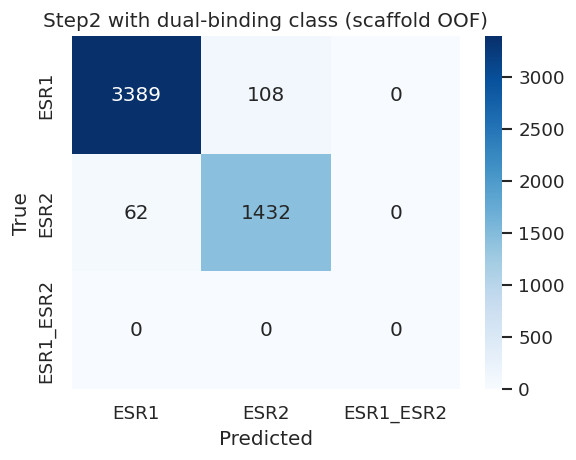

In [31]:
# Identify cross-binders from OOF
cross_mask = ((y_true_oof == "ESR1") & (y_pred_oof == "ESR2")) | ((y_true_oof == "ESR2") & (y_pred_oof == "ESR1"))
cross_indices = idx_oof[cross_mask]
print(f"Cross-binders marked dual: {len(cross_indices)}")

# Build new labels with dual class
y_dual = y.copy()
y_dual[cross_indices] = "ESR1_ESR2"

# Step2 data using dual labels and existing ER mask (after non-selective drop)
mask_er_dual = np.isin(y_dual, ["ESR1", "ESR2", "ESR1_ESR2"]) & mask_keep
X_dual = X[mask_er_dual]
y_dual_labels = y_dual[mask_er_dual]
scaffolds_dual = scaffolds[mask_er_dual]
print(pd.Series(y_dual_labels).value_counts())

cw_dual = {"ESR1": 1.0, "ESR2": 2.0, "ESR1_ESR2": 1.5}

gkf = GroupKFold(n_splits=resolve_group_splits(scaffolds_dual, 5))
cm_list = []
reports = []
for fold, (tr, te) in enumerate(gkf.split(X_dual, y_dual_labels, scaffolds_dual)):
    model = RandomForestClassifier(
        n_estimators=rf_estimators,
        class_weight=cw_dual,
        n_jobs=-1,
        random_state=0,
    )
    model.fit(X_dual[tr], y_dual_labels[tr])
    pred = model.predict(X_dual[te])
    rpt = classification_report(
        y_dual_labels[te],
        pred,
        labels=["ESR1", "ESR2", "ESR1_ESR2"],
        zero_division=0,
    )
    cm = confusion_matrix(
        y_dual_labels[te],
        pred,
        labels=["ESR1", "ESR2", "ESR1_ESR2"],
    )
    reports.append(rpt)
    cm_list.append(cm)
    print(f"Fold {fold+1} classification report:\n{rpt}")
    print(f"Fold {fold+1} confusion matrix:\n{cm}\n")

cm_dual = np.sum(cm_list, axis=0)
fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(
    pd.DataFrame(cm_dual, index=["ESR1","ESR2","ESR1_ESR2"], columns=["ESR1","ESR2","ESR1_ESR2"]),
    annot=True,
    fmt='d',
    cmap='Blues',
    ax=ax,
)
ax.set_title("Step2 with dual-binding class (scaffold OOF)")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
plt.tight_layout()


## Train final models
- Step1: Logistic Regression (balanced)
- Step2: Random Forest with ESR2-biased weights (choose preferred weight)


In [32]:
best_class_weight = rf_weights_list[0]  # adjust after reviewing RF runs + thresholds

model_step1 = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(class_weight="balanced", max_iter=1000)),
    ]
)
model_step1.fit(X, y_step1)

model_step2 = RandomForestClassifier(
    n_estimators=rf_estimators,
    class_weight=best_class_weight,
    n_jobs=-1,
    random_state=0,
)
model_step2.fit(X_er, y_er)

print("Final models trained.")


Final models trained.


## Uncertainty-aware prediction helper
- Returns ESR1 / ESR2 / GPER1 / Unknown with probabilities


In [33]:
def predict_target_for_smiles_with_uncertainty(
    smiles_list,
    model_step1,
    model_step2,
    threshold_step1: float = 0.5,
    threshold_step2: float = threshold_step2_default,
    unknown_band: float = unknown_band_default,
    use_maccs_features: bool = None,
):
    records = []
    if use_maccs_features is None:
        use_maccs_features = use_maccs
    for smi in smiles_list:
        feat, scaf = build_feature_vector(smi, use_maccs=use_maccs_features)
        if feat is None:
            records.append(
                {
                    "SMILES": smi,
                    "Predicted_target": "Invalid SMILES",
                    "P_ESR1": np.nan,
                    "P_ESR2": np.nan,
                    "P_GPER1": np.nan,
                    "P_ER_vs_GPER": np.nan,
                    "Unknown_flag": True,
                }
            )
            continue
        x_input = feat.reshape(1, -1)
        # Step1
        proba1 = model_step1.predict_proba(x_input)[0]
        prob_map1 = {cls: p for cls, p in zip(model_step1.classes_, proba1)}
        p_gper1 = prob_map1.get(0, prob_map1.get("GPER1", 0.0))
        p_er = prob_map1.get(1, prob_map1.get("ER", 0.0))
        if max(p_gper1, p_er) < threshold_step1:
            records.append(
                {
                    "SMILES": smi,
                    "Predicted_target": "ER/GPER1_Unknown",
                    "P_ESR1": np.nan,
                    "P_ESR2": np.nan,
                    "P_GPER1": p_gper1,
                    "P_ER_vs_GPER": p_er,
                    "Unknown_flag": True,
                }
            )
            continue
        if p_gper1 >= p_er:
            records.append(
                {
                    "SMILES": smi,
                    "Predicted_target": "GPER1",
                    "P_ESR1": np.nan,
                    "P_ESR2": np.nan,
                    "P_GPER1": p_gper1,
                    "P_ER_vs_GPER": p_er,
                    "Unknown_flag": False,
                }
            )
            continue
        # Step2
        proba2 = model_step2.predict_proba(x_input)[0]
        cls_idx = {c: i for i, c in enumerate(model_step2.classes_)}
        p_era = proba2[cls_idx["ESR1"]]
        p_erb = proba2[cls_idx["ESR2"]]
        p_max = max(p_era, p_erb)
        if p_max < unknown_band:
            pred_label = "ESR1/ESR2_Unknown"
            unknown = True
        elif (p_erb >= threshold_step2) and (p_erb >= p_era):
            pred_label = "ESR2"
            unknown = False
        elif (p_era >= threshold_step2) and (p_era > p_erb):
            pred_label = "ESR1"
            unknown = False
        else:
            pred_label = "ESR1/ESR2_Unknown"
            unknown = True
        records.append(
            {
                "SMILES": smi,
                "Predicted_target": pred_label,
                "P_ESR1": p_era,
                "P_ESR2": p_erb,
                "P_GPER1": p_gper1,
                "P_ER_vs_GPER": p_er,
                "Unknown_flag": unknown,
            }
        )
    return pd.DataFrame(records)


example_smiles = df_main["SMILES"].head(5).tolist()
predict_target_for_smiles_with_uncertainty(
    example_smiles,
    model_step1,
    model_step2,
    threshold_step1=0.5,
    threshold_step2=threshold_step2_default,
    unknown_band=unknown_band_default,
    use_maccs_features=use_maccs,
)


,SMILES,Predicted_target,P_ESR1,P_ESR2,P_GPER1,P_ER_vs_GPER,Unknown_flag
0,Oc1ccc(cc1)-c1sc2cccc(O)c2c1C(=O)c1ccc(OCCN2CC...,ESR1,0.636667,0.363333,2.987204e-04,0.999701,False
1,C[C@]12CC[C@H]3[C@@H](CCc4cc(O)ccc34)[C@@H]1CC...,ESR1,0.991111,0.008889,1.878764e-05,0.999981,False
2,CC\C(=C(\CC)c1ccc(O)cc1)c1ccc(O)cc1,ESR2,0.429958,0.570042,8.788697e-06,0.999991,False
3,Oc1cccc(c1)C1=C(Cl)c2cc(O)ccc2O[C@H]1c1ccc(OCC...,ESR1,1.000000,0.000000,5.227009e-07,0.999999,False
4,C[C@@H]1Cc2c([nH]c3ccccc23)[C@@H](c2c(F)cc(OCC...,ESR1,1.000000,0.000000,2.620915e-08,1.000000,False


### Notes
- Step2 main model: Random Forest with ESR2-biased class_weight; recommended threshold_step2 range 0.40–0.50 (0.45–0.50 typically balances precision/recall; 0.40 favors higher ESR2 recall). Unknown band default: max(P) < 0.55.
- Threshold scan + Unknown handling are computed on OOF (GroupKFold) predictions to avoid leakage. Adjust threshold_step2_eval and unknown_band in the OOF cells to select your operating point.
- Optional MACCS features via `use_maccs`; non-selective ESR1/ESR2 SMILES can be dropped via `drop_nonselective_erab`.
- Deploy with `predict_target_for_smiles_with_uncertainty`, keeping thresholds consistent with chosen operating point.

- Optional: mark ESR1↔ESR2 cross-binders (OOF off-diagonal) as dual class `ESR1_ESR2` and retrain Step2 as 3-class.

In [34]:
# Save two-step models for downstream use
import joblib

TARGET_TWO_STEP_PATH = OUTPUT_ROOT / 'target_two_step.joblib'
meta = {
    'threshold_step1': 0.5,
    'threshold_step2': threshold_step2_default,
    'unknown_band': unknown_band_default,
    'use_maccs': use_maccs,
    'rf_class_weight': best_class_weight,
    'labels': ['ESR1', 'ESR2', 'GPER1']
}
joblib.dump({
    'model_step1': model_step1,
    'model_step2': model_step2,
    'meta': meta
}, TARGET_TWO_STEP_PATH)
log({'two_step_model_saved': str(TARGET_TWO_STEP_PATH)})


[2026-01-09T09:08:40.580605] {'two_step_model_saved': '/media/xuchengjie/E7562A2674DB25F7/SRRSH/2025.6.14/BP/ER/Output/target_two_step.joblib'}


In [35]:
# Predict Structures/*.sdf with the two-step classifier
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
import joblib
import pandas as pd

PRED_STRUCT_PATH = RUN_DIR / 'predictions_structures.csv'
TWO_STEP_PATH = OUTPUT_ROOT / 'target_two_step.joblib'

def sdf_first_smiles(path):
    suppl = Chem.SDMolSupplier(str(path), sanitize=True, removeHs=True)
    for mol in suppl:
        if mol is None:
            continue
        try:
            smi = Chem.MolToSmiles(mol, canonical=True)
        except Exception:
            smi = None
        if smi:
            return smi
    return None

sdf_paths = sorted(STRUCTURES_DIR.rglob('*.sdf'))
log({'structures_found': len(sdf_paths)})

files, smiles_list = [], []
for path in sdf_paths:
    smi = sdf_first_smiles(path)
    if smi is None:
        continue
    files.append(str(path.relative_to(STRUCTURES_DIR)))
    smiles_list.append(smi)

# Load two-step models if not already available
_step1 = globals().get('model_step1')
_step2 = globals().get('model_step2')
meta = None
if (_step1 is None or _step2 is None) and TWO_STEP_PATH.exists():
    obj = joblib.load(TWO_STEP_PATH)
    if isinstance(obj, dict):
        _step1 = obj.get('model_step1')
        _step2 = obj.get('model_step2')
        meta = obj.get('meta', {})

if _step1 is None or _step2 is None:
    log('Skip structure prediction: two-step models not available')
    placeholder = pd.DataFrame({'file': files}) if files else pd.DataFrame(columns=['file'])
    placeholder.to_csv(PRED_STRUCT_PATH, index=False)
    log({'predictions_structures_saved': str(PRED_STRUCT_PATH), 'rows': len(placeholder), 'status': 'empty'})
else:
    thr1 = float(meta.get('threshold_step1', 0.5)) if isinstance(meta, dict) else 0.5
    thr2 = float(meta.get('threshold_step2', threshold_step2_default)) if isinstance(meta, dict) else threshold_step2_default
    unk_band = float(meta.get('unknown_band', unknown_band_default)) if isinstance(meta, dict) else unknown_band_default
    use_maccs_struct = bool(meta.get('use_maccs', use_maccs)) if isinstance(meta, dict) else use_maccs
    pred_df = predict_target_for_smiles_with_uncertainty(
        smiles_list,
        _step1,
        _step2,
        threshold_step1=thr1,
        threshold_step2=thr2,
        unknown_band=unk_band,
        use_maccs_features=use_maccs_struct,
    )
    pred_df.insert(0, 'file', files)
    pred_df.to_csv(PRED_STRUCT_PATH, index=False)
    log({'predictions_structures_saved': str(PRED_STRUCT_PATH), 'rows': len(pred_df)})


[2026-01-09T09:08:40.605316] {'structures_found': 7003}
[2026-01-09T09:12:24.342785] {'predictions_structures_saved': '/media/xuchengjie/E7562A2674DB25F7/SRRSH/2025.6.14/BP/ER/Output/predictions_structures.csv', 'rows': 7003}


In [36]:
# Node feature dimension for graph models (atom_feature_vector output length)
NODE_FEAT_DIM = 15


In [37]:

# 9) Graph Transformer model (GraphGPS-style attention)
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)


class MultiHeadGraphAttention(nn.Module):
    def __init__(self, dim, heads, dropout, edge_vocab):
        super().__init__()
        assert dim % heads == 0, 'dim must be divisible by heads'
        self.heads = heads
        self.dim = dim
        self.dim_head = dim // heads
        self.scale = self.dim_head ** -0.5

        self.to_qkv = nn.Linear(dim, dim * 3, bias=False)
        self.to_out = nn.Linear(dim, dim)
        self.dropout = nn.Dropout(dropout)

        # attention capture
        self.store_attn = False
        self.last_attn = None

        self.edge_encoder = nn.Embedding(edge_vocab, heads)
        with torch.no_grad():
            self.edge_encoder.weight.zero_()
            if edge_vocab > 1:
                self.edge_encoder.weight[1:].normal_(mean=0.0, std=0.02)

    def forward(self, x, attn_mask, edge_types, node_mask):
        # x: (B, N, dim)
        B, N, _ = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = [t.view(B, N, self.heads, self.dim_head).transpose(1, 2) for t in qkv]

        attn_logits = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        if edge_types is not None:
            edge_bias = self.edge_encoder(edge_types)  # (B, N, N, heads)
            edge_bias = edge_bias.permute(0, 3, 1, 2)
            attn_logits = attn_logits + edge_bias

        # Build mask over pairwise nodes (B, 1, N, N)
        mask = None
        if attn_mask is not None:
            mask = attn_mask.unsqueeze(1)
            attn_logits = attn_logits.masked_fill(~mask, float('-inf'))

        # Avoid all -inf rows for padded nodes -> set entire row to 0 logits
        row_valid = node_mask.unsqueeze(1).unsqueeze(-1)  # (B, 1, N, 1)
        attn_logits = torch.where(row_valid, attn_logits, torch.zeros_like(attn_logits))

        attn = torch.softmax(attn_logits, dim=-1)
        # Zero out attention rows for padded nodes to avoid contributing
        attn = attn * row_valid.float()
        attn = self.dropout(attn)
        if self.store_attn:
            # keep last attention on CPU to save GPU memory
            self.last_attn = attn.detach().to('cpu')
        out = torch.matmul(attn, v)
        out = out.transpose(1, 2).contiguous().view(B, N, self.dim)
        out = self.to_out(out)
        out = out * node_mask.unsqueeze(-1).float()
        return out


class GraphTransformerLayer(nn.Module):
    def __init__(self, dim, heads, dropout, edge_vocab):
        super().__init__()
        self.attn = MultiHeadGraphAttention(dim, heads, dropout, edge_vocab)
        self.ffn = FeedForward(dim, dim * 4, dropout)
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, attn_mask, edge_types, node_mask):
        attn_out = self.attn(self.norm1(x), attn_mask, edge_types, node_mask)
        x = x + self.dropout(attn_out)
        ff_out = self.ffn(self.norm2(x))
        x = x + ff_out
        x = x * node_mask.unsqueeze(-1).float()
        return x


class GraphTransformerModel(nn.Module):
    def __init__(self, node_feat_dim, num_targets, desc_dim=len(DESC_NAMES), fp_dim=FINGERPRINT_BITS,
                 graph_dim=None, gt_layers=None, gt_heads=None, dropout=None, dropedge_p=None):
        super().__init__()
        self.graph_dim = int(graph_dim if graph_dim is not None else GRAPH_DIM)
        self.gt_layers = int(gt_layers if gt_layers is not None else GT_LAYERS)
        self.gt_heads = int(gt_heads if gt_heads is not None else GT_HEADS)
        self.dropout = float(dropout if dropout is not None else DROPOUT)
        self.desc_dim = desc_dim
        self.fp_dim = fp_dim
        self.dropedge_p = DROPEDGE_P if dropedge_p is None else dropedge_p

        half_dim = max(self.graph_dim // 2, 32)
        self.input_proj = nn.Linear(node_feat_dim, self.graph_dim)
        self.desc_mlp = nn.Sequential(
            nn.Linear(desc_dim, half_dim),
            nn.GELU(),
            nn.Dropout(self.dropout),
            nn.Linear(half_dim, half_dim)
        )
        self.fp_mlp = nn.Sequential(
            nn.Linear(fp_dim, half_dim),
            nn.GELU(),
            nn.Dropout(self.dropout),
            nn.Linear(half_dim, half_dim)
        )
        self.layers = nn.ModuleList([
            GraphTransformerLayer(self.graph_dim, self.gt_heads, self.dropout, EDGE_VOCAB_SIZE)
            for _ in range(self.gt_layers)
        ])
        self.norm = nn.LayerNorm(self.graph_dim)
        self.readout = nn.Sequential(
            nn.Linear(self.graph_dim + half_dim + half_dim, self.graph_dim),
            nn.GELU(),
            nn.Dropout(self.dropout),
            nn.Linear(self.graph_dim, num_targets)
        )

    def forward(self, node_feats, node_mask, edge_types, global_desc=None, fingerprints=None):
        x = self.input_proj(node_feats)
        x = x * node_mask.unsqueeze(-1).float()

        if edge_types is not None:
            B, N = edge_types.shape[0], edge_types.shape[1]
            eye = torch.eye(N, dtype=torch.long, device=edge_types.device).unsqueeze(0).expand(B, -1, -1)
            edge_types = torch.where(eye.bool(), edge_types.clamp(min=EDGE_VOCAB_SIZE-1), edge_types)

        attn_mask = (edge_types > 0)
        node_pair_mask = node_mask.unsqueeze(1) & node_mask.unsqueeze(2)
        attn_mask = attn_mask & node_pair_mask
        for layer in self.layers:
            x = layer(x, attn_mask, edge_types, node_mask)
        x = self.norm(x)
        mask = node_mask.unsqueeze(-1).float()
        graph_emb = (x * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1e-6)

        batch_size = x.size(0)
        if global_desc is not None:
            desc_emb = self.desc_mlp(global_desc)
        else:
            desc_emb = torch.zeros(batch_size, self.graph_dim // 2, device=x.device)
        if fingerprints is not None:
            fp_emb = self.fp_mlp(fingerprints)
        else:
            fp_emb = torch.zeros(batch_size, self.graph_dim // 2, device=x.device)
        combo = torch.cat([graph_emb, desc_emb, fp_emb], dim=-1)
        logits = self.readout(combo)
        return logits


[2026-01-09T09:12:25.368066] {'qsar_raw_rows': 5876, 'qsar_filtered_rows': 5829, 'ac_col': 'AC'}
[2026-01-09T09:12:25.369493] {'qsar_rows': 5829, 'qsar_cols': ['smiles', 'target', 'AC', 'logac50']}
[2026-01-09T09:12:25.370388] {'qsar_logac50_stats': {'count': 5829.0, 'mean': 1.598854090336126, 'std': 1.6193752319130599, 'min': -2.6989700043360187, '25%': 0.3010299956639812, '50%': 1.414973347970818, '75%': 2.8000293592441343, 'max': 6.544068044350276}}


,logac50
count,5829.000000
mean,1.598854
std,1.619375
min,-2.698970
25%,0.301030
50%,1.414973
75%,2.800029
max,6.544068


Saved: /media/xuchengjie/E7562A2674DB25F7/SRRSH/2025.6.14/BP/ER/Output/figures/qsar_logac50_distribution.png


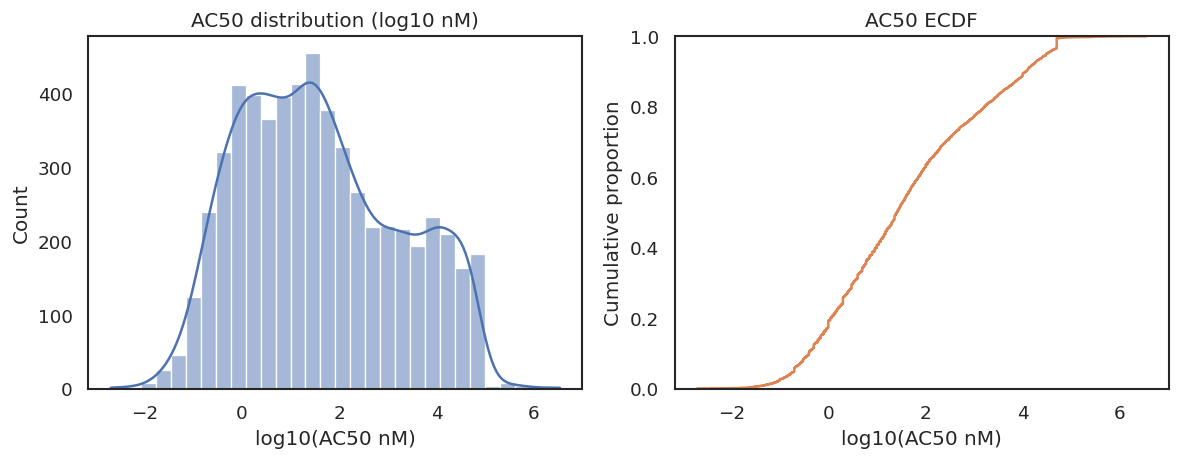

,smiles,target,AC,logac50
0,O=C(c1ccc(OCCN2CCCCC2)cc1)c1c(-c2ccc(O)cc2)sc2...,ESR1,0.002,-2.698970
1,C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1CC[C...,ESR1,0.004,-2.397940
2,CC/C(=C(/CC)c1ccc(O)cc1)c1ccc(O)cc1,ESR1,0.007,-2.154902
3,Oc1cccc(C2=C(Cl)c3cc(O)ccc3O[C@H]2c2ccc(OCCN3C...,ESR1,0.010,-2.000000
4,C[C@@H]1Cc2c([nH]c3ccccc23)[C@@H](c2c(F)cc(OCC...,ESR1,0.010,-2.000000


In [38]:
# 16a) Prepare AC50 dataset statistics for advanced QSAR
if 'compute_rmse' not in globals():
    def compute_rmse(y_true, y_pred):
        return float(np.sqrt(mean_squared_error(y_true, y_pred)))

if 'qsar_df' not in globals() or not {'smiles', 'logac50'}.issubset(set(qsar_df.columns)):
    qsar_df = prepare_qsar_ac50_dataset()

qsar_df = qsar_df.dropna(subset=['smiles', 'logac50']).drop_duplicates(subset=['smiles']).reset_index(drop=True)
log({'qsar_rows': len(qsar_df), 'qsar_cols': list(qsar_df.columns)})

describe_df = qsar_df['logac50'].describe().to_frame(name='logac50')
log({'qsar_logac50_stats': describe_df['logac50'].to_dict()})
display(describe_df)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.histplot(qsar_df['logac50'], bins=30, kde=True, color='#4c72b0', ax=axes[0])
axes[0].set_title('AC50 distribution (log10 nM)')
axes[0].set_xlabel('log10(AC50 nM)')
axes[0].set_ylabel('Count')

sns.ecdfplot(qsar_df['logac50'], color='#dd8452', ax=axes[1])
axes[1].set_title('AC50 ECDF')
axes[1].set_xlabel('log10(AC50 nM)')
axes[1].set_ylabel('Cumulative proportion')

save_and_show_fig(fig, fig_path('qsar_logac50_distribution.png'))

qsar_df.head()


In [39]:

# 16b) Build graph/fingerprint representations + descriptor scaling
from rdkit.Chem import rdMolDescriptors

QSAR_LABEL_MEAN = float(qsar_df['logac50'].mean())
QSAR_LABEL_STD = float(max(qsar_df['logac50'].std(ddof=0), 1e-3))
log({'logac50_mean': QSAR_LABEL_MEAN, 'logac50_std': QSAR_LABEL_STD})


def compute_desc_array(mol):
    if mol is None:
        return None
    values = []
    for name, func in PHYSICOCHEM_FEATURES:
        try:
            values.append(float(func(mol)))
        except Exception:
            values.append(0.0)
    for name, patt in TOXIC_ALERT_PATTERNS:
        if patt is None:
            values.append(0.0)
            continue
        values.append(float(len(mol.GetSubstructMatches(patt))))
    return np.array(values, dtype=np.float32)

qsar_entries = []
fail_stats = {}
for row in qsar_df.itertuples(index=False):
    mol = Chem.MolFromSmiles(row.smiles)
    if mol is None:
        fail_stats['invalid_smiles'] = fail_stats.get('invalid_smiles', 0) + 1
        continue
    graph, err = mol_to_graph(mol, max_nodes=MAX_NODES)
    if err is not None:
        fail_stats[err] = fail_stats.get(err, 0) + 1
        continue
    fp_result = ecfp4_bits(row.smiles, n_bits=FINGERPRINT_BITS, radius=FINGERPRINT_RADIUS, return_bv=True)
    if fp_result is None:
        fail_stats['fp_failed'] = fail_stats.get('fp_failed', 0) + 1
        continue
    fp_vec, fp_bv = fp_result
    desc_raw = compute_desc_array(mol)
    if desc_raw is None:
        fail_stats['desc_failed'] = fail_stats.get('desc_failed', 0) + 1
        continue
    logac50_raw = float(row.logac50)
    logac50_z = (logac50_raw - QSAR_LABEL_MEAN) / QSAR_LABEL_STD
    qsar_entries.append({
        'smiles': row.smiles,
        'logac50': logac50_raw,
        'logac50_z': logac50_z,
        'node_feats': graph['node_feats'],
        'edge_types': graph['edge_types'],
        'n_nodes': graph['n_nodes'],
        'desc_raw': desc_raw,
        'fp_bits': fp_vec,
        'fp_bv': fp_bv
    })

if not qsar_entries:
    raise RuntimeError('No QSAR entries survived featurization.')

raw_desc_matrix = np.vstack([e['desc_raw'] for e in qsar_entries]).astype(np.float32)
QSAR_DESC_MEAN = raw_desc_matrix.mean(axis=0)
QSAR_DESC_STD = np.clip(raw_desc_matrix.std(axis=0), 1e-3, None)

for e in qsar_entries:
    e['global_desc'] = ((e['desc_raw'] - QSAR_DESC_MEAN) / QSAR_DESC_STD).astype(np.float32)

qsar_graph_records = []
for e in qsar_entries:
    qsar_graph_records.append({
        'node_feats': e['node_feats'],
        'edge_types': e['edge_types'],
        'n_nodes': e['n_nodes'],
        'global_desc': e['global_desc'],
        'fp_bits': e['fp_bits'],
        'label': np.array([e['logac50_z']], dtype=np.float32),
        'smiles': e['smiles']
    })

qsar_fp_matrix = np.vstack([e['fp_bits'] for e in qsar_entries]).astype(np.float32)
qsar_desc_matrix_raw = raw_desc_matrix.copy()
qsar_desc_matrix = np.vstack([e['global_desc'] for e in qsar_entries]).astype(np.float32)
qsar_target_raw = np.array([e['logac50'] for e in qsar_entries], dtype=np.float32)
qsar_target_z = np.array([e['logac50_z'] for e in qsar_entries], dtype=np.float32)
qsar_fp_bv_list = [e['fp_bv'] for e in qsar_entries]
log({'qsar_entries': len(qsar_entries), 'qsar_fail_stats': fail_stats})

[2026-01-09T09:12:25.676742] {'logac50_mean': 1.598854090336126, 'logac50_std': 1.6192363191757755}
[2026-01-09T09:12:31.697714] {'qsar_entries': 5810, 'qsar_fail_stats': {'too_large': 19}}


In [40]:

# 16b-extra) Physicochemical descriptors & toxic functional groups summary
summary_rows = []
for e in qsar_entries:
    row = {'smiles': e['smiles'], 'logac50': e['logac50']}
    desc_raw = e['desc_raw']
    for idx, name in enumerate(PHYSICOCHEM_NAMES):
        row[f'physchem_{name}'] = float(desc_raw[idx])
    offset = len(PHYSICOCHEM_NAMES)
    for jdx, name in enumerate(TOXIC_ALERT_NAMES):
        row[name] = float(desc_raw[offset + jdx])
    summary_rows.append(row)
qsar_summary_df = pd.DataFrame(summary_rows)
summary_path = RUN_DIR / 'qsar_physchem_toxalerts.csv'
qsar_summary_df.to_csv(summary_path, index=False)
log({'qsar_physchem_exported': str(summary_path), 'rows': qsar_summary_df.shape[0]})
qsar_summary_df.head()

[2026-01-09T09:12:31.774761] {'qsar_physchem_exported': '/media/xuchengjie/E7562A2674DB25F7/SRRSH/2025.6.14/BP/ER/Output/qsar_physchem_toxalerts.csv', 'rows': 5810}


,smiles,logac50,physchem_ExactMolWt,physchem_MolLogP,physchem_TPSA,physchem_NumHBD,physchem_NumHBA,physchem_NumRotB,physchem_RingCount,physchem_FractionCSP3,physchem_LabuteASA,physchem_HeavyAtomCount,physchem_NumAromaticRings,physchem_NumAliphaticRings,alert_nitro_aromatic,alert_nitro_aliphatic,alert_azide,alert_aniline,alert_anilide,alert_isocyanate,alert_michael_acceptor,alert_epoxide,alert_organohalide,alert_quinone,alert_thioamide,alert_hydrazine
0,O=C(c1ccc(OCCN2CCCCC2)cc1)c1c(-c2ccc(O)cc2)sc2...,-2.698970,473.166077,6.0752,70.000000,2.0,6.0,7.0,5.0,0.250000,202.404694,34.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1CC[C...,-2.397940,272.177643,3.6092,40.459999,2.0,2.0,0.0,4.0,0.666667,120.381683,20.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CC/C(=C(/CC)c1ccc(O)cc1)c1ccc(O)cc1,-2.154902,268.146332,4.8286,40.459999,2.0,2.0,4.0,2.0,0.222222,119.577011,20.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Oc1cccc(C2=C(Cl)c3cc(O)ccc3O[C@H]2c2ccc(OCCN3C...,-2.000000,481.145599,5.6187,62.160000,2.0,5.0,7.0,5.0,0.259259,202.173004,34.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,C[C@@H]1Cc2c([nH]c3ccccc23)[C@@H](c2c(F)cc(OCC...,-2.000000,519.250916,4.7827,51.730000,2.0,4.0,9.0,5.0,0.500000,213.566437,37.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:

# 16c) Train/validation split shared by both models (KFold)
from sklearn.model_selection import KFold

QSAR_SEED = 1337
QSAR_BATCH_SIZE = 48
QSAR_FOLDS = []
qsar_indices = np.arange(len(qsar_entries))
kf = KFold(n_splits=5, shuffle=True, random_state=QSAR_SEED)
for fold_id, (tr_idx, val_idx) in enumerate(kf.split(qsar_indices)):
    QSAR_FOLDS.append({'train': tr_idx, 'val': val_idx})
log({'qsar_folds': [(len(s['train']), len(s['val'])) for s in QSAR_FOLDS]})

class QSARGraphDataset(Dataset):
    def __init__(self, indices):
        self.indices = np.asarray(indices, dtype=np.int64)

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        entry = qsar_graph_records[int(self.indices[idx])]
        return {
            'node_feats': entry['node_feats'],
            'edge_types': entry['edge_types'],
            'n_nodes': entry['n_nodes'],
            'global_desc': entry['global_desc'],
            'fingerprints': entry['fp_bits'],
            'label': entry['label'],
            'smiles': entry['smiles']
        }

def collate_qsar_graphs(batch):
    max_nodes = max(item['n_nodes'] for item in batch)
    feat_dim = batch[0]['node_feats'].shape[1]
    batch_size = len(batch)
    node_feats = torch.zeros(batch_size, max_nodes, feat_dim, dtype=torch.float32)
    node_mask = torch.zeros(batch_size, max_nodes, dtype=torch.bool)
    edge_types = torch.zeros(batch_size, max_nodes, max_nodes, dtype=torch.long)
    labels = torch.zeros(batch_size, 1, dtype=torch.float32)
    global_desc = torch.zeros(batch_size, len(DESC_NAMES), dtype=torch.float32)
    fingerprints = torch.zeros(batch_size, FINGERPRINT_BITS, dtype=torch.float32)
    smiles = []
    for i, item in enumerate(batch):
        n = item['n_nodes']
        node_feats[i, :n] = torch.from_numpy(item['node_feats'])
        node_mask[i, :n] = True
        edge_types[i, :n, :n] = torch.from_numpy(item['edge_types']).long()
        labels[i] = torch.from_numpy(item['label'])
        global_desc[i] = torch.from_numpy(item['global_desc'])
        fingerprints[i] = torch.from_numpy(item['fingerprints'])
        smiles.append(item['smiles'])
    return {
        'node_feats': node_feats,
        'node_mask': node_mask,
        'edge_types': edge_types,
        'labels': labels,
        'global_desc': global_desc,
        'fingerprints': fingerprints,
        'smiles': smiles
    }

def build_qsar_loaders(train_idx, val_idx=None, batch_size=QSAR_BATCH_SIZE, shuffle=True):
    train_loader = DataLoader(
        QSARGraphDataset(train_idx),
        batch_size=batch_size,
        shuffle=shuffle,
        collate_fn=collate_qsar_graphs
    )
    val_loader = None
    if val_idx is not None:
        val_loader = DataLoader(
            QSARGraphDataset(val_idx),
            batch_size=batch_size,
            shuffle=False,
            collate_fn=collate_qsar_graphs
        )
    return train_loader, val_loader

[2026-01-09T09:12:31.789644] {'qsar_folds': [(4648, 1162), (4648, 1162), (4648, 1162), (4648, 1162), (4648, 1162)]}


In [42]:

# 16c-extra) HistGradientBoosting baseline (5-fold sanity check)
from sklearn.ensemble import HistGradientBoostingRegressor
qsar_super_features = np.hstack([qsar_fp_matrix, qsar_desc_matrix]).astype(np.float32)
cv_rows = []
for fold_id, split in enumerate(QSAR_FOLDS):
    model = HistGradientBoostingRegressor(
        max_depth=8,
        learning_rate=0.06,
        max_iter=600,
        min_samples_leaf=12,
        random_state=QSAR_SEED + fold_id
    )
    model.fit(qsar_super_features[split['train']], qsar_target_raw[split['train']])
    pred = model.predict(qsar_super_features[split['val']])
    y_true = qsar_target_raw[split['val']]
    cv_rows.append({
        'fold': fold_id,
        'r2': r2_score(y_true, pred),
        'rmse': compute_rmse(y_true, pred),
        'mae': float(mean_absolute_error(y_true, pred))
    })
cv_hist_df = pd.DataFrame(cv_rows)
display(cv_hist_df)
log({'hist_qsar_cv_mean': cv_hist_df.mean(numeric_only=True).to_dict()})

,fold,r2,rmse,mae
0,0,0.724578,0.839263,0.635815
1,1,0.706180,0.886375,0.653272
2,2,0.716725,0.870140,0.632642
3,3,0.695117,0.890866,0.643253
4,4,0.732950,0.833695,0.614479


[2026-01-09T09:13:04.676105] {'hist_qsar_cv_mean': {'fold': 2.0, 'r2': 0.7151100204029993, 'rmse': 0.8640678324800992, 'mae': 0.6358923305061277}}


[2026-01-09T09:38:38.561447] {'qsar_gnn_oof_r2': 0.6688616871833801, 'qsar_gnn_oof_rmse': 0.932010441281603}
Saved: /media/xuchengjie/E7562A2674DB25F7/SRRSH/2025.6.14/BP/ER/Output/figures/qsar_gnn_cv_loss.png


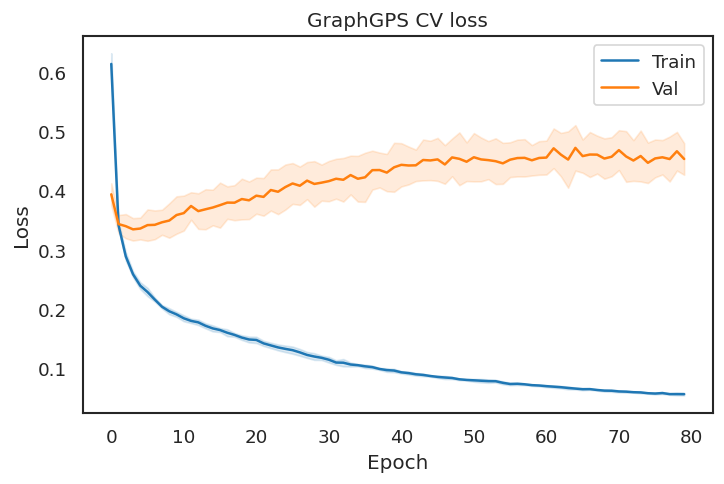

Saved: /media/xuchengjie/E7562A2674DB25F7/SRRSH/2025.6.14/BP/ER/Output/figures/qsar_gnn_best_val.png


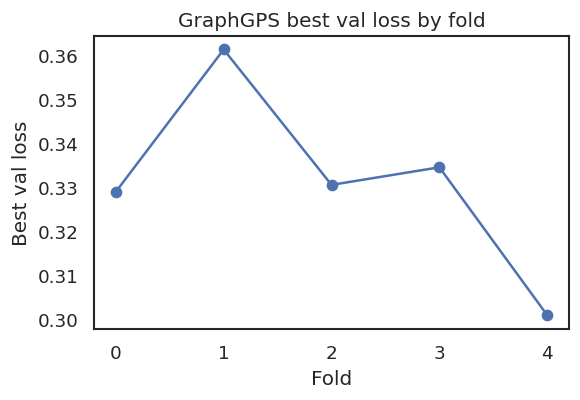

Saved: /media/xuchengjie/E7562A2674DB25F7/SRRSH/2025.6.14/BP/ER/Output/figures/qsar_gnn_full_train_loss.png


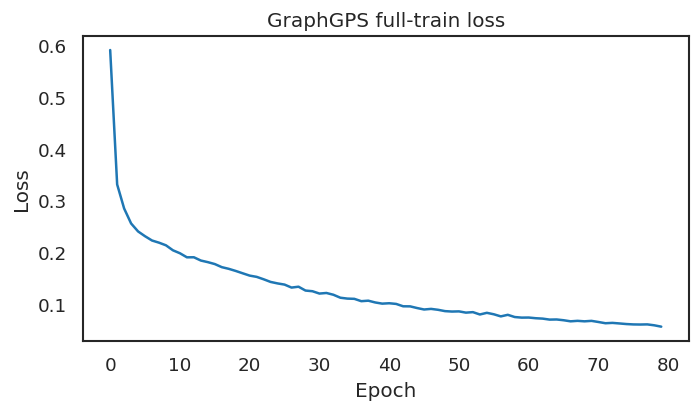

GraphTransformerModel(
  (input_proj): Linear(in_features=15, out_features=384, bias=True)
  (desc_mlp): Sequential(
    (0): Linear(in_features=24, out_features=192, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=192, out_features=192, bias=True)
  )
  (fp_mlp): Sequential(
    (0): Linear(in_features=2048, out_features=192, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=192, out_features=192, bias=True)
  )
  (layers): ModuleList(
    (0-5): 6 x GraphTransformerLayer(
      (attn): MultiHeadGraphAttention(
        (to_qkv): Linear(in_features=384, out_features=1152, bias=False)
        (to_out): Linear(in_features=384, out_features=384, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (edge_encoder): Embedding(6, 8)
      )
      (ffn): FeedForward(
        (net): Sequential(
          (0): Linear(in_features=384, out_features=1536, bias

In [43]:
# 16d) GraphGPS-style Graph Transformer regressor
QSAR_GNN_EPOCHS = 80
QSAR_GNN_LR = 2e-4
QSAR_GNN_WEIGHT_DECAY = 1e-4
QSAR_GNN_BATCH = 48


def run_qsar_gnn(train_idx, val_idx, epochs=QSAR_GNN_EPOCHS):
    train_loader, val_loader = build_qsar_loaders(train_idx, val_idx, batch_size=QSAR_GNN_BATCH)
    model = GraphTransformerModel(NODE_FEAT_DIM, 1, desc_dim=len(DESC_NAMES), fp_dim=FINGERPRINT_BITS).to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=QSAR_GNN_LR, weight_decay=QSAR_GNN_WEIGHT_DECAY)
    criterion = nn.MSELoss()
    best_val = float('inf')
    best_state = None
    history = {"train_loss": [], "val_loss": []}
    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0.0
        total = 0
        for batch in train_loader:
            node_feats = batch['node_feats'].to(DEVICE)
            node_mask = batch['node_mask'].to(DEVICE)
            edge_types = batch['edge_types'].to(DEVICE)
            labels = batch['labels'].to(DEVICE)
            global_desc = batch['global_desc'].to(DEVICE)
            fingerprints = batch['fingerprints'].to(DEVICE)
            optimizer.zero_grad()
            preds = model(node_feats, node_mask, edge_types, global_desc, fingerprints)
            loss = criterion(preds, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()
            train_loss += float(loss.item()) * labels.size(0)
            total += labels.size(0)
        if total:
            history["train_loss"].append(train_loss / total)

        val_loss = float('nan')
        if val_loader is not None:
            model.eval()
            val_total = 0
            val_sum = 0.0
            with torch.no_grad():
                for batch in val_loader:
                    node_feats = batch['node_feats'].to(DEVICE)
                    node_mask = batch['node_mask'].to(DEVICE)
                    edge_types = batch['edge_types'].to(DEVICE)
                    labels = batch['labels'].to(DEVICE)
                    global_desc = batch['global_desc'].to(DEVICE)
                    fingerprints = batch['fingerprints'].to(DEVICE)
                    preds = model(node_feats, node_mask, edge_types, global_desc, fingerprints)
                    loss = criterion(preds, labels)
                    val_sum += float(loss.item()) * labels.size(0)
                    val_total += labels.size(0)
            if val_total:
                val_loss = val_sum / val_total
                history["val_loss"].append(val_loss)
                if val_loss < best_val:
                    best_val = val_loss
                    best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

    if best_state is None:
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
    return best_state, best_val, history

qsar_gnn_oof = np.zeros(len(qsar_entries), dtype=np.float32)
qsar_gnn_states = []
qsar_gnn_histories = []
qsar_gnn_best_vals = []
for fold_id, split in enumerate(QSAR_FOLDS):
    state, best_val, history = run_qsar_gnn(split['train'], split['val'])
    qsar_gnn_states.append(state)
    qsar_gnn_histories.append(history)
    qsar_gnn_best_vals.append(best_val)
    model = GraphTransformerModel(NODE_FEAT_DIM, 1, desc_dim=len(DESC_NAMES), fp_dim=FINGERPRINT_BITS).to(DEVICE)
    model.load_state_dict(state)
    model.eval()
    loader = DataLoader(QSARGraphDataset(split['val']), batch_size=QSAR_GNN_BATCH, shuffle=False, collate_fn=collate_qsar_graphs)
    preds = []
    with torch.no_grad():
        for batch in loader:
            node_feats = batch['node_feats'].to(DEVICE)
            node_mask = batch['node_mask'].to(DEVICE)
            edge_types = batch['edge_types'].to(DEVICE)
            global_desc = batch['global_desc'].to(DEVICE)
            fingerprints = batch['fingerprints'].to(DEVICE)
            out = model(node_feats, node_mask, edge_types, global_desc, fingerprints)
            preds.append(out.cpu().numpy().reshape(-1))
    preds = np.concatenate(preds)
    qsar_gnn_oof[split['val']] = preds

qsar_gnn_oof_raw = qsar_gnn_oof * QSAR_LABEL_STD + QSAR_LABEL_MEAN
log({'qsar_gnn_oof_r2': float(r2_score(qsar_target_raw, qsar_gnn_oof_raw)), 'qsar_gnn_oof_rmse': compute_rmse(qsar_target_raw, qsar_gnn_oof_raw)})

if qsar_gnn_histories:
    fig, ax = plt.subplots(figsize=(6.2, 4.2))
    plot_loss_curves(qsar_gnn_histories, title="GraphGPS CV loss", ax=ax)
    save_and_show_fig(fig, fig_path("qsar_gnn_cv_loss.png"))

if qsar_gnn_best_vals:
    fig, ax = plt.subplots(figsize=(5, 3.5))
    ax.plot(qsar_gnn_best_vals, marker="o", color="#4c72b0")
    ax.set_title("GraphGPS best val loss by fold")
    ax.set_xlabel("Fold")
    ax.set_ylabel("Best val loss")
    save_and_show_fig(fig, fig_path("qsar_gnn_best_val.png"))

# Train final GraphGPS model on all data
full_loader, _ = build_qsar_loaders(qsar_indices, None, batch_size=QSAR_GNN_BATCH, shuffle=True)
qsar_gnn = GraphTransformerModel(NODE_FEAT_DIM, 1, desc_dim=len(DESC_NAMES), fp_dim=FINGERPRINT_BITS).to(DEVICE)
optimizer = torch.optim.AdamW(qsar_gnn.parameters(), lr=QSAR_GNN_LR, weight_decay=QSAR_GNN_WEIGHT_DECAY)
criterion = nn.MSELoss()
final_train_losses = []
for epoch in range(1, QSAR_GNN_EPOCHS + 1):
    qsar_gnn.train()
    total = 0
    epoch_loss = 0.0
    for batch in full_loader:
        node_feats = batch['node_feats'].to(DEVICE)
        node_mask = batch['node_mask'].to(DEVICE)
        edge_types = batch['edge_types'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)
        global_desc = batch['global_desc'].to(DEVICE)
        fingerprints = batch['fingerprints'].to(DEVICE)
        optimizer.zero_grad()
        preds = qsar_gnn(node_feats, node_mask, edge_types, global_desc, fingerprints)
        loss = criterion(preds, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(qsar_gnn.parameters(), 5.0)
        optimizer.step()
        epoch_loss += float(loss.item()) * labels.size(0)
        total += labels.size(0)
    if total:
        final_train_losses.append(epoch_loss / total)

if final_train_losses:
    fig, ax = plt.subplots(figsize=(6.0, 3.6))
    ax.plot(final_train_losses, color="#1f77b4")
    ax.set_title("GraphGPS full-train loss")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    save_and_show_fig(fig, fig_path("qsar_gnn_full_train_loss.png"))

qsar_gnn.eval()


Saved: /media/xuchengjie/E7562A2674DB25F7/SRRSH/2025.6.14/BP/ER/Output/figures/qsar_tabmixer_train_loss.png


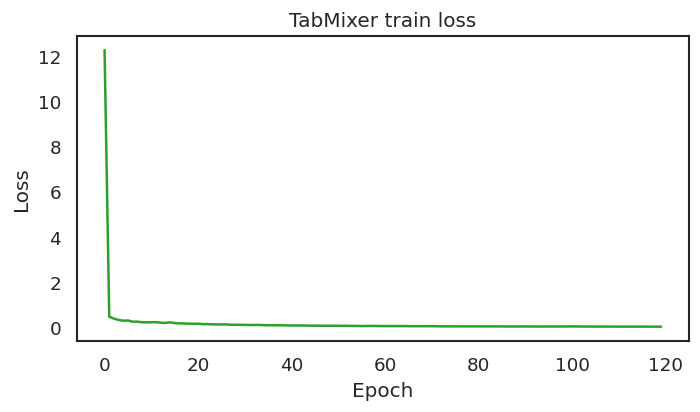

[2026-01-09T09:44:44.351057] {'qsar_tab_oof_r2': 0.9876824617385864, 'qsar_tab_oof_rmse': 0.1797539443026312}


In [44]:
# 16e) TabMixer for high-dimensional fingerprints
class TabMixer(nn.Module):
    def __init__(self, input_dim, hidden=512, depth=4, dropout=0.15):
        super().__init__()
        layers = []
        dim = input_dim
        for _ in range(depth):
            layers.append(
                nn.Sequential(
                    nn.Linear(dim, hidden),
                    nn.GELU(),
                    nn.Dropout(dropout),
                    nn.Linear(hidden, dim),
                    nn.LayerNorm(dim),
                )
            )
        self.layers = nn.ModuleList(layers)
        self.head = nn.Sequential(
            nn.Linear(dim, hidden),
            nn.GELU(),
            nn.Linear(hidden, 1),
        )

    def forward(self, x):
        for layer in self.layers:
            x = x + layer(x)
        return self.head(x).squeeze(-1)

fp_dataset = torch.utils.data.TensorDataset(
    torch.from_numpy(qsar_fp_matrix).float(),
    torch.from_numpy(qsar_target_z).float(),
)
train_loader = DataLoader(fp_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(fp_dataset, batch_size=512, shuffle=False)

QSAR_TAB_EPOCHS = 120
QSAR_TAB_LR = 1e-3
qsar_tabmixer = TabMixer(qsar_fp_matrix.shape[1]).to(DEVICE)
optimizer = torch.optim.AdamW(qsar_tabmixer.parameters(), lr=QSAR_TAB_LR, weight_decay=1e-4)
criterion = nn.MSELoss()

qsar_tab_train_losses = []
for epoch in range(1, QSAR_TAB_EPOCHS + 1):
    qsar_tabmixer.train()
    epoch_loss = 0.0
    total = 0
    for xb, yb in train_loader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)
        optimizer.zero_grad()
        pred = qsar_tabmixer(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += float(loss.item()) * yb.size(0)
        total += yb.size(0)
    if total:
        qsar_tab_train_losses.append(epoch_loss / total)

if qsar_tab_train_losses:
    fig, ax = plt.subplots(figsize=(6.0, 3.6))
    ax.plot(qsar_tab_train_losses, color="#2ca02c")
    ax.set_title("TabMixer train loss")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    save_and_show_fig(fig, fig_path("qsar_tabmixer_train_loss.png"))

qsar_tabmixer.eval()
qsar_tab_oof = []
with torch.no_grad():
    for xb, _ in val_loader:
        pred = qsar_tabmixer(xb.to(DEVICE))
        qsar_tab_oof.append(pred.cpu().numpy())
qsar_tab_oof = np.concatenate(qsar_tab_oof)
qsar_tab_oof = qsar_tab_oof[: len(qsar_entries)]
qsar_tab_oof_raw = qsar_tab_oof * QSAR_LABEL_STD + QSAR_LABEL_MEAN
log({'qsar_tab_oof_r2': float(r2_score(qsar_target_raw, qsar_tab_oof_raw)), 'qsar_tab_oof_rmse': compute_rmse(qsar_target_raw, qsar_tab_oof_raw)})


In [45]:
# 保存 QSAR 模型到文件
import torch
from pathlib import Path

# 确保 OUTPUT_DIR 存在
if 'OUTPUT_DIR' not in globals():
    OUTPUT_DIR = Path.cwd() / 'Output'
    OUTPUT_DIR.mkdir(exist_ok=True)

# 保存路径
QSAR_GNN_PATH = OUTPUT_DIR / 'qsar_gnn.pt'
QSAR_TABMIXER_PATH = OUTPUT_DIR / 'qsar_tabmixer.pt'
QSAR_DATA_PATH = OUTPUT_DIR / 'qsar_data.pt'

print("=" * 60)
print("保存 QSAR 模型")
print("=" * 60)

# 保存 qsar_gnn
if 'qsar_gnn' in globals():
    torch.save({
        'state_dict': qsar_gnn.state_dict(),
        'model_type': 'GraphTransformerModel',
        'node_feat_dim': NODE_FEAT_DIM,
        'desc_dim': len(DESC_NAMES),
        'fp_dim': FINGERPRINT_BITS
    }, QSAR_GNN_PATH)
    print(f"✓ 已保存 qsar_gnn -> {QSAR_GNN_PATH}")
else:
    print("⚠️ qsar_gnn 未找到，请先运行 Cell 54")

# 保存 qsar_tabmixer
if 'qsar_tabmixer' in globals():
    torch.save({
        'state_dict': qsar_tabmixer.state_dict(),
        'model_type': 'TabMixer',
        'input_dim': qsar_fp_matrix.shape[1] if 'qsar_fp_matrix' in globals() else 2048
    }, QSAR_TABMIXER_PATH)
    print(f"✓ 已保存 qsar_tabmixer -> {QSAR_TABMIXER_PATH}")
else:
    print("⚠️ qsar_tabmixer 未找到，请先运行 Cell 55")

# 保存 QSAR 归一化参数
if 'QSAR_LABEL_MEAN' in globals() and 'QSAR_LABEL_STD' in globals():
    torch.save({
        'QSAR_LABEL_MEAN': QSAR_LABEL_MEAN,
        'QSAR_LABEL_STD': QSAR_LABEL_STD,
        'qsar_entries_count': len(qsar_entries) if 'qsar_entries' in globals() else 0
    }, QSAR_DATA_PATH)
    print(f"✓ 已保存 QSAR数据 -> {QSAR_DATA_PATH}")
    print(f"  - QSAR_LABEL_MEAN: {QSAR_LABEL_MEAN:.4f}")
    print(f"  - QSAR_LABEL_STD: {QSAR_LABEL_STD:.4f}")
else:
    print("⚠️ QSAR归一化参数未找到，请先运行 Cell 51")

print()
print("=" * 60)
print("QSAR模型保存完成")
print("=" * 60)
print(f"保存位置: {OUTPUT_DIR}")
print("文件:")
if QSAR_GNN_PATH.exists():
    size_mb = QSAR_GNN_PATH.stat().st_size / 1e6
    print(f"  ✓ qsar_gnn.pt ({size_mb:.1f} MB)")
if QSAR_TABMIXER_PATH.exists():
    size_mb = QSAR_TABMIXER_PATH.stat().st_size / 1e6
    print(f"  ✓ qsar_tabmixer.pt ({size_mb:.1f} MB)")
if QSAR_DATA_PATH.exists():
    size_kb = QSAR_DATA_PATH.stat().st_size / 1e3
    print(f"  ✓ qsar_data.pt ({size_kb:.1f} KB)")



保存 QSAR 模型
✓ 已保存 qsar_gnn -> /media/xuchengjie/E7562A2674DB25F7/SRRSH/2025.6.14/BP/ER/Output/qsar_gnn.pt
✓ 已保存 qsar_tabmixer -> /media/xuchengjie/E7562A2674DB25F7/SRRSH/2025.6.14/BP/ER/Output/qsar_tabmixer.pt
✓ 已保存 QSAR数据 -> /media/xuchengjie/E7562A2674DB25F7/SRRSH/2025.6.14/BP/ER/Output/qsar_data.pt
  - QSAR_LABEL_MEAN: 1.5989
  - QSAR_LABEL_STD: 1.6192

QSAR模型保存完成
保存位置: /media/xuchengjie/E7562A2674DB25F7/SRRSH/2025.6.14/BP/ER/Output
文件:
  ✓ qsar_gnn.pt (45.7 MB)
  ✓ qsar_tabmixer.pt (37.9 MB)
  ✓ qsar_data.pt (1.3 KB)


In [46]:

# 16f) Tanimoto k-NN regression baseline (similarity-weighted logAC50)
from rdkit import DataStructs

QSAR_KNN_K = 8


def predict_knn_logac50(fp_bv, exclude_idx=None, k=QSAR_KNN_K):
    if fp_bv is None:
        return np.nan
    sims = np.array(DataStructs.BulkTanimotoSimilarity(fp_bv, qsar_fp_bv_list), dtype=np.float32)
    if exclude_idx is not None and 0 <= exclude_idx < sims.size:
        sims[exclude_idx] = 0.0
    top_idx = sims.argsort()[::-1][:k]
    weights = sims[top_idx]
    if np.allclose(weights.sum(), 0.0):
        return np.nan
    return float(np.dot(weights, qsar_target_raw[top_idx]) / weights.sum())

qsar_knn_oof = np.array([predict_knn_logac50(fp_bv, exclude_idx=i) for i, fp_bv in enumerate(qsar_fp_bv_list)], dtype=np.float32)
log({'qsar_knn_r2': float(r2_score(qsar_target_raw, qsar_knn_oof)), 'qsar_knn_rmse': compute_rmse(qsar_target_raw, qsar_knn_oof)})

[2026-01-09T09:44:48.355556] {'qsar_knn_r2': 0.6875282526016235, 'qsar_knn_rmse': 0.9053603113129207}


## QSAR model parity plots (OOF)


Saved: /media/xuchengjie/E7562A2674DB25F7/SRRSH/2025.6.14/BP/ER/Output/figures/qsar_model_parity.png


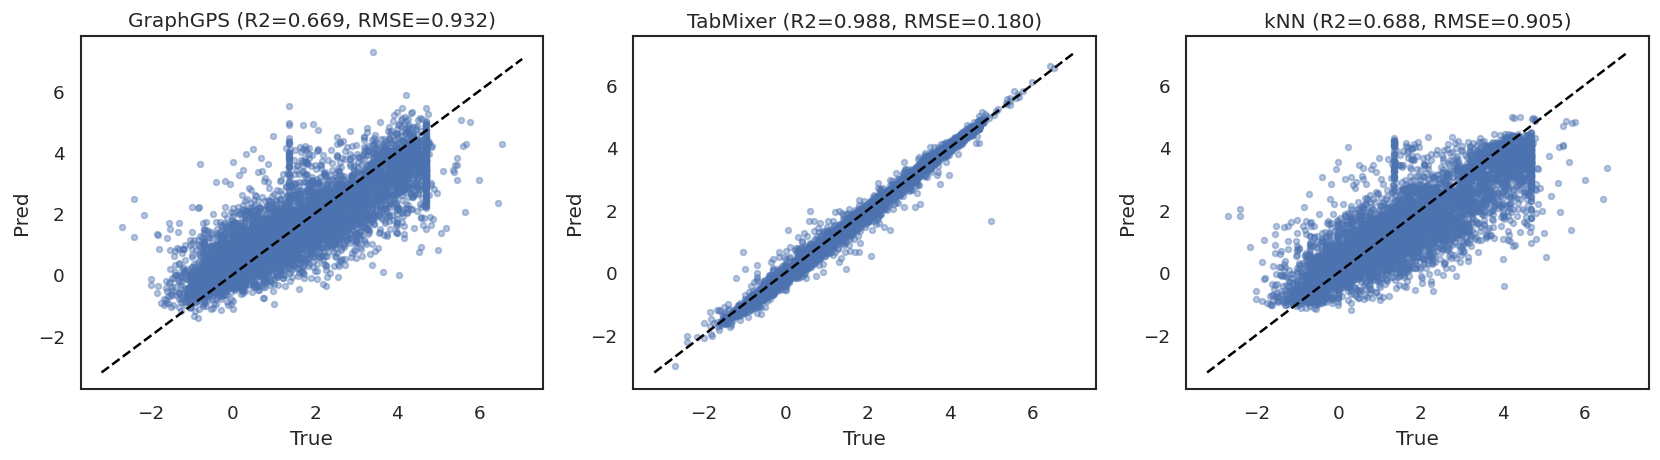

In [47]:
models = [
    ("GraphGPS", qsar_gnn_oof_raw),
    ("TabMixer", qsar_tab_oof_raw),
    ("kNN", qsar_knn_oof),
]
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
for ax, (name, pred) in zip(axes, models):
    r2 = float(r2_score(qsar_target_raw, pred))
    rmse = compute_rmse(qsar_target_raw, pred)
    ax.scatter(qsar_target_raw, pred, s=12, alpha=0.4)
    lims = [qsar_target_raw.min() - 0.5, qsar_target_raw.max() + 0.5]
    ax.plot(lims, lims, linestyle='--', color='black')
    ax.set_title(f"{name} (R2={r2:.3f}, RMSE={rmse:.3f})")
    ax.set_xlabel("True")
    ax.set_ylabel("Pred")

save_and_show_fig(fig, fig_path("qsar_model_parity.png"))


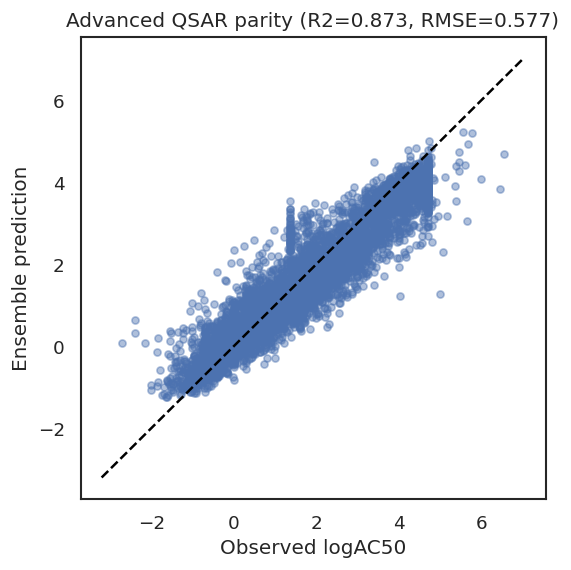

Saved: /media/xuchengjie/E7562A2674DB25F7/SRRSH/2025.6.14/BP/ER/Output/figures/advanced_qsar_residuals.png


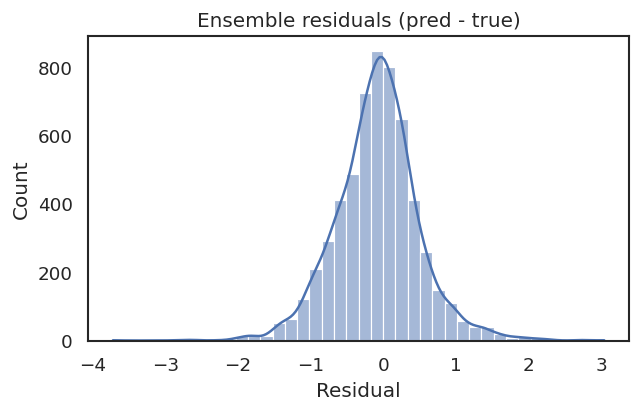

[2026-01-09T09:44:49.097522] {'advanced_qsar_r2': 0.8728796318708764, 'advanced_qsar_rmse': 0.5774622833994728, 'advanced_qsar_parity': '/media/xuchengjie/E7562A2674DB25F7/SRRSH/2025.6.14/BP/ER/Output/advanced_qsar_parity.png'}


,smiles,logac50,pred_logac50_graphgps,pred_logac50_tabmixer,pred_logac50_knn,pred_logac50_z_graphgps,pred_logac50_z_tabmixer,pred_logac50,qsar_status
0,O=C(c1ccc(OCCN2CCCCC2)cc1)c1c(-c2ccc(O)cc2)sc2...,-2.698970,1.549383,-2.985696,1.818770,-0.030552,-2.831304,0.069860,train
1,C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1CC[C...,-2.397940,1.236948,-2.019271,1.796681,-0.223504,-2.234464,0.321165,train
2,CC/C(=C(/CC)c1ccc(O)cc1)c1ccc(O)cc1,-2.154902,1.943061,-2.062480,0.805314,0.212574,-2.261149,0.086023,train
3,Oc1cccc(C2=C(Cl)c3cc(O)ccc3O[C@H]2c2ccc(OCCN3C...,-2.000000,-0.353776,-2.104026,-0.602771,-1.205896,-2.286806,-1.065962,train
4,C[C@@H]1Cc2c([nH]c3ccccc23)[C@@H](c2c(F)cc(OCC...,-2.000000,-0.150106,-1.625453,-0.834856,-1.080114,-1.991252,-0.940377,train


In [48]:
# 16g) Blend advanced models + visualize agreement
qsar_blend_df = pd.DataFrame({
    'smiles': [e['smiles'] for e in qsar_entries],
    'logac50': qsar_target_raw,
    'pred_logac50_graphgps': qsar_gnn_oof_raw,
    'pred_logac50_tabmixer': qsar_tab_oof_raw,
    'pred_logac50_knn': qsar_knn_oof,
    'pred_logac50_z_graphgps': qsar_gnn_oof,
    'pred_logac50_z_tabmixer': qsar_tab_oof,
})
weights = np.array([0.25, 0.35, 0.40])
stack = np.vstack([
    qsar_blend_df['pred_logac50_graphgps'],
    qsar_blend_df['pred_logac50_tabmixer'],
    qsar_blend_df['pred_logac50_knn'],
])
qsar_blend_df['pred_logac50'] = np.average(stack, axis=0, weights=weights)
qsar_blend_df['qsar_status'] = 'train'

r2_ens = float(r2_score(qsar_blend_df['logac50'], qsar_blend_df['pred_logac50']))
rmse_ens = compute_rmse(qsar_blend_df['logac50'], qsar_blend_df['pred_logac50'])

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(qsar_blend_df['logac50'], qsar_blend_df['pred_logac50'], s=18, alpha=0.45)
lims = [qsar_blend_df['logac50'].min() - 0.5, qsar_blend_df['logac50'].max() + 0.5]
ax.plot(lims, lims, linestyle='--', color='black')
ax.set_xlabel('Observed logAC50')
ax.set_ylabel('Ensemble prediction')
ax.set_title(f'Advanced QSAR parity (R2={r2_ens:.3f}, RMSE={rmse_ens:.3f})')
parity_path = RUN_DIR / 'advanced_qsar_parity.png'
fig.savefig(parity_path, dpi=220)
if SHOW_IMAGES_INLINE:
    display(fig)
plt.close(fig)

residuals = qsar_blend_df['pred_logac50'] - qsar_blend_df['logac50']
fig, ax = plt.subplots(figsize=(5.5, 3.6))
sns.histplot(residuals, bins=40, kde=True, color="#4c72b0", ax=ax)
ax.set_title("Ensemble residuals (pred - true)")
ax.set_xlabel("Residual")
ax.set_ylabel("Count")
save_and_show_fig(fig, fig_path("advanced_qsar_residuals.png"))

log({
    'advanced_qsar_r2': r2_ens,
    'advanced_qsar_rmse': rmse_ens,
    'advanced_qsar_parity': str(parity_path)
})
qsar_blend_df.head()


In [49]:

# 16h) Predict Structures/*.sdf with the advanced ensemble and merge outputs
if not PRED_STRUCT_PATH.exists():
    raise FileNotFoundError('Run section 14 first to populate predictions_structures.csv.')

required_artifacts = ['qsar_gnn', 'qsar_tabmixer', 'qsar_entries']
for name in required_artifacts:
    if name not in globals():
        raise RuntimeError(f'Missing {name}; run sections 16a-16g first.')

pred_struct_df = pd.read_csv(PRED_STRUCT_PATH)
RDLogger.DisableLog('rdApp.*')


def sdf_to_qsar_inputs(rel_path):
    sdf_path = STRUCTURES_DIR / rel_path
    if not sdf_path.exists():
        return None, None, None, None, None
    suppl = Chem.SDMolSupplier(str(sdf_path), sanitize=True, removeHs=True)
    for mol in suppl:
        if mol is None:
            continue
        smiles = Chem.MolToSmiles(mol, canonical=True)
        graph, err = mol_to_graph(mol, max_nodes=MAX_NODES)
        if err is not None:
            return smiles, None, None, None, None
        desc_raw = compute_desc_array(mol)
        if desc_raw is None:
            return smiles, None, None, None, None
        desc_vec = ((desc_raw - QSAR_DESC_MEAN) / QSAR_DESC_STD).astype(np.float32)
        fp_result = ecfp4_bits(smiles, n_bits=FINGERPRINT_BITS, radius=FINGERPRINT_RADIUS, return_bv=True)
        if fp_result is None:
            return smiles, None, None, None, None
        fp_vec, fp_bv = fp_result
        graph.update({'smiles': smiles, 'global_desc': desc_vec, 'fp_bits': fp_vec})
        return smiles, graph, fp_vec, desc_raw, fp_bv
    return None, None, None, None, None

qsar_gnn.eval()
qsar_tabmixer.eval()
structure_preds = []
status_counts = {}
for rel_path in tqdm(pred_struct_df['file'].tolist(), desc='QSAR ensemble scoring'):
    smiles, graph, fp_vec, desc_raw, fp_bv = sdf_to_qsar_inputs(rel_path)
    status = 'ok'
    gnn_val = np.nan
    tab_val = np.nan
    if graph is None:
        status = 'graph_failed'
    else:
        node_feats = torch.from_numpy(graph['node_feats']).unsqueeze(0).to(DEVICE)
        node_mask = torch.ones(1, graph['n_nodes'], dtype=torch.bool, device=DEVICE)
        edge_types = torch.from_numpy(graph['edge_types']).unsqueeze(0).long().to(DEVICE)
        desc = torch.from_numpy(graph['global_desc']).unsqueeze(0).to(DEVICE)
        fp_tensor = torch.from_numpy(graph['fp_bits']).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            gnn_out = qsar_gnn(node_feats, node_mask, edge_types, desc, fp_tensor)
        gnn_val = float(gnn_out.view(-1).cpu().item() * QSAR_LABEL_STD + QSAR_LABEL_MEAN)
    if fp_vec is None:
        status = 'fp_failed' if status == 'ok' else status
    else:
        with torch.no_grad():
            tab_val = float(qsar_tabmixer(torch.from_numpy(fp_vec).unsqueeze(0).to(DEVICE)).cpu().item() * QSAR_LABEL_STD + QSAR_LABEL_MEAN)
    knn_val = predict_knn_logac50(fp_bv)
    values = [v for v in [gnn_val, tab_val, knn_val] if not np.isnan(v)]
    ensemble_val = float(np.mean(values)) if values else np.nan
    row = {
        'file': rel_path,
        'qsar_smiles': smiles,
        'pred_logac50_graphgps': gnn_val,
        'pred_logac50_tabmixer': tab_val,
        'pred_logac50_knn': knn_val,
        'pred_logac50': ensemble_val,
        'qsar_status': status
    }
    if desc_raw is not None:
        for idx, name in enumerate(PHYSICOCHEM_NAMES):
            row[f'physchem_{name}'] = float(desc_raw[idx])
        offset = len(PHYSICOCHEM_NAMES)
        for jdx, name in enumerate(TOXIC_ALERT_NAMES):
            row[name] = int(desc_raw[offset + jdx] > 0.5)
    structure_preds.append(row)
    status_counts[status] = status_counts.get(status, 0) + 1

qsar_pred_df = pd.DataFrame(structure_preds)
MERGED_PRED_PATH = RUN_DIR / 'predictions_structures_logac50.csv'
combined_df = pred_struct_df.merge(qsar_pred_df, on='file', how='left')
combined_df.to_csv(MERGED_PRED_PATH, index=False)
log({'advanced_qsar_predictions': str(MERGED_PRED_PATH), 'qsar_status_counts': status_counts})
MERGED_PRED_PATH

QSAR ensemble scoring:   0%|          | 0/7003 [00:00<?, ?it/s]

[2026-01-09T09:45:22.868694] {'advanced_qsar_predictions': '/media/xuchengjie/E7562A2674DB25F7/SRRSH/2025.6.14/BP/ER/Output/predictions_structures_logac50.csv', 'qsar_status_counts': {'ok': 7003}}


PosixPath('/media/xuchengjie/E7562A2674DB25F7/SRRSH/2025.6.14/BP/ER/Output/predictions_structures_logac50.csv')

In [50]:

# 17a) Build fused features and quantile bins
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import KFold

QSAR_SUPER_FEATURES = np.hstack([qsar_fp_matrix, qsar_desc_matrix_raw]).astype(np.float32)
NUM_BINS = 8
raw_edges = np.quantile(qsar_target_raw, np.linspace(0, 1, NUM_BINS + 1))
bin_edges = np.unique(raw_edges)
if len(bin_edges) - 1 < NUM_BINS:
    bin_edges = np.linspace(qsar_target_raw.min(), qsar_target_raw.max(), NUM_BINS + 1)
BIN_COUNT = len(bin_edges) - 1


def assign_bins(values):
    return np.clip(np.digitize(values, bin_edges[1:-1], right=False), 0, BIN_COUNT - 1)

qsar_bin_labels = assign_bins(qsar_target_raw)
bin_means = []
for i in range(BIN_COUNT):
    mask = qsar_bin_labels == i
    if mask.any():
        bin_means.append(float(qsar_target_raw[mask].mean()))
    else:
        bin_means.append(float((bin_edges[i] + bin_edges[i+1]) / 2))
bin_means = np.array(bin_means, dtype=np.float32)
log({'qsar_bins': BIN_COUNT, 'bin_edges': bin_edges.tolist(), 'bin_means': bin_means.tolist()})

[2026-01-09T09:45:22.891108] {'qsar_bins': 8, 'bin_edges': [-2.698970079421997, -0.29317566379904747, 0.3010300099849701, 0.8450980186462402, 1.3979400396347046, 1.9637877941131592, 2.7934406995773315, 3.8804016411304474, 6.544067859649658], 'bin_means': [-0.7176269292831421, 0.001061009126715362, 0.5457150340080261, 1.1283414363861084, 1.6672722101211548, 2.3415913581848145, 3.3293235301971436, 4.391383171081543]}


,fold,acc,r2_cont,rmse_cont,mae_cont
0,0,0.438898,0.708884,0.879853,0.625058
1,1,0.432874,0.724062,0.852877,0.625643
2,2,0.413081,0.688862,0.897335,0.639258
3,3,0.397590,0.675144,0.939524,0.668374
4,4,0.413081,0.649254,0.936548,0.662914


[2026-01-09T09:49:54.588143] {'cls_cv_mean': {'fold': 2.0, 'acc': 0.41910499139414803, 'r2_cont': 0.6892412907780058, 'rmse_cont': 0.9012275307054237, 'mae_cont': 0.6442493458758081}}
Saved: /media/xuchengjie/E7562A2674DB25F7/SRRSH/2025.6.14/BP/ER/Output/figures/qsar_bin_confusion.png


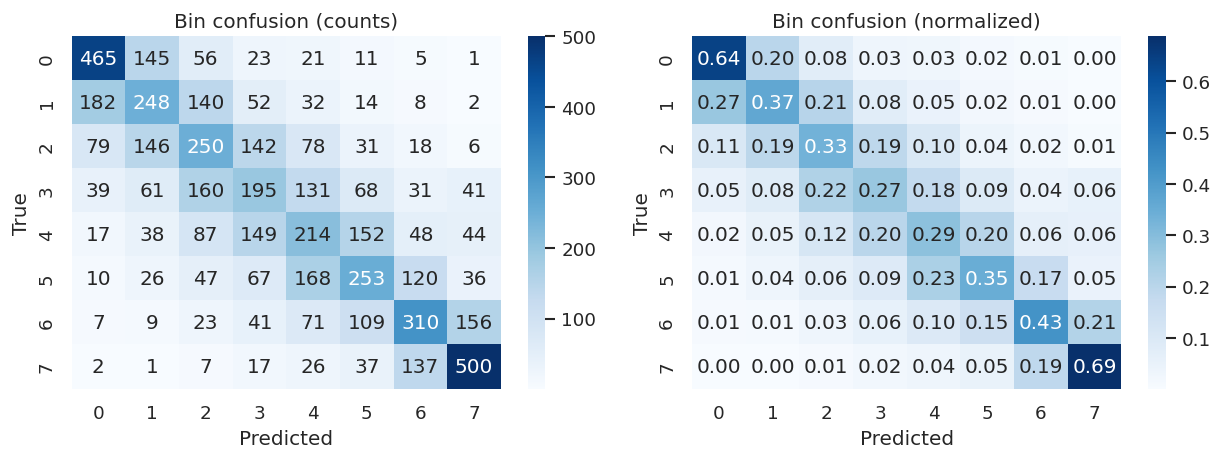

Saved: /media/xuchengjie/E7562A2674DB25F7/SRRSH/2025.6.14/BP/ER/Output/figures/qsar_classifier_oof_parity.png


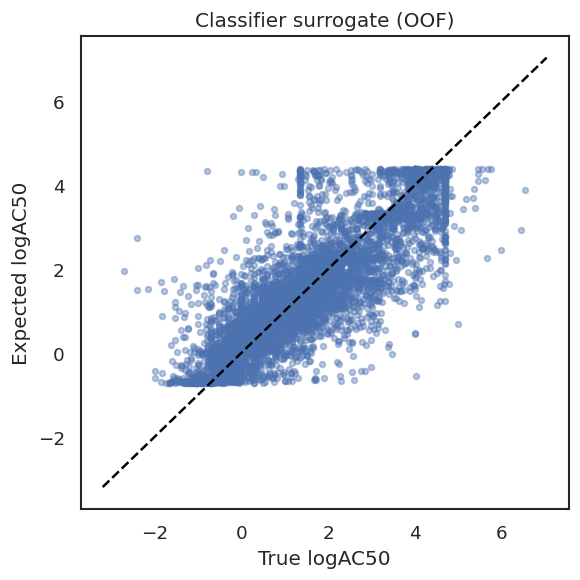

In [51]:
# 17b) Cross-validation diagnostics for the classifier surrogate
cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
cls_rows = []
oof_probs = np.zeros((len(qsar_bin_labels), BIN_COUNT), dtype=np.float32)

for fold_id, (train_idx, val_idx) in enumerate(cv.split(QSAR_SUPER_FEATURES)):
    clf = HistGradientBoostingClassifier(
        max_depth=8,
        learning_rate=0.06,
        max_iter=800,
        min_samples_leaf=16,
        l2_regularization=0.05,
        random_state=SEED + fold_id,
        class_weight='balanced',
    )
    clf.fit(QSAR_SUPER_FEATURES[train_idx], qsar_bin_labels[train_idx])
    prob = clf.predict_proba(QSAR_SUPER_FEATURES[val_idx])
    oof_probs[val_idx] = prob
    exp_pred = prob.dot(bin_means)
    true_vals = qsar_target_raw[val_idx]
    cls_rows.append({
        'fold': fold_id,
        'acc': float((prob.argmax(axis=1) == qsar_bin_labels[val_idx]).mean()),
        'r2_cont': float(r2_score(true_vals, exp_pred)),
        'rmse_cont': compute_rmse(true_vals, exp_pred),
        'mae_cont': float(mean_absolute_error(true_vals, exp_pred)),
    })

cls_cv_df = pd.DataFrame(cls_rows)
display(cls_cv_df)
log({'cls_cv_mean': cls_cv_df.mean(numeric_only=True).to_dict()})

# OOF diagnostics
pred_bins = oof_probs.argmax(axis=1)
cm_bins = confusion_matrix(qsar_bin_labels, pred_bins)
fig, axes = plt.subplots(1, 2, figsize=(10.5, 4))
plot_confusion_matrix(cm_bins, [str(i) for i in range(BIN_COUNT)], ax=axes[0], title="Bin confusion (counts)")
plot_confusion_matrix(cm_bins, [str(i) for i in range(BIN_COUNT)], ax=axes[1], title="Bin confusion (normalized)", normalize=True)
save_and_show_fig(fig, fig_path("qsar_bin_confusion.png"))

exp_pred_all = oof_probs.dot(bin_means)
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(qsar_target_raw, exp_pred_all, s=12, alpha=0.4)
lims = [qsar_target_raw.min() - 0.5, qsar_target_raw.max() + 0.5]
ax.plot(lims, lims, linestyle='--', color='black')
ax.set_xlabel('True logAC50')
ax.set_ylabel('Expected logAC50')
ax.set_title('Classifier surrogate (OOF)')
save_and_show_fig(fig, fig_path("qsar_classifier_oof_parity.png"))


In [52]:

# 17c) Train final classifier on all data
hgb_cls = HistGradientBoostingClassifier(
    max_depth=8,
    learning_rate=0.06,
    max_iter=900,
    min_samples_leaf=12,
    l2_regularization=0.05,
    random_state=SEED,
    class_weight='balanced'
)
hgb_cls.fit(QSAR_SUPER_FEATURES, qsar_bin_labels)
log({'cls_train_accuracy': float((hgb_cls.predict(QSAR_SUPER_FEATURES) == qsar_bin_labels).mean())})


def cls_expected_logac50(prob_matrix):
    return prob_matrix.dot(bin_means)

[2026-01-09T09:51:11.867594] {'cls_train_accuracy': 0.9950086058519794}


In [53]:
# ==== 🎯 完整综合分析平台：预测 + 对接 + 毒性 + AI对话 + 可视化 ====
"""
集成功能：
1. 化合物输入与靶点/毒性预测
2. 分子对接（可选择受体结构）
3. 毒性注释（PubChem查询）
4. AI对话窗口（DeepSeek毒性解释）
5. 3D相互作用可视化
"""

import time, json, subprocess, shutil, os, re
import numpy as np, pandas as pd
import torch, torch.nn as nn
import ipywidgets as W
from pathlib import Path
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, Descriptors
from IPython.display import display, HTML, clear_output
import requests
import urllib3
import joblib
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# ========== 配置 ==========
class Config:
    BASE_DIR = Path.cwd()
    OUTPUT_DIR = BASE_DIR / 'Output'
    RECEPTOR_DIR = BASE_DIR / 'Structures' / 'Receptors'
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    VINA = "/home/xuchengjie/Program/Docking/vina"
    ADFR_BIN = "/home/xuchengjie/Program/ADFRsuite-1.0/bin"
    PREP_REC = str(Path(ADFR_BIN) / "prepare_receptor")
    PREP_LIG = str(Path(ADFR_BIN) / "prepare_ligand")
    MODEL_TWO_STEP = OUTPUT_DIR / 'target_two_step.joblib'
    MODEL_TARGET = MODEL_TWO_STEP  # alias for backward compatibility
    MODEL_GNN = OUTPUT_DIR / 'qsar_gnn.pt'
    MODEL_TABMIXER = OUTPUT_DIR / 'qsar_tabmixer.pt'
    DATA_FILE = OUTPUT_DIR / 'qsar_data.pt'
    DEEPSEEK_API_KEY = "sk-52d5204226d043c9a6b034f90b8d5956"


In [54]:
# ========== 分子特征计算 (恢复) ==========
from rdkit.Chem import rdMolDescriptors

def simple_atom_features(atom):
    return np.array([
        atom.GetAtomicNum() / 100.0, atom.GetDegree() / 5.0,
        atom.GetFormalCharge() / 5.0, atom.GetTotalValence() / 6.0,
        atom.GetTotalNumHs(includeNeighbors=True) / 4.0,
        float(atom.GetIsAromatic()), float(atom.IsInRing()),
        atom.GetMass() / 200.0,
        float(atom.GetChiralTag() != Chem.rdchem.ChiralType.CHI_UNSPECIFIED),
        float(atom.GetHybridization() == Chem.rdchem.HybridizationType.SP),
        float(atom.GetHybridization() == Chem.rdchem.HybridizationType.SP2),
        float(atom.GetHybridization() == Chem.rdchem.HybridizationType.SP3),
        float(atom.GetHybridization() == Chem.rdchem.HybridizationType.SP3D),
        float(atom.GetHybridization() == Chem.rdchem.HybridizationType.SP3D2),
        1.0
    ], dtype=np.float32)

def mol_to_simple_graph(mol, max_nodes=200):
    if mol is None:
        return None
    mol = Chem.RemoveHs(mol)
    n_atoms = mol.GetNumAtoms()
    if n_atoms == 0 or n_atoms > max_nodes:
        return None
    node_feats = np.vstack([simple_atom_features(atom) for atom in mol.GetAtoms()]).astype(np.float32)
    edge_types = np.zeros((n_atoms, n_atoms), dtype=np.uint8)
    for idx in range(n_atoms):
        edge_types[idx, idx] = 0
    bond_type_map = {
        Chem.rdchem.BondType.SINGLE: 1, Chem.rdchem.BondType.DOUBLE: 2,
        Chem.rdchem.BondType.TRIPLE: 3, Chem.rdchem.BondType.AROMATIC: 4
    }
    for bond in mol.GetBonds():
        i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        edge_id = bond_type_map.get(bond.GetBondType(), 1)
        edge_types[i, j] = edge_id
        edge_types[j, i] = edge_id
    return {'node_feats': node_feats, 'edge_types': edge_types, 'n_nodes': n_atoms}

def compute_descriptors(mol):
    if mol is None:
        return np.zeros(24, dtype=np.float32)
    try:
        phys = [
            Descriptors.ExactMolWt(mol),
            Descriptors.MolLogP(mol),
            rdMolDescriptors.CalcTPSA(mol),
            rdMolDescriptors.CalcNumHBD(mol),
            rdMolDescriptors.CalcNumHBA(mol),
            rdMolDescriptors.CalcNumRotatableBonds(mol),
            Descriptors.RingCount(mol),
            Descriptors.FractionCSP3(mol),
            rdMolDescriptors.CalcLabuteASA(mol),
            Descriptors.HeavyAtomCount(mol),
            rdMolDescriptors.CalcNumAromaticRings(mol),
            rdMolDescriptors.CalcNumAliphaticRings(mol)
        ]
        
        toxic_smarts = [
            '[c][N+](=O)[O-]',
            '[CX4][N+](=O)[O-]',
            'N=[N+]=N',
            'cN',
            'Nc1ccc(cc1)C=O',
            'N=C=O',
            '[CH2]=[CH]-C(=O)[#6]',
            'C1OC1',
            '[CX4]([F,Cl,Br,I])([F,Cl,Br,I])[F,Cl,Br,I]',
            'O=C1C=CC(=O)C=C1',
            'NC(=S)',
            'NN'
        ]
        
        toxic_vals = []
        for smarts in toxic_smarts:
            patt = Chem.MolFromSmarts(smarts)
            if patt:
                toxic_vals.append(float(len(mol.GetSubstructMatches(patt))))
            else:
                toxic_vals.append(0.0)

        return np.array(phys + toxic_vals, dtype=np.float32)

    except Exception:
        return np.zeros(24, dtype=np.float32)

def compute_fingerprint(mol, n_bits=2048, radius=2):
    if mol is None:
        return np.zeros(n_bits, dtype=np.float32)
    try:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
        arr = np.zeros((1, n_bits), dtype=np.int32)
        DataStructs.ConvertToNumpyArray(fp, arr[0])
        return arr[0].astype(np.float32)
    except Exception:
        return np.zeros(n_bits, dtype=np.float32)

def prepare_graph_inputs(mol, max_nodes=200):
    graph = mol_to_simple_graph(mol, max_nodes=max_nodes)
    if graph is None:
        return None, "Invalid molecule"
    node_feats = np.zeros((max_nodes, graph['node_feats'].shape[1]), dtype=np.float32)
    node_feats[:graph['n_nodes']] = graph['node_feats']
    edge_types = np.zeros((max_nodes, max_nodes), dtype=np.uint8)
    edge_types[:graph['n_nodes'], :graph['n_nodes']] = graph['edge_types']
    node_mask = np.zeros(max_nodes, dtype=bool)
    node_mask[:graph['n_nodes']] = True
    desc = compute_descriptors(mol)
    fp = compute_fingerprint(mol)
    return {
        'node_feats': torch.from_numpy(node_feats).unsqueeze(0).to(Config.DEVICE),
        'edge_types': torch.from_numpy(edge_types).unsqueeze(0).to(Config.DEVICE).long(),
        'node_mask': torch.from_numpy(node_mask).unsqueeze(0).to(Config.DEVICE),
        'desc': torch.from_numpy(desc).unsqueeze(0).to(Config.DEVICE),
        'fp': torch.from_numpy(fp).unsqueeze(0).to(Config.DEVICE)
    }, None


In [55]:
# ========== 补充缺失的模型定义 (复用前文，必要时补充) ==========
import torch
import torch.nn as nn
import numpy as np

if 'DESC_NAMES' not in globals():
    DESC_NAMES = [
        'ExactMolWt', 'MolLogP', 'TPSA', 'NumHBD', 'NumHBA', 'NumRotB',
        'RingCount', 'FractionCSP3', 'LabuteASA', 'HeavyAtomCount',
        'NumAromaticRings', 'NumAliphaticRings', 'alert_nitro_aromatic',
        'alert_nitro_aliphatic', 'alert_azide', 'alert_aniline',
        'alert_anilide', 'alert_isocyanate', 'alert_michael_acceptor',
        'alert_epoxide', 'alert_organohalide', 'alert_quinone',
        'alert_thioamide', 'alert_hydrazine'
    ]
if 'FINGERPRINT_BITS' not in globals():
    FINGERPRINT_BITS = 2048
if 'GRAPH_DIM' not in globals():
    GRAPH_DIM = 384
if 'GT_LAYERS' not in globals():
    GT_LAYERS = 6
if 'GT_HEADS' not in globals():
    GT_HEADS = 8
if 'DROPOUT' not in globals():
    DROPOUT = 0.1
if 'DROPEDGE_P' not in globals():
    DROPEDGE_P = 0.1
if 'EDGE_VOCAB_SIZE' not in globals():
    EDGE_VOCAB_SIZE = 6

if 'GraphTransformerModel' not in globals():
    class FeedForward(nn.Module):
        def __init__(self, dim, hidden_dim, dropout):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(dim, hidden_dim),
                nn.GELU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_dim, dim),
                nn.Dropout(dropout),
            )
        def forward(self, x):
            return self.net(x)

    class MultiHeadGraphAttention(nn.Module):
        def __init__(self, dim, heads, dropout, edge_vocab):
            super().__init__()
            self.heads = heads
            self.dim = dim
            self.dim_head = dim // heads
            self.scale = self.dim_head ** -0.5
            self.to_qkv = nn.Linear(dim, dim * 3, bias=False)
            self.to_out = nn.Linear(dim, dim)
            self.dropout = nn.Dropout(dropout)
            self.store_attn = False
            self.last_attn = None
            self.edge_encoder = nn.Embedding(edge_vocab, heads)
            with torch.no_grad():
                self.edge_encoder.weight.zero_()
                if edge_vocab > 1:
                    self.edge_encoder.weight[1:].normal_(mean=0.0, std=0.02)

        def forward(self, x, attn_mask, edge_types, node_mask):
            B, N, _ = x.shape
            qkv = self.to_qkv(x).chunk(3, dim=-1)
            q, k, v = [t.view(B, N, self.heads, self.dim_head).transpose(1, 2) for t in qkv]
            attn_logits = torch.matmul(q, k.transpose(-1, -2)) * self.scale
            if edge_types is not None:
                edge_bias = self.edge_encoder(edge_types)
                edge_bias = edge_bias.permute(0, 3, 1, 2)
                attn_logits = attn_logits + edge_bias
            mask = None
            if attn_mask is not None:
                mask = attn_mask.unsqueeze(1)
                attn_logits = attn_logits.masked_fill(~mask, float('-inf'))
            row_valid = node_mask.unsqueeze(1).unsqueeze(-1)
            attn_logits = torch.where(row_valid, attn_logits, torch.zeros_like(attn_logits))
            attn = torch.softmax(attn_logits, dim=-1)
            attn = attn * row_valid.float()
            attn = self.dropout(attn)
            if self.store_attn:
                self.last_attn = attn.detach().to('cpu')
            out = torch.matmul(attn, v)
            out = out.transpose(1, 2).contiguous().view(B, N, self.dim)
            out = self.to_out(out)
            out = out * node_mask.unsqueeze(-1).float()
            return out

    class GraphTransformerLayer(nn.Module):
        def __init__(self, dim, heads, dropout, edge_vocab):
            super().__init__()
            self.attn = MultiHeadGraphAttention(dim, heads, dropout, edge_vocab)
            self.ffn = FeedForward(dim, dim * 4, dropout)
            self.norm1 = nn.LayerNorm(dim)
            self.norm2 = nn.LayerNorm(dim)
            self.dropout = nn.Dropout(dropout)
        def forward(self, x, attn_mask, edge_types, node_mask):
            attn_out = self.attn(self.norm1(x), attn_mask, edge_types, node_mask)
            x = x + self.dropout(attn_out)
            ff_out = self.ffn(self.norm2(x))
            x = x + ff_out
            x = x * node_mask.unsqueeze(-1).float()
            return x

    class GraphTransformerModel(nn.Module):
        def __init__(self, node_feat_dim, num_targets, desc_dim=len(DESC_NAMES), fp_dim=FINGERPRINT_BITS,
                     graph_dim=None, gt_layers=None, gt_heads=None, dropout=None, dropedge_p=None):
            super().__init__()
            self.graph_dim = int(graph_dim if graph_dim is not None else GRAPH_DIM)
            self.gt_layers = int(gt_layers if gt_layers is not None else GT_LAYERS)
            self.gt_heads = int(gt_heads if gt_heads is not None else GT_HEADS)
            self.dropout = float(dropout if dropout is not None else DROPOUT)
            self.desc_dim = desc_dim
            self.fp_dim = fp_dim
            self.dropedge_p = DROPEDGE_P if dropedge_p is None else dropedge_p
            half_dim = max(self.graph_dim // 2, 32)
            self.input_proj = nn.Linear(node_feat_dim, self.graph_dim)
            self.desc_mlp = nn.Sequential(
                nn.Linear(desc_dim, half_dim),
                nn.GELU(),
                nn.Dropout(self.dropout),
                nn.Linear(half_dim, half_dim),
            )
            self.fp_mlp = nn.Sequential(
                nn.Linear(fp_dim, half_dim),
                nn.GELU(),
                nn.Dropout(self.dropout),
                nn.Linear(half_dim, half_dim),
            )
            self.layers = nn.ModuleList([
                GraphTransformerLayer(self.graph_dim, self.gt_heads, self.dropout, EDGE_VOCAB_SIZE)
                for _ in range(self.gt_layers)
            ])
            self.norm = nn.LayerNorm(self.graph_dim)
            self.readout = nn.Sequential(
                nn.Linear(self.graph_dim + half_dim + half_dim, self.graph_dim),
                nn.GELU(),
                nn.Dropout(self.dropout),
                nn.Linear(self.graph_dim, num_targets),
            )

        def forward(self, node_feats, node_mask, edge_types, global_desc=None, fingerprints=None):
            x = self.input_proj(node_feats)
            x = x * node_mask.unsqueeze(-1).float()
            if edge_types is not None:
                B, N = edge_types.shape[0], edge_types.shape[1]
                eye = torch.eye(N, dtype=torch.long, device=edge_types.device).unsqueeze(0).expand(B, -1, -1)
                edge_types = torch.where(eye.bool(), edge_types.clamp(min=EDGE_VOCAB_SIZE - 1), edge_types)
            attn_mask = (edge_types > 0)
            node_pair_mask = node_mask.unsqueeze(1) & node_mask.unsqueeze(2)
            attn_mask = attn_mask & node_pair_mask
            for layer in self.layers:
                x = layer(x, attn_mask, edge_types, node_mask)
            x = self.norm(x)
            mask = node_mask.unsqueeze(-1).float()
            graph_emb = (x * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1e-6)
            batch_size = x.size(0)
            desc_emb = self.desc_mlp(global_desc) if global_desc is not None else torch.zeros(batch_size, self.graph_dim // 2, device=x.device)
            fp_emb = self.fp_mlp(fingerprints) if fingerprints is not None else torch.zeros(batch_size, self.graph_dim // 2, device=x.device)
            combo = torch.cat([graph_emb, desc_emb, fp_emb], dim=-1)
            return self.readout(combo)

if 'TabMixer' not in globals():
    class TabMixer(nn.Module):
        def __init__(self, input_dim, hidden=512, depth=4, dropout=0.15):
            super().__init__()
            layers = []
            dim = input_dim
            for _ in range(depth):
                layers.append(
                    nn.Sequential(
                        nn.Linear(dim, hidden),
                        nn.GELU(),
                        nn.Dropout(dropout),
                        nn.Linear(hidden, dim),
                        nn.LayerNorm(dim),
                    )
                )
            self.layers = nn.ModuleList(layers)
            self.head = nn.Sequential(
                nn.Linear(dim, hidden),
                nn.GELU(),
                nn.Linear(hidden, 1),
            )
        def forward(self, x):
            for layer in self.layers:
                x = x + layer(x)
            return self.head(x).squeeze(-1)


In [56]:
# ========== 智能模型加载器 ==========
def _merge_model_kwargs(defaults, meta):
    kwargs = defaults.copy()
    info_sources = []
    if isinstance(meta, dict):
        info_sources.append(meta)
        cfg = meta.get('config') if isinstance(meta.get('config'), dict) else None
        if cfg:
            info_sources.append(cfg)
    for src in info_sources:
        for key in ['node_feat_dim', 'desc_dim', 'fp_dim', 'graph_dim', 'gt_layers',
                    'gt_heads', 'dropout', 'dropedge_p', 'input_dim', 'hidden', 'depth']:
            if key in src:
                kwargs[key] = src[key]
        if 'targets' in src and 'num_targets' in kwargs and isinstance(src['targets'], (list, tuple)):
            kwargs['num_targets'] = len(src['targets'])
        if 'num_targets' in src:
            kwargs['num_targets'] = src['num_targets']
    return kwargs

def smart_load_model(path, model_class, default_kwargs, device):
    obj = torch.load(path, map_location=device)
    meta = obj if isinstance(obj, dict) else {}
    if isinstance(obj, torch.nn.Module):
        return obj.eval(), 'complete_model', meta
    if isinstance(obj, dict):
        state_dict = None
        for key in ['model_state_dict', 'state_dict', 'model', 'net', 'best_model']:
            if key in obj:
                candidate = obj[key]
                state_dict = candidate.state_dict() if isinstance(candidate, torch.nn.Module) else candidate
                break
        if state_dict is None and all(isinstance(v, torch.Tensor) for v in obj.values()):
            state_dict = obj
        if state_dict is not None:
            kwargs = _merge_model_kwargs(default_kwargs, meta)
            model = model_class(**kwargs).to(device)
            model.load_state_dict(state_dict, strict=False)
            return model.eval(), 'state_dict', meta
    return None, 'unknown_format', meta

In [57]:
# ========== 预测引擎 ==========
import joblib

class PredictionEngine:
    def __init__(self):
        self.models = {}
        self.qsar_stats = {'mean': 0.0, 'std': 1.0}
        self.target_labels = ['ESR1', 'ESR2', 'GPER1']
        self.loaded = False
        self.target_meta = {
            'threshold_step1': 0.5,
            'threshold_step2': threshold_step2_default,
            'unknown_band': unknown_band_default,
            'use_maccs': use_maccs,
        }

    def load_models(self):
        if self.loaded:
            return True, "Models already loaded"
        try:
            if Config.DATA_FILE.exists():
                data = torch.load(Config.DATA_FILE, map_location='cpu')
                if isinstance(data, dict):
                    self.qsar_stats['mean'] = float(data.get('QSAR_LABEL_MEAN', data.get('mean', 0.0)))
                    self.qsar_stats['std'] = float(data.get('QSAR_LABEL_STD', data.get('std', 1.0)))

            # Load two-step target models (prefer in-memory, else joblib)
            step1 = globals().get('model_step1')
            step2 = globals().get('model_step2')
            meta = None
            model_path = getattr(Config, 'MODEL_TWO_STEP', Config.MODEL_TARGET)
            if (step1 is None or step2 is None) and model_path.exists():
                obj = joblib.load(model_path)
                if isinstance(obj, dict):
                    step1 = obj.get('model_step1')
                    step2 = obj.get('model_step2')
                    meta = obj.get('meta', {})
            if step1 is None or step2 is None:
                return False, "❌ 缺少两步法靶点模型 (target_two_step.joblib)"
            self.models['step1'] = step1
            self.models['step2'] = step2
            if isinstance(meta, dict):
                self.target_meta['threshold_step1'] = float(meta.get('threshold_step1', self.target_meta['threshold_step1']))
                self.target_meta['threshold_step2'] = float(meta.get('threshold_step2', self.target_meta['threshold_step2']))
                self.target_meta['unknown_band'] = float(meta.get('unknown_band', self.target_meta['unknown_band']))
                self.target_meta['use_maccs'] = bool(meta.get('use_maccs', self.target_meta['use_maccs']))
                if isinstance(meta.get('rf_class_weight'), dict):
                    self.target_meta['rf_class_weight'] = meta['rf_class_weight']
                if 'labels' in meta and isinstance(meta['labels'], (list, tuple)):
                    self.target_labels = list(meta['labels'])

            # Load QSAR models (optional)
            if Config.MODEL_GNN.exists() and 'GraphTransformerModel' in globals():
                default_kwargs = {
                    'node_feat_dim': NODE_FEAT_DIM,
                    'num_targets': 1,
                    'desc_dim': len(DESC_NAMES),
                    'fp_dim': FINGERPRINT_BITS,
                    'graph_dim': GRAPH_DIM,
                    'gt_layers': GT_LAYERS,
                    'gt_heads': GT_HEADS,
                    'dropout': DROPOUT,
                    'dropedge_p': DROPEDGE_P,
                }
                model, fmt, _ = smart_load_model(Config.MODEL_GNN, GraphTransformerModel, default_kwargs, Config.DEVICE)
                if model:
                    self.models['gnn'] = model

            if Config.MODEL_TABMIXER.exists() and 'TabMixer' in globals():
                default_kwargs = {'input_dim': FINGERPRINT_BITS, 'hidden': 512, 'depth': 4, 'dropout': 0.15}
                model, fmt, _ = smart_load_model(Config.MODEL_TABMIXER, TabMixer, default_kwargs, Config.DEVICE)
                if model is None:
                    return False, "❌ 缺少 qsar_tabmixer.pt"
                self.models['tabmixer'] = model

            self.loaded = True
            return True, "✓ 模型加载成功"
        except Exception as e:
            import traceback
            return False, f"Error: {str(e)}\n{traceback.format_exc()[:500]}"

    def predict_target(self, mol):
        if not self.loaded:
            success, msg = self.load_models()
            if not success:
                return None, f"Models not loaded: {msg}"
        step1 = self.models.get('step1')
        step2 = self.models.get('step2')
        if step1 is None or step2 is None:
            return None, "Two-step models missing"
        smi = Chem.MolToSmiles(mol) if mol is not None else None
        if smi is None or not smi:
            return None, "Invalid molecule"
        try:
            pred_df = predict_target_for_smiles_with_uncertainty(
                [smi],
                step1,
                step2,
                threshold_step1=self.target_meta['threshold_step1'],
                threshold_step2=self.target_meta['threshold_step2'],
                unknown_band=self.target_meta['unknown_band'],
                use_maccs_features=self.target_meta.get('use_maccs', use_maccs),
            )
            row = pred_df.iloc[0].to_dict()
            probs = {
                'ESR1': row.get('P_ESR1'),
                'ESR2': row.get('P_ESR2'),
                'GPER1': row.get('P_GPER1'),
            }
            result = {
                'target': row.get('Predicted_target'),
                'probs': probs,
                'unknown': bool(row.get('Unknown_flag', False)),
                'P_ER_vs_GPER': row.get('P_ER_vs_GPER'),
            }
            return result, None
        except Exception as e:
            import traceback
            return None, f"Prediction error: {str(e)}\n{traceback.format_exc()[:500]}"

    def predict_ac50(self, mol):
        if not self.loaded:
            success, msg = self.load_models()
            if not success:
                return None, f"Models not loaded: {msg}"
        tensors, err = prepare_graph_inputs(mol)
        if err:
            return None, err
        try:
            pred_z = []
            if 'gnn' in self.models:
                with torch.no_grad():
                    val = self.models['gnn'](tensors['node_feats'], tensors['node_mask'],
                                            tensors['edge_types'], tensors['desc'], tensors['fp']).squeeze().cpu().item()
                    pred_z.append(val)
            if 'tabmixer' in self.models:
                with torch.no_grad():
                    val = self.models['tabmixer'](tensors['fp']).cpu().item()
                    pred_z.append(val)
            if not pred_z:
                return None, "No QSAR models"
            avg_z = float(np.mean(pred_z))
            pred_log = avg_z * self.qsar_stats['std'] + self.qsar_stats['mean']
            ac50_uM = (10 ** pred_log) / 1000.0  # pred_log is log10(nM), convert to μM
            return ac50_uM, None
        except Exception as e:
            import traceback
            return None, f"AC50 error: {str(e)}\n{traceback.format_exc()[:500]}"


In [58]:
# ========== 对接功能 ==========
def _run_cmd(cmd, cwd=None, label="command", log_file=None):
    proc = subprocess.run(cmd, cwd=cwd, capture_output=True, text=True)
    if log_file and cwd:
        log_path = Path(cwd) / log_file
        log_path.parent.mkdir(parents=True, exist_ok=True)
        with open(log_path, "w", encoding="utf-8", errors="ignore") as fh:
            if proc.stdout:
                fh.write("STDOUT:\n" + proc.stdout + "\n")
            if proc.stderr:
                fh.write("STDERR:\n" + proc.stderr + "\n")
    if proc.returncode != 0:
        raise RuntimeError(f"{label} 失败（exit={proc.returncode}）")
    return proc

def _prepare_ligand_pdbqt(lig_pdb: Path, tmp_dir: Path):
    try:
        _run_cmd([Config.PREP_LIG, '-l', lig_pdb.name, '-o', 'ligand.pdbqt'], cwd=tmp_dir, label="prepare_ligand")
        return tmp_dir / "ligand.pdbqt"
    except Exception:
        obabel_bin = shutil.which("obabel")
        if obabel_bin:
            _run_cmd([obabel_bin, lig_pdb.name, '-O', 'ligand.pdbqt', '--partialcharge', 'gasteiger'], 
                    cwd=tmp_dir, label="obabel")
            return tmp_dir / "ligand.pdbqt"
        raise

def _prepare_receptor_pdbqt(receptor_path: Path, tmp_dir: Path):
    rec_copy = tmp_dir / receptor_path.name
    shutil.copyfile(receptor_path, rec_copy)
    out_path = tmp_dir / "receptor.pdbqt"
    _run_cmd([Config.PREP_REC, '-r', rec_copy.name, '-o', out_path.name, '-A', 'checkhydrogens'],
            cwd=tmp_dir, label="prepare_receptor")
    return out_path

def _compute_box(receptor_path: Path):
    coords = []
    with open(receptor_path) as f:
        for line in f:
            if line.startswith(('ATOM', 'HETATM')):
                try:
                    coords.append([float(line[30:38]), float(line[38:46]), float(line[46:54])])
                except Exception:
                    continue
    if not coords:
        raise RuntimeError("无法解析坐标")
    coords = np.array(coords)
    center = coords.mean(axis=0)
    size = np.clip((coords.max(axis=0) - coords.min(axis=0)) * 1.1, 20.0, None)
    return center, size

def _rdkit_to_3d_pdb(mol) -> Path:
    tmp_dir = Config.OUTPUT_DIR / "Docking_Temp"
    tmp_dir.mkdir(exist_ok=True)
    tmp_pdb = tmp_dir / "ligand_rdkit.pdb"
    work_mol = Chem.AddHs(Chem.Mol(mol), addCoords=True)
    params = AllChem.ETKDGv3()
    params.randomSeed = 42
    if AllChem.EmbedMolecule(work_mol, params=params) != 0:
        raise ValueError("RDKit Embed 失败")
    try:
        AllChem.MMFFOptimizeMolecule(work_mol, maxIters=200)
    except Exception:
        AllChem.UFFOptimizeMolecule(work_mol, maxIters=200)
    Chem.MolToPDBFile(work_mol, str(tmp_pdb))
    return tmp_pdb

def _obabel_from_smiles(smiles: str, out_pdb: Path):
    obabel_bin = shutil.which("obabel")
    if not obabel_bin:
        raise RuntimeError("未找到 obabel")
    _run_cmd([obabel_bin, "-:", smiles, "-O", str(out_pdb), "--gen3d"], label="obabel_gen3d")
    if not out_pdb.exists():
        raise RuntimeError("obabel gen3d 失败")
    return out_pdb

def dock_molecule(mol, receptor_name):
    receptor_path = Config.RECEPTOR_DIR / receptor_name
    if not receptor_path.exists():
        return None, f"Receptor {receptor_name} not found"
    try:
        tmp_dir = Config.OUTPUT_DIR / "Docking_Temp"
        tmp_dir.mkdir(exist_ok=True)
        try:
            lig_pdb = _rdkit_to_3d_pdb(mol)
        except Exception:
            smiles = Chem.MolToSmiles(Chem.RemoveHs(mol))
            lig_pdb = tmp_dir / "ligand_rdkit.pdb"
            _obabel_from_smiles(smiles, lig_pdb)
        lig_pdbqt = _prepare_ligand_pdbqt(lig_pdb, tmp_dir)
        rec_pdbqt = _prepare_receptor_pdbqt(receptor_path, tmp_dir)
        center, size = _compute_box(receptor_path)
        cmd = [Config.VINA, '--receptor', rec_pdbqt.name, '--ligand', lig_pdbqt.name,
               '--out', 'out.pdbqt', '--center_x', f"{center[0]:.3f}",
               '--center_y', f"{center[1]:.3f}", '--center_z', f"{center[2]:.3f}",
               '--size_x', f"{size[0]:.3f}", '--size_y', f"{size[1]:.3f}",
               '--size_z', f"{size[2]:.3f}", '--exhaustiveness', '8']
        _run_cmd(cmd, cwd=tmp_dir, label="vina", log_file="vina.log")
        score = 0.0
        with open(tmp_dir / "out.pdbqt") as f:
            for line in f:
                if 'REMARK VINA RESULT' in line:
                    parts = line.split()
                    if len(parts) >= 4:
                        score = float(parts[3])
                    break
        return {
            'score': score,
            'receptor': str(receptor_path),
            'ligand': str(tmp_dir / "out.pdbqt"),
            'receptor_name': receptor_name
        }, None
    except Exception as e:
        import traceback
        return None, f"Docking error: {str(e)}"

In [59]:
# ========== 辅助功能 (PubChem & AI) ==========
import requests
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors, rdMolDescriptors

# 靶点详细生理效应描述库
TARGET_EFFECTS = {
    'ESR1': """
    <b>雌激素受体α (ERα) 生理效应：</b><br>
    ERα 主要表达于乳腺、子宫、卵巢（膜细胞）、骨骼、肝脏和脂肪组织。<br>
    <b>1. 生殖系统：</b> 介导雌激素刺激子宫内膜增生和乳腺导管发育。过度激活与ER+乳腺癌及子宫内膜癌风险相关。<br>
    <b>2. 骨骼健康：</b> 维持成骨细胞活性，抑制破骨细胞，对维持骨密度至关重要。<br>
    <b>3. 代谢调节：</b> 参与葡萄糖稳态和脂质代谢调节，具有抗肥胖作用。<br>
    <b>4. 心血管：</b> 具有血管保护作用，促进一氧化氮生成，扩张血管。<br>
    <b>潜在风险：</b> 拮抗剂可能导致更年期症状（潮热）、骨质流失；激动剂可能增加血栓风险。
    """,
    'ESR2': """
    <b>雌激素受体β (ERβ) 生理效应：</b><br>
    ERβ 广泛分布于卵巢（颗粒细胞）、前列腺、肺、中枢神经系统、心血管系统和免疫系统。<br>
    <b>1. 抗增殖作用：</b> 在许多组织中（如乳腺、子宫、前列腺），ERβ 通常拮抗 ERα 的增殖效应，具有潜在的肿瘤抑制作用。<br>
    <b>2. 神经系统：</b> 涉及认知功能保护、情绪调节（抗焦虑/抗抑郁）及神经元存活。<br>
    <b>3. 免疫系统：</b> 调节免疫反应和炎症过程。<br>
    <b>4. 心血管：</b> 协助调节血压和血管反应性。<br>
    <b>潜在风险：</b> 调节机制复杂，选择性调节剂的长期安全性尚在研究中。
    """,
    'GPER1': """
    <b>G蛋白偶联雌激素受体1 (GPER1/GPR30) 生理效应：</b><br>
    介导雌激素的快速非基因组信号转导效应。<br>
    <b>1. 快速血管效应：</b> 介导快速的血管舒张作用，调节血压。<br>
    <b>2. 代谢调节：</b> 促进胰岛β细胞分泌胰岛素，参与糖脂代谢。<br>
    <b>3. 细胞生长：</b> 在某些癌症（如乳腺癌、卵巢癌）中表达上调，可能促进细胞增殖和迁移。<br>
    <b>4. 神经系统：</b> 参与神经保护和痛觉调节。<br>
    <b>潜在风险：</b> 其在肿瘤进展中的作用具有两面性，需具体分析。
    """
}

def get_molecule_info(smiles):
    """从 PubChem 获取化合物信息"""
    if not smiles: return None
    mol = Chem.MolFromSmiles(smiles)
    if not mol: return None
    info = {
        'pubchem_name': 'Unknown',
        'formula': rdMolDescriptors.CalcMolFormula(mol),
        'mol_weight': Descriptors.ExactMolWt(mol),
        'image': Draw.MolToImage(mol, size=(300, 300))
    }
    try:
        url = "https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/smiles/property/Title/JSON"
        resp = requests.post(url, data={"smiles": smiles}, timeout=5)
        if resp.status_code == 200:
            data = resp.json()
            props = data.get('PropertyTable', {}).get('Properties', [])
            if props: info['pubchem_name'] = props[0].get('Title', info['pubchem_name'])
    except Exception as e: print(f"PubChem API Warning: {e}")
    return info

def _fetch_pubchem_section(cid, heading):
    """Helper to fetch specific section from PubChem PUG VIEW"""
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug_view/data/compound/{cid}/JSON?heading={heading}"
    try:
        # Increased timeout to 30s for PubChem
        resp = requests.get(url, timeout=30) 
        if resp.status_code == 200: 
            return resp.json()
        print(f"PubChem API Error ({heading}): Status {resp.status_code}")
    except Exception as e:
        print(f"PubChem API Request Failed ({heading}): {e}")
    return None

def _find_section_recursive(sections, target_name):
    """Recursively find a section by TOCHeading"""
    for sec in sections:
        if sec.get('TOCHeading') == target_name:
            return sec
        if 'Section' in sec:
            found = _find_section_recursive(sec['Section'], target_name)
            if found: return found
    return None

def _parse_ghs_data(data):
    """Parse GHS Classification from JSON to HTML and Text"""
    if not data: return "未找到 GHS 数据 (数据为空)", ""
    
    html_parts = []
    text_parts = []
    
    try:
        root_sections = data.get('Record', {}).get('Section', [])
        ghs_sec = _find_section_recursive(root_sections, 'GHS Classification')
        
        if not ghs_sec:
            return "未找到 GHS 分类 (无 GHS Classification 章节)", ""
        
        info_list = ghs_sec.get('Information', [])
        for info in info_list:
            name = info.get('Name')
            val = info.get('Value', {}).get('StringWithMarkup', [])
            
            if name == 'Pictogram(s)':
                img_html = ""
                for item in val:
                    for m in item.get('Markup', []):
                        if m.get('Type') == 'Icon' and 'URL' in m:
                            img_html += f'<img src="{m["URL"]}" style="width:50px;margin:5px;">'
                if img_html: html_parts.append(f"<div><b>象形图:</b><br>{img_html}</div>")
            
            if name == 'Signal':
                if val and 'String' in val[0]:
                    sig = val[0]['String']
                    html_parts.append(f"<div><b>信号词:</b> {sig}</div>")
                    text_parts.append(f"信号词: {sig}")

            if name == 'GHS Hazard Statements':
                stmts = [s.get('String', '') for s in val]
                if stmts:
                    html_parts.append("<div><b>危害声明:</b><ul>" + "".join([f"<li>{s}</li>" for s in stmts[:8]]) + "</ul></div>")
                    text_parts.append("危害声明: " + "; ".join(stmts))
        
        if not html_parts:
            return "找到 GHS 章节但无详细数据", ""
            
        return "".join(html_parts), "\n".join(text_parts)
    except Exception as e: return f"解析 GHS 出错: {str(e)}", ""

def _parse_toxicity_data(data):
    """Parse Toxicological Information"""
    if not data: return "未找到详细毒理学数据 (数据为空)", ""
    try:
        root_sections = data.get('Record', {}).get('Section', [])
        tox_sec = _find_section_recursive(root_sections, 'Toxicological Information')
        
        if not tox_sec: return "无毒理学信息章节", ""
        
        headings = [s.get('TOCHeading') for s in tox_sec.get('Section', [])]
        html = ""
        # Update: Changed text to be more subtle or hidden as requested
        if headings: 
            html = f"<div style='font-size:0.85em; color:#777;'><b>数据索引:</b> {', '.join(headings[:20])}...</div>"
        else: 
            html = "<span style='color:#999'>暂无详细章节信息</span>"
        
        text_summary = f"包含数据章节: {', '.join(headings)}" if headings else ""
        return html, text_summary
    except Exception as e: return f"解析毒性数据出错: {str(e)}", ""

def chat_with_deepseek(messages, timeout=60):
    """DeepSeek API 对话接口"""
    api_key = Config.DEEPSEEK_API_KEY
    if not api_key or "sk-" not in api_key: return "⚠️ 请先配置 DeepSeek API Key"
    try:
        resp = requests.post(
            "https://api.deepseek.com/v1/chat/completions", 
            headers={"Authorization": f"Bearer {api_key}", "Content-Type": "application/json"},
            json={"model": "deepseek-chat", "messages": messages, "temperature": 0.7}, timeout=timeout
        )
        if resp.status_code == 200: return resp.json()['choices'][0]['message']['content']
        if resp.status_code == 401: return "⚠️ API Key 无效或已过期 (Error 401)。请检查 Config 中的 DEEPSEEK_API_KEY。"
        return f"API Error: {resp.status_code}"
    except Exception as e: return f"Request Failed: {str(e)}"

def comprehensive_toxicity_analysis(smiles, target_name, ac50_value):
    """
    综合毒性分析：整合 PubChem GHS、毒性数据和靶点效应，生成AI深度解读
    """
    result = {
        "cid": None,
        "ghs_data": "暂无数据",
        "toxicity_data": "暂无数据",
        "target_effects": "",
        "ai_interpretation": "无法生成报告"
    }

    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        result["ai_interpretation"] = "SMILES 无效，无法进行分析。"
        return result
    
    # 4. 靶点生理效应
    target_effects = TARGET_EFFECTS.get(target_name, f"<i>暂无 {target_name} 的详细生理效应描述</i>")
    result["target_effects"] = target_effects

    # 1. 获取 PubChem CID
    cid = None
    try:
        # Use POST to handle complex SMILES and avoid 400 Bad Request
        search_url = "https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/smiles/cids/JSON"
        resp = requests.post(search_url, data={"smiles": smiles}, timeout=10)
        
        if resp.status_code == 200:
            cid = resp.json()['IdentifierList']['CID'][0]
            result["cid"] = cid
        else:
            result["ghs_data"] = f"PubChem CID查询失败 (Status {resp.status_code})"
            result["toxicity_data"] = f"PubChem CID查询失败 (Status {resp.status_code})"
    except Exception as e:
        print(f"PubChem CID fetch failed: {e}")
        result["ghs_data"] = f"网络连接失败: 无法连接PubChem"
        result["toxicity_data"] = f"网络连接失败: 无法连接PubChem"
    
    ghs_text = ""
    tox_text = ""

    if cid:
        # 2. 获取 PubChem View Data
        try:
            s_data = _fetch_pubchem_section(cid, "Safety and Hazards")
            if s_data:
                ghs_html, ghs_text = _parse_ghs_data(s_data)
                result["ghs_data"] = ghs_html
            else:
                result["ghs_data"] = "PubChem中未找到安全危害(Safety and Hazards)数据"

            t_data = _fetch_pubchem_section(cid, "Toxicological Information")
            if t_data:
                tox_html, tox_text = _parse_toxicity_data(t_data)
                result["toxicity_data"] = tox_html
            else:
                result["toxicity_data"] = "PubChem中未找到毒理学(Toxicological Information)数据"
                
        except Exception as e:
            print(f"PubChem Data fetch failed: {e}")
            result["ghs_data"] += f" (数据获取异常: {e})"

    # 5. 构建 AI 提示词
    prompt = f"""
你是一位具有药理学、毒理学和化学生物学专业背景的科学家。请对以下化合物的安全性信息进行深度解读。

**化合物信息：**
- SMILES: {smiles}
- PubChem CID: {cid if cid else 'Unknown'}
- 预测靶点: {target_name}
- 预测活性 (AC50): {ac50_value:.4f} μM

**GHS 危害分类 (来自 PubChem):**
{ghs_text if ghs_text else '未找到 GHS 数据'}

**毒性数据概览 (来自 PubChem):**
{tox_text if tox_text else '未找到详细毒性数据'}

**靶点生理效应:**
{target_effects}

请生成一份结构化的专业解读报告，包含以下三个部分：

1. GHS 危害深度分析
- 详细解释每项 GHS 危害类别的科学含义
- 说明信号词（Warning/Danger）和象形图的实际风险等级
- 分析这些危害在实际使用和暴露情境下的重要性

2. 靶点相关风险评估
- 基于预测的靶点 {target_name} 和活性 (AC50={ac50_value:.4f} μM)，评估该化合物的药理作用潜力
- 结合靶点的生理功能，分析长期或短期暴露可能产生的健康影响
- 讨论该化合物作为候选药物或研究工具的适用性

3. 综合安全性结论
- 整合 GHS、毒性数据和靶点信息，给出全面的安全性评价
- 针对不同应用场景（研究使用、临床开发、环境暴露）提供具体建议
- 指出需要进一步评估的关键毒理学终点

**格式要求：**
- **非常重要：请直接输出纯 HTML 代码，不要使用 Markdown 格式，不要使用 ```html 包裹。**
- 使用 <h4> 标签表示上述三个部分的标题。
- 使用 <p> 标签包裹段落，确保段落之间有适当间距。
- 使用 <b> 标签进行重点加粗。
- 使用 <ul> 和 <li> 标签表示列表。
- 整体排版要整洁、专业，不要出现 *, #, ``` 等符号。
"""
    
    # 6. 调用 DeepSeek API (Increased timeout to 90s)
    try:
        ai_interpretation = chat_with_deepseek([{"role": "user", "content": prompt}], timeout=90)
        result["ai_interpretation"] = ai_interpretation
    except Exception as e:
        result["ai_interpretation"] = f"AI 分析失败: {str(e)}"
    
    return result


In [60]:
# ========== 对接辅助与可视化功能 (RCSB Style) ==========
import py3Dmol
import numpy as np
from rdkit import Chem
import shutil
import subprocess
from pathlib import Path
import ipywidgets as W
from IPython.display import display, clear_output

try:
    import py3Dmol
    HAS_PY3DMOL = True
except ImportError:
    HAS_PY3DMOL = False

def get_best_pose_path(pdbqt_path):
    """
    从 Vina 输出的 PDBQT 中提取第一个模型 (最佳得分)，保存为 PDB。
    """
    path = Path(pdbqt_path)
    out_pdb = path.with_name(path.stem + "_best.pdb")
    
    try:
        obabel = shutil.which("obabel")
        if obabel:
            # Convert only the first model
            subprocess.run([obabel, str(path), '-O', str(out_pdb), '-f', '1', '-l', '1'], 
                           check=True, capture_output=True)
            if out_pdb.exists():
                return out_pdb
    except Exception as e:
        print(f"Best pose extraction failed: {e}")
    
    return path

def get_pocket_residues(receptor_path, ligand_path, cutoff=5.0):
    """识别受体上距离配体指定范围内的残基 (返回: List of (Chain, ResNum, ResName))"""
    try:
        rec = Chem.MolFromPDBFile(str(receptor_path), removeHs=True)
        lig = Chem.MolFromPDBFile(str(ligand_path), removeHs=True)
        if not rec or not lig: return []
        
        rec_conf = rec.GetConformer()
        lig_conf = lig.GetConformer()
        rec_pos = rec_conf.GetPositions()
        lig_pos = lig_conf.GetPositions()
        
        # Numpy-based distance matrix calculation
        dists = np.sqrt(((rec_pos[:, np.newaxis, :] - lig_pos[np.newaxis, :, :]) ** 2).sum(axis=2))
        
        # Find receptor atoms close to ANY ligand atom
        close_indices = np.where(dists.min(axis=1) < cutoff)[0]
        
        pocket_res = set()
        for idx in close_indices:
            atom = rec.GetAtomWithIdx(int(idx))
            info = atom.GetPDBResidueInfo()
            if info:
                key = (info.GetChainId().strip(), info.GetResidueNumber(), info.GetResidueName().strip())
                pocket_res.add(key)
        
        return sorted(list(pocket_res), key=lambda x: x[1])
    except Exception as e:
        print(f"Pocket residues calc warning: {e}")
        return []


def analyze_interactions(receptor_path, ligand_path):
    """简单分析非共价相互作用 (氢键、疏水)，返回详细信息"""
    ints = []
    try:
        rec = Chem.MolFromPDBFile(str(receptor_path), removeHs=True)
        lig = Chem.MolFromPDBFile(str(ligand_path), removeHs=True)
        if not rec or not lig: return []
        
        rec_conf = rec.GetConformer()
        lig_conf = lig.GetConformer()
        rec_pos = rec_conf.GetPositions()
        lig_pos = lig.GetConformer().GetPositions()
        
        for i in range(lig.GetNumAtoms()):
            l_atom = lig.GetAtomWithIdx(i)
            l_sym = l_atom.GetSymbol()
            l_p = lig_pos[i]
            
            for j in range(rec.GetNumAtoms()):
                r_atom = rec.GetAtomWithIdx(j)
                r_sym = r_atom.GetSymbol()
                r_p = rec_pos[j]
                
                dist = np.linalg.norm(l_p - r_p)
                
                type_ = None
                # Heuristic Rules
                if dist < 3.5 and l_sym in ['N','O'] and r_sym in ['N','O']:
                    type_ = 'Hydrogen Bond'
                elif dist < 4.5 and l_sym == 'C' and r_sym == 'C':
                    type_ = 'Hydrophobic'
                
                if type_:
                    # Get Detailed Info
                    r_info = r_atom.GetPDBResidueInfo()
                    if r_info:
                        res_name = r_info.GetResidueName().strip()
                        res_num = r_info.GetResidueNumber()
                        chain = r_info.GetChainId().strip()
                        r_atom_name = r_info.GetName().strip()
                        rec_str = f"{chain}:{res_name}{res_num}"
                    else:
                        rec_str = "Unknown"
                        r_atom_name = r_sym
                    
                    ints.append({
                        'type': type_,
                        'start': {'x': float(l_p[0]), 'y': float(l_p[1]), 'z': float(l_p[2])},
                        'end': {'x': float(r_p[0]), 'y': float(r_p[1]), 'z': float(r_p[2])},
                        'dist': float(dist),
                        'ligand_atom': f"{l_sym}{i+1}",
                        'receptor_residue': rec_str,
                        'receptor_atom': r_atom_name
                    })
    except Exception as e: print(f"Interaction analysis error: {e}")
    return ints

def list_contacts(receptor_pdb, ligand_path, cutoff=5.0):
    """wrapper to return DataFrame-compatible list"""
    ints = analyze_interactions(receptor_pdb, ligand_path)
    display_ints = []
    type_map = {'Hydrogen Bond': '氢键', 'Hydrophobic': '疏水作用'}
    for i in ints:
        display_ints.append({
            '相互作用类型': type_map.get(i['type'], i['type']),
            '化合物原子': i['ligand_atom'],
            '受体残基': i['receptor_residue'],
            '受体原子': i['receptor_atom'],
            '距离 (Å)': f"{i['dist']:.2f}"
        })
    return display_ints


class RCSBVisualizer:
    def __init__(self, receptor_path, ligand_path, pocket_res=[]):
        self.rec_path = str(receptor_path)
        self.lig_path = str(ligand_path)
        self.pocket_res = pocket_res
        
        # Header
        self.header = W.HTML("""
        <div style="background:linear-gradient(90deg, #2c3e50, #34495e); color:white; padding:10px; border-radius:5px 5px 0 0; font-family:'Segoe UI', sans-serif; display:flex; justify-content:space-between; align-items:center;">
            <span style="font-weight:bold; font-size:1.1em;">🧬 3D Structure Viewer</span>
            <span style="background:#f1c40f; color:#2c3e50; padding:2px 8px; border-radius:10px; font-size:0.8em; font-weight:bold;">RCSB Style</span>
        </div>
        """)
        
        # === Controls (Right Panel) ===
        
        # 1. Polymer
        self.w_rec_show = W.Checkbox(value=True, description='显示受体', indent=False)
        self.w_rec_style = W.Dropdown(options=['Cartoon', 'Stick', 'Line', 'Cross'], value='Cartoon', layout=W.Layout(width='100px'))
        self.w_rec_color = W.Dropdown(options=['White', 'Spectrum', 'Chain'], value='White', layout=W.Layout(width='100px'))
        self.w_rec_surf = W.Checkbox(value=False, description='显示表面 (Surface)', indent=False)
        
        c_polymer = W.VBox([
            W.HBox([self.w_rec_show]),
            W.HBox([W.Label('样式:', layout=W.Layout(width='40px')), self.w_rec_style]),
            W.HBox([W.Label('颜色:', layout=W.Layout(width='40px')), self.w_rec_color]),
            self.w_rec_surf
        ], layout=W.Layout(padding='8px'))
        
        # 2. Ligand
        self.w_lig_show = W.Checkbox(value=True, description='显示配体', indent=False)
        self.w_lig_style = W.Dropdown(options=['Stick', 'Sphere'], value='Stick', layout=W.Layout(width='100px'))
        
        c_ligand = W.VBox([
            W.HBox([self.w_lig_show, self.w_lig_style])
        ], layout=W.Layout(padding='8px'))
        
        # 3. Interactions
        self.w_pocket_show = W.Checkbox(value=True, description='高亮结合口袋', indent=False)
        
        c_interact = W.VBox([
            self.w_pocket_show
        ], layout=W.Layout(padding='8px'))
        
        # Accordion
        self.acc = W.Accordion(children=[c_polymer, c_ligand, c_interact])
        self.acc.set_title(0, '📦 受体 (Polymer)')
        self.acc.set_title(1, '💊 配体 (Ligand)')
        self.acc.set_title(2, '🔗 相互作用')
        self.acc.selected_index = 0
        
        # Bottom Controls
        self.w_bg = W.Dropdown(options=['White', 'Black', 'Pale'], value='White', description='背景:')
        self.w_spin = W.Checkbox(value=False, description='自动旋转', indent=False)
        self.w_reset = W.Button(description='重置视角', icon='refresh', layout=W.Layout(width='98%'))
        self.w_reset.on_click(self.render)
        
        self.right_panel = W.VBox([
            self.acc,
            W.HTML("<hr>"),
            self.w_bg,
            self.w_spin,
            W.HTML("<div style='height:10px'></div>"),
            self.w_reset
        ], layout=W.Layout(width='300px', padding='10px', border_left='1px solid #ddd', background_color='#fdfdfd'))
        
        # View Area
        self.view_output = W.Output(layout=W.Layout(flex='1', height='650px', border='1px solid #eee'))
        
        # Main Widget
        self.widget = W.VBox([
            self.header,
            W.HBox([self.view_output, self.right_panel], layout=W.Layout(height='650px'))
        ], layout=W.Layout(border='1px solid #ccc', border_radius='5px', overflow='hidden', box_shadow='0 4px 10px rgba(0,0,0,0.1)'))
        
        # Observe events
        controls = [self.w_rec_show, self.w_rec_style, self.w_rec_color, self.w_rec_surf,
                   self.w_lig_show, self.w_lig_style, self.w_pocket_show, self.w_bg, self.w_spin]
        for c in controls:
            c.observe(self.render, 'value')
            
        # Initial Render
        self.render()

    def render(self, change=None):
        with self.view_output:
            self.view_output.clear_output(wait=True)
            
            if not HAS_PY3DMOL:
                print("❌ 未安装 py3Dmol，无法显示 3D 结构")
                return

            view = py3Dmol.view(width='100%', height='650px')
            
            # 1. Receptor
            if self.w_rec_show.value:
                with open(self.rec_path, 'r') as f:
                    view.addModel(f.read(), 'pdb')
                
                style = {}
                s_val = self.w_rec_style.value.lower()
                c_val = self.w_rec_color.value.lower()
                
                if s_val == 'cartoon':
                    cartoon_style = {'opacity': 0.9}
                    if c_val == 'white': cartoon_style['color'] = 'white'
                    elif c_val == 'spectrum': cartoon_style['colorscheme'] = 'amino'
                    style['cartoon'] = cartoon_style
                elif s_val == 'stick':
                    stick_style = {}
                    if c_val == 'white': stick_style['colorscheme'] = 'whiteCarbon'
                    elif c_val == 'spectrum': stick_style['colorscheme'] = 'amino'
                    style['stick'] = stick_style
                elif s_val == 'line':
                    style['line'] = {}
                elif s_val == 'cross':
                    style['cross'] = {}
                
                view.setStyle({'model': 0}, style)
                
                if self.w_rec_surf.value:
                    view.addSurface(py3Dmol.VDW, {'opacity':0.6, 'color':'white'}, {'model': 0})
                
                # Pocket Highlight (Show sticks for residues in pocket)
                if self.w_pocket_show.value and self.pocket_res:
                    for chain, num, name in self.pocket_res:
                        view.addStyle({'model': 0, 'chain': chain, 'resi': num}, 
                                      {'stick': {'colorscheme': 'amino', 'radius': 0.15}})

            # 2. Ligand
            if self.w_lig_show.value:
                with open(self.lig_path, 'r') as f:
                    view.addModel(f.read(), 'pdb')
                
                l_style = {}
                if self.w_lig_style.value == 'Stick':
                    l_style = {'stick': {'colorscheme': 'greenCarbon', 'radius': 0.25}}
                elif self.w_lig_style.value == 'Sphere':
                    l_style = {'sphere': {'colorscheme': 'greenCarbon', 'radius': 0.5}}
                
                view.setStyle({'model': 1}, l_style)
            
            # Background
            bg_map = {'white': 'white', 'black': 'black', 'pale': '#f0f0f0'}
            view.setBackgroundColor(bg_map.get(self.w_bg.value.lower(), 'white'))
            
            if self.w_spin.value:
                view.spin(True)
            else:
                view.spin(False)
            
            view.zoomTo()
            view.show()
            
    def show(self):
        display(self.widget)


In [61]:
class ComprehensiveApp:
    def __init__(self):
        self.models = {}
        self.engine = PredictionEngine()
        self.results = {}

        # Load models
        success, msg = self.engine.load_models()
        if not success:
            print(f'⚠️ {msg}')
        else:
            print(msg)

        self.setup_ui()

    def setup_ui(self):
        # CSS styling
        style = """
        <style>
            :root {
                --primary-color: #4a90e2;
                --secondary-color: #50e3c2;
                --accent-color: #f5a623;
                --text-color: #2c3e50;
                --bg-color: #f8f9fa;
                --card-bg: #ffffff;
            }
            .widget-area { background-color: transparent !important; }
            .notebook-container { background-color: var(--bg-color) !important; }
            
            /* 按钮通用样式 */
            .widget-button { 
                font-family: 'Segoe UI', sans-serif; 
                font-weight: 600; 
                border-radius: 30px !important; 
                transition: all 0.3s ease; 
                box-shadow: 0 2px 5px rgba(0,0,0,0.1);
            }
            .widget-button:hover { 
                transform: translateY(-2px); 
                box-shadow: 0 5px 15px rgba(0,0,0,0.2); 
            }
            
            /* 输入框样式 */
            .widget-text input, .widget-textarea textarea { 
                font-family: 'Consolas', monospace; 
                border-radius: 10px !important; 
                border: 1px solid #e1e4e8;
                padding: 10px;
                background-color: #fcfcfc;
                transition: border-color 0.3s;
            }
            .widget-text input:focus, .widget-textarea textarea:focus {
                border-color: var(--primary-color);
                box-shadow: 0 0 0 3px rgba(74, 144, 226, 0.1);
            }
            
            /* 头部样式 */
            .custom-header {
                background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
                color: white;
                padding: 40px 30px;
                border-radius: 20px;
                text-align: center;
                box-shadow: 0 10px 30px rgba(118, 75, 162, 0.3);
                margin-bottom: 40px;
                position: relative;
                overflow: hidden;
            }
            .custom-header::before {
                content: '';
                position: absolute;
                top: -50%;
                left: -50%;
                width: 200%;
                height: 200%;
                background: radial-gradient(circle, rgba(255,255,255,0.1) 0%, transparent 60%);
                transform: rotate(30deg);
            }
            .custom-header h1 { margin: 0; font-size: 2.8em; font-weight: 800; text-shadow: 0 2px 10px rgba(0,0,0,0.2); }
            .custom-header p { margin-top: 10px; font-size: 1.3em; opacity: 0.9; font-weight: 300; letter-spacing: 1px; }
            
            /* 卡片样式 */
            .app-card { 
                background-color: var(--card-bg); 
                border-radius: 16px; 
                padding: 30px;
                margin-bottom: 30px;
                box-shadow: 0 10px 25px rgba(0,0,0,0.05);
                border: 1px solid rgba(0,0,0,0.02);
                transition: transform 0.3s ease;
            }
            .app-card:hover {
                transform: translateY(-3px);
                box-shadow: 0 15px 35px rgba(0,0,0,0.08);
            }
            
            /* 标题样式 */
            .section-title {
                font-size: 1.5em;
                color: var(--text-color);
                border-left: 6px solid var(--primary-color);
                padding-left: 15px;
                margin-bottom: 25px;
                font-weight: 700;
                display: flex;
                align-items: center;
            }
            .section-icon { margin-right: 10px; font-size: 1.2em; }
            
            /* 输出区域 */
            .custom-output { 
                background-color: #ffffff; 
                border: none; 
                border-radius: 12px; 
                box-shadow: 0 5px 20px rgba(0,0,0,0.05);
                padding: 20px;
            }
            
            /* 下拉菜单 */
            .widget-dropdown select {
                border-radius: 8px;
                padding: 8px;
                border: 1px solid #e0e0e0;
            }
        </style>
        """
        display(HTML(style))

        # Helper to create card header
        def create_card_header(title, icon, color):
            return W.HTML(f"""
                <div class="section-title" style="border-left-color: {color}">
                    <span class="section-icon">{icon}</span> {title}
                </div>
            """)

        # === 1. Input & Prediction ===
        self.w_smiles = W.Textarea(
            placeholder='在此输入SMILES (每行一个)...',
            layout=W.Layout(width='98%', height='100px')
        )
        
        # File Upload Widget
        self.w_upload = W.FileUpload(
            accept='.pdb,.sdf,.mol2,.smi,.txt',  # Accept common formats
            multiple=True,
            description='📂 上传文件',
            layout=W.Layout(width='200px', height='40px'),
            style={'button_color': '#e0e0e0', 'font_weight': 'bold'}
        )
        
        self.w_btn_predict = W.Button(
            description='🚀 开始预测',
            button_style='success',
            layout=W.Layout(width='200px', height='50px'),
            style={'font_weight': 'bold', 'font_size': '16px'}
        )
        self.w_btn_predict.on_click(self.on_predict)

        # === 2. Toxicity Analysis ===
        self.w_btn_toxicity_analysis = W.Button(
            description='📊 毒性与安全性分析',
            button_style='warning',
            layout=W.Layout(width='250px', height='50px'),
            icon='flask',
            style={'font_weight': 'bold'}
        )
        self.w_btn_toxicity_analysis.on_click(self.on_toxicity_analysis)

        # === 3. Chat ===
        self.w_chat_input = W.Textarea(
            placeholder='向 AI 提问关于药物发现的问题...',
            layout=W.Layout(width='98%', height='100px')
        )
        self.w_btn_chat = W.Button(
            description='💬 发送消息',
            button_style='info',
            layout=W.Layout(width='150px', height='45px'),
            icon='paper-plane'
        )
        self.w_btn_chat.on_click(self.on_chat)

        # === 4. Docking & Visualization ===
        # Dropdowns and Button in same row
        self.w_drop_comp = W.Dropdown(description='化合物:', options=[], layout=W.Layout(width='35%'), style={'description_width': 'initial'})
        self.w_drop_comp.observe(self.on_select_compound, names='value')
        
        self.w_drop_rec = W.Dropdown(description='受体:', options=[], layout=W.Layout(width='35%'), style={'description_width': 'initial'})
        
        self.w_btn_dock = W.Button(
            description='⚗️ 开始对接',
            button_style='primary',
            layout=W.Layout(width='20%', height='35px'),
            icon='dna'
        )
        self.w_btn_dock.on_click(self.on_dock)

        # Visualization options
        cb_style = {'description_width': 'initial'}
        self.w_cb_hbond = W.Checkbox(value=True, description='氢键', style=cb_style)
        self.w_cb_hydrophobic = W.Checkbox(value=True, description='疏水', style=cb_style)
        self.w_cb_polar = W.Checkbox(value=True, description='极性', style=cb_style)
        self.w_cb_metal = W.Checkbox(value=True, description='金属配位', style=cb_style)
        self.w_cb_table = W.Checkbox(value=True, description='显示相互作用表', style=cb_style)
        
        # Main output
        self.w_output = W.Output(layout=W.Layout(width='100%'))
        self.w_output.add_class('custom-output')

        # Build UI layout
        
        # Header
        header = W.HTML("""
            <div class='custom-header'>
                <h1>🧬 有害化合物-雌激素受体靶向预测平台</h1>
                <p>Target Prediction & Comprehensive Analysis Platform</p>
            </div>
        """)

        # Card 1: Prediction
        card_pred = W.VBox([
            create_card_header("靶点与毒性预测", "🎯", "#2ecc71"),
            W.HTML("<p style='color:#7f8c8d; margin-bottom:15px;'>输入化合物SMILES序列或上传结构文件 (PDB, SDF, MOL2, SMI) 进行快速预测</p>"),
            self.w_smiles,
            W.HTML("<div style='height:10px'></div>"),
            W.HBox([self.w_upload, self.w_btn_predict], layout=W.Layout(justify_content='space-between', align_items='center'))
        ])
        card_pred.add_class('app-card')
        
        # Card 2: Toxicity
        card_tox = W.VBox([
            create_card_header("毒性与安全性分析", "⚠️", "#f1c40f"),
            W.HTML("<p style='color:#7f8c8d; margin-bottom:15px;'>基于PubChem和AI的深度毒理学评估</p>"),
            W.HBox([self.w_btn_toxicity_analysis], layout=W.Layout(justify_content='center', margin='10px 0'))
        ])
        card_tox.add_class('app-card')

        # Card 3: Chat
        card_chat = W.VBox([
            create_card_header("AI 科研助手", "💬", "#3498db"),
            W.HTML("<p style='color:#7f8c8d; margin-bottom:15px;'>随时询问关于药物发现、机制分析的问题</p>"),
            self.w_chat_input,
            W.HBox([self.w_btn_chat], layout=W.Layout(justify_content='flex-end', margin='15px 0 0 0'))
        ])
        card_chat.add_class('app-card')

        # Card 4: Docking & Analysis (Merged)
        card_dock = W.VBox([
            create_card_header("分子对接与结构分析", "⚗️", "#9b59b6"),
            W.HTML("<p style='color:#7f8c8d; margin-bottom:15px;'>执行对接模拟，自动展示结合模式与相互作用</p>"),
            
            # Control Row: Compound | Receptor | Button
            W.HBox([self.w_drop_comp, self.w_drop_rec, self.w_btn_dock], 
                   layout=W.Layout(justify_content='space-between', align_items='center', margin='0 0 20px 0')),
            
            # Visualization Options
            W.HTML("<b>可视化选项：</b>"),
            W.HBox([self.w_cb_hbond, self.w_cb_hydrophobic, self.w_cb_polar, self.w_cb_metal, self.w_cb_table], 
                   layout=W.Layout(flex_flow='row wrap', justify_content='space-between', margin='5px 0 15px 0'))
        ])
        card_dock.add_class('app-card')

        # Assemble all sections
        self.ui = W.VBox([
            header,
            card_pred,
            card_tox,
            card_chat,
            card_dock,
            self.w_output
        ], layout=W.Layout(max_width='1000px', align_self='center'))

    def _process_uploaded_files(self):
        """处理上传的文件并返回 (name, mol, is_3d) 列表"""
        mols = []
        if not self.w_upload.value:
            return mols
        
        # Create temp directory for uploads
        upload_dir = Config.OUTPUT_DIR / "Uploads"
        upload_dir.mkdir(parents=True, exist_ok=True)
        
        # Handle different ipywidgets versions (value structure differs)
        # New versions: value is a tuple of dicts
        files = self.w_upload.value
        if isinstance(files, dict): # Old ipywidgets
            files = files.values()
            
        for f in files:
            # Check structure (new vs old)
            if hasattr(f, 'name'): # New style object (sometimes)
                fname = f.name
                content = f.content
            elif isinstance(f, dict): # Dict style
                fname = f.get('name', 'unknown')
                content = f.get('content', b'')
            else:
                continue
            
            # Ensure content is bytes
            if isinstance(content, memoryview):
                content = content.tobytes()
                
            # Save to file
            fpath = upload_dir / fname
            with open(fpath, 'wb') as fh:
                fh.write(content)
            
            ext = fpath.suffix.lower()
            
            # Convert using OpenBabel if needed, or RDKit
            try:
                if ext == '.smi' or ext == '.txt':
                    # Read as text
                    with open(fpath, 'r') as fh:
                        lines = fh.readlines()
                        for line in lines:
                            s = line.strip().split()[0] # Assume first col is SMILES
                            if s:
                                m = Chem.MolFromSmiles(s)
                                if m: mols.append((s, m, False)) # SMILES, Mol, is_3d=False
                elif ext in ['.pdb', '.sdf', '.mol2']:
                    # Try RDKit first
                    ms = []
                    if ext == '.sdf':
                        suppl = Chem.SDMolSupplier(str(fpath))
                        ms = [m for m in suppl if m]
                    elif ext == '.pdb':
                        m = Chem.MolFromPDBFile(str(fpath))
                        if m: ms = [m]
                    elif ext == '.mol2':
                        m = Chem.MolFromMol2File(str(fpath))
                        if m: ms = [m]
                    
                    # If RDKit failed or empty, try OpenBabel to convert to SDF/SMILES
                    if not ms:
                        obabel = shutil.which("obabel")
                        if obabel:
                            # Convert to SDF using obabel
                            out_sdf = fpath.with_suffix('.converted.sdf')
                            subprocess.run([obabel, str(fpath), '-O', str(out_sdf)], check=True)
                            if out_sdf.exists():
                                suppl = Chem.SDMolSupplier(str(out_sdf))
                                ms = [m for m in suppl if m]
                    
                    for m in ms:
                        try:
                            name = m.GetProp("_Name") if m.HasProp("_Name") else fname
                        except:
                            name = fname
                        smiles = Chem.MolToSmiles(m)
                        mols.append((smiles, m, True)) # Use SMILES as key, but keep mol
                else:
                    # Try generic conversion with obabel to SMILES
                     obabel = shutil.which("obabel")
                     if obabel:
                        out_smi = fpath.with_suffix('.converted.smi')
                        subprocess.run([obabel, str(fpath), '-O', str(out_smi)], check=True)
                        if out_smi.exists():
                            with open(out_smi, 'r') as fh:
                                s = fh.read().strip().split()[0]
                                m = Chem.MolFromSmiles(s)
                                if m: mols.append((s, m, False))

            except Exception as e:
                print(f"❌ Error processing {fname}: {e}")
                import traceback
                traceback.print_exc()
                
        return mols

    def on_predict(self, b):
        with self.w_output:
            clear_output(wait=True)
            
            smiles_text = self.w_smiles.value.strip()
            uploaded_mols = self._process_uploaded_files()
            
            if not smiles_text and not uploaded_mols:
                print("❌ 请输入SMILES或上传文件")
                return
            
            smiles_list = [s.strip() for s in smiles_text.split('\n') if s.strip()]
            
            total_count = len(smiles_list) + len(uploaded_mols)
            print(f"⏳ 开始预测 {total_count} 个化合物...\n")
            
            self.results = {}
            
            # Process Text Input
            for idx, smiles in enumerate(smiles_list, 1):
                mol = Chem.MolFromSmiles(smiles)
                self._run_prediction_single(idx, smiles, mol, "Text Input")
                
            # Process Uploaded Files
            for i, (smiles, mol, is_3d) in enumerate(uploaded_mols, len(smiles_list)+1):
                self._run_prediction_single(i, smiles, mol, "Uploaded File")

            print(f"✓ 完成！共处理 {len(self.results)} 个化合物")
            
            if self.results:
                options = list(self.results.keys())
                self.w_drop_comp.options = options
                if options:
                    self.w_drop_comp.value = options[0]
            else:
                self.w_drop_comp.options = []
                self.w_drop_rec.options = []
    
    def _run_prediction_single(self, idx, name_key, mol, source_type):
        if mol is None:
            print(f"{idx}. ❌ Invalid Molecule: {name_key}\n")
            return

        target_result, err = self.engine.predict_target(mol)
        if err:
            print(f"{idx}. ❌ Target prediction failed for {name_key}:\n{err}\n")
            return
        
        ac50, err = self.engine.predict_ac50(mol)
        if err:
            ac50 = None
        
        # Use RDKit to standardize SMILES for key
        smiles_key = Chem.MolToSmiles(mol)
        
        # Get molecule info (try to use name if available or smiles)
        mol_info = get_molecule_info(smiles_key)
        
        self.results[smiles_key] = {
            'mol': mol,
            'target': target_result,
            'ac50': ac50,
            'mol_info': mol_info,
            'source': source_type
        }
        
        # Display
        print(f"{'='*80}")
        print(f"化合物 {idx} [{source_type}]")
        print(f"{'='*80}")
        if mol_info:
            display(HTML(f"""
            <div style='background:#f8f9fa; padding:15px; border-radius:8px; margin:10px 0;'>
                <table style='width:100%;'>
                    <tr>
                        <td rowspan='4' style='width:320px; vertical-align:top; padding-right:20px;'>
                            <div style='text-align:center;'>
                                <b>2D结构</b>
                            </div>
                        </td>
                        <td><b>标识:</b></td>
                        <td style='font-family:monospace;'>{smiles_key[:60]}{'...' if len(smiles_key) > 60 else ''}</td>
                    </tr>
                    <tr>
                        <td><b>化合物名称:</b></td>
                        <td>{mol_info['pubchem_name']}</td>
                    </tr>
                    <tr>
                        <td><b>分子式:</b></td>
                        <td>{mol_info['formula']}</td>
                    </tr>
                    <tr>
                        <td><b>分子量:</b></td>
                        <td>{mol_info['mol_weight']:.2f} g/mol</td>
                    </tr>
                    <tr>
                        <td colspan='3' style='padding-top:10px; border-top:1px solid #ddd;'>
                            <b>🎯 预测靶点:</b> <span style='color:#2c3e50; font-weight:bold; font-size:1.1em;'>{target_result['target']}</span>
                            {'<br><b>⚠️ 预测AC50:</b> ' + f"{ac50:.2f} μM" if ac50 is not None else ''}
                        </td>
                    </tr>
                </table>
            </div>
            """))
            display(mol_info['image'])
        else:
            print(f"SMILES: {smiles_key}")
            print(f"🎯 预测靶点: {target_result['target']}")
            if ac50 is not None:
                print(f"⚠️  预测AC50: {ac50:.2f} μM")
        print()

    def on_select_compound(self, change):
        name = change['new']
        if not name or name not in self.results:
            self.w_drop_rec.options = []
            return
        
        target = self.results[name]['target']['target']
        rec_dir = Config.RECEPTOR_DIR
        recs = sorted([p.name for p in rec_dir.glob('*.pdb')])
        filtered = [r for r in recs if target in Path(r).stem]
        options = filtered if filtered else recs
        self.w_drop_rec.options = options
        if options:
            self.w_drop_rec.value = options[0]
            
    def on_dock(self, b):
        with self.w_output:
            clear_output(wait=True)
            
            if not self.results:
                print("\n❌ 请先进行靶点预测")
                return
            
            comp = self.w_drop_comp.value
            receptor_choice = self.w_drop_rec.value
            
            if not comp or comp not in self.results:
                print("\n❌ 请选择要对接的化合物")
                return
            if not receptor_choice:
                print("\n❌ 请选择受体结构文件")
                return
            
            print(f"\n⏳ 正在进行分子对接...\n化合物: {comp[:50]}...\n受体: {receptor_choice}")
            data = self.results[comp]
            
            # Run Docking
            result, err = dock_molecule(data['mol'], receptor_choice)
            if err:
                print(f"  ❌ 对接失败: {err}\n")
                return

            data['docking'] = result
            rec_pdb = result['receptor']
            lig_pdbqt = result['ligand']
            
            # 提取最佳pose
            lig_pdb = get_best_pose_path(lig_pdbqt)
            
            print(f"  ✓ 对接得分: {result['score']:.2f} kcal/mol")
            
            # 计算口袋残基
            pocket_res = get_pocket_residues(rec_pdb, str(lig_pdb), cutoff=5.0)
            
            print("\n")
            # 使用 RCSB 风格可视化组件
            viz = RCSBVisualizer(rec_pdb, str(lig_pdb), pocket_res)
            viz.show()
            
            # 显示相互作用表 (可选)
            if self.w_cb_table.value:
                contacts = list_contacts(rec_pdb, str(lig_pdb), cutoff=5.0)
                if contacts:
                    print(f"\n📊 相互作用残基列表 ({len(contacts)}):")
                    df = pd.DataFrame(contacts)
                    display(df)

    def on_toxicity_analysis(self, b):
        """综合毒性与安全性分析"""
        with self.w_output:
            comp = self.w_drop_comp.value
            if not comp or comp not in self.results:
                print("\n❌ 请先选择化合物")
                return
            
            data = self.results[comp]
            target = data['target']['target']
            ac50 = data.get('ac50', 0)
            
            print("\n⏳ 正在进行综合毒性与安全性分析...\n")
            print("📋 步骤 1/2: 查询PubChem数据库 (GHS & Toxicity)...")
            
            # 执行综合分析
            analysis = comprehensive_toxicity_analysis(comp, target, ac50)
            
            print("📋 步骤 2/2: AI深度解读中...\n")
            
            # 显示结果 - 构建HTML
            result_parts = []
            result_parts.append("<div style='background:#ffffff;padding:20px;border-radius:8px;border:2px solid #e74c3c'>")
            result_parts.append("<h3 style='color:#e74c3c;margin-top:0'>🔬 毒性与安全性分析报告</h3>")
            
            # GHS分类
            if analysis.get('ghs_data'):
                result_parts.append("<div style='background:#fff5f5;padding:15px;border-radius:5px;margin:10px 0'>")
                result_parts.append("<h4 style='color:#c0392b;margin-top:0'>🔴 GHS危害分类</h4>")
                result_parts.append(analysis['ghs_data'])
                result_parts.append("</div>")
            
            # 毒性数据
            if analysis.get('toxicity_data'):
                result_parts.append("<div style='background:#fffbf0;padding:15px;border-radius:5px;margin:10px 0'>")
                result_parts.append("<h4 style='color:#d68910;margin-top:0'>⚠️ 毒性数据</h4>")
                result_parts.append(analysis['toxicity_data'])
                result_parts.append("</div>")
            
            # 靶点效应
            result_parts.append("<div style='background:#e8f8f5;padding:15px;border-radius:5px;margin:10px 0'>")
            result_parts.append("<h4 style='color:#16a085;margin-top:0'>🎯 靶点相关生理效应</h4>")
            result_parts.append(f"<p><b>预测靶点:</b> {target}</p>")
            result_parts.append(analysis['target_effects'])
            result_parts.append("</div>")
            
            # AI解读
            result_parts.append("<div style='background:#e8f4f8;padding:15px;border-radius:5px;margin:10px 0;border-left:4px solid #3498db'>")
            result_parts.append("<h4 style='color:#2980b9;margin-top:0'>🤖 专业解读</h4>")
            result_parts.append(analysis['ai_interpretation'])
            result_parts.append("</div>")
            
            result_parts.append("</div>")
            
            result_html = "".join(result_parts)
            display(HTML(result_html))
            print("\n✅ 分析完成!")
    
    def on_chat(self, b):
        with self.w_output:
            user_msg = self.w_chat_input.value.strip()
            if not user_msg:
                print("\n❌ 请输入问题")
                return
            
            print(f"\n👤 您: {user_msg}\n")
            print("⏳ AI思考中...\n")
            
            messages = [{"role": "user", "content": user_msg}]
            response = chat_with_deepseek(messages)
            
            display(HTML(f"<div style='background:#f0f0f0;padding:15px;border-radius:5px;margin:10px 0'>"
                        f"<b>🤖 AI:</b><br><br>{response}</div>"))
            
            self.w_chat_input.value = ""


In [62]:
app = ComprehensiveApp()
display(app.ui)

✓ 模型加载成功
